- Önce mysql i kur
- Sonra mysql.connector u pip ile kur.
- Mysql e hocanın attığı twitter.sql datasını yükle
 - Yüklemek için adımlar
    mysql command line aç
    create database twitter;
    use twitter;
    source ../../twiter.sql;
    
- Daha sonra aşağıdaki kodu kendi kullanıcı adına göre düzenle ve çalıştır.

In [166]:
import mysql.connector
import re

import networkx as nx
import numpy as np
import datetime

import codecs

from gspan_mining.config import parser
from gspan_mining.main import main

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [167]:
def DrawNX(nxGraph, param="normal", edge_color='b'):
    param = param.lower()
    if param == "kamada":
        plt.figure(1, figsize=(50,50))
        nx.draw_kamada_kawai(nxGraph,node_size=5000,font_size=50,with_labels=True, width=3, edge_color=edge_color, arrows=True, arrowsize=30)
        plt.show()
    else:
        nx.draw(nxGraph,with_labels=True,pos=nx.circular_layout(nxGraph),nodecolor='r', edge_color= edge_color)

In [168]:

'''

'''
def read_data_from_database(db_name):
    mydb = mysql.connector.connect(
        user = "root",
        password = "ottoempire44=?",
        host = "localhost",
        database = db_name
    )
    
    db_table_id = 1
    #all_months_data = list()
    #for db_table_id in range(1,6):
    
    all_data = list()
    for day_id in range(1,31):
        query = 'select ID, MetaData, Date from news_2017_0{db_tbl_id} where day(Date) = "{d_id}" '.format(d_id=str(day_id), db_tbl_id=str(db_table_id))
        #print(query)
        my_cursor = mydb.cursor()

        my_cursor.execute(query)

        my_result = my_cursor.fetchall()

        data = list()

        for item in my_result:
            u, m_data, date = item
            data.append([u,m_data.strip(),date])

        all_data.append(data)
            
    return all_data

In [169]:

'''

'''
def read_data_from_database_2(b_limit, db_name):
    
    months_dict = {"Jan": "01", 
                   "Feb": "02", 
                   "Mar": "03", 
                   "Apr": "04",
                   "May": "05",
                   "Jun": "06",
                   "Jul": "07",
                   "Aug": "08",
                   "Sep": "09",
                   "Oct": "10",
                   "Nov": "11",
                   "Dec": "12"}
    
    mydb = mysql.connector.connect(
        user = "root",                            
        password = "ottoempire44=?",                           
        host = "localhost",
        database = db_name)
    
    all_data = list()
    
    query = 'select UserID, TextText, DateCreatedAt from denemekarisik LIMIT 0, {limit}'.format(limit=b_limit)

    my_cursor = mydb.cursor()

    my_cursor.execute(query)

    my_result = my_cursor.fetchall()

    #print(my_result)
    
    data = list()
    day = 1
    for item in my_result:
        u, m_data, date = item
        date_splitted = date.split();
        m_data = " ".join(re.split("\s+", m_data, flags=re.UNICODE)) #Remove DUPLICATE spaces here
        
        last_date = "{year}.{month}.{day}".format(year=date_splitted[5],month=months_dict[date_splitted[1]],day=date_splitted[2])
        if(int(date_splitted[2]) == day):
            data.append([u,m_data,last_date])
        elif(len(data) > 0):
            all_data.append(data)
            data = list()
            day = int(date_splitted[2])
        else:
            day = int(date_splitted[2])
    
    return all_data


In [170]:
'''

'''
class Tweet:
    num = 0
    def __init__(self, user, text, date, *args):
        self.user = user
        self.text = text
        self.date = date
        self.data = args
        self.num = Tweet.num
        Tweet.num += 1
    def __repr__(self):
        return ' '.join([self.user,self.text,self.date.strftime("%Y.%m.%d"),str(self.num)])

In [171]:
'''
This is method takes a nested tweet list then convert it into networkx graph.

'''
def create_graph(tweets):
    G1 = nx.Graph()

    for tweet in tweets:
        G1.add_node(tweet.user)
        tweet_node = "tweet_{id}:{user}".format(user=tweet.user,id=tweet.num)
        
        month_node = "{month}.{year}".format(month=tweet.date.month,year=tweet.date.year)
        
        G1.add_edge(month_node,tweet.date.year)
        G1.add_edge(tweet.date.year,month_node)
         
        day_node = "{day}.{month}.{year}".format(day=tweet.date.day,month=tweet.date.month,year=tweet.date.year)
        
        G1.add_edge(day_node, tweet_node)
        G1.add_edge(month_node, day_node)
        
        temp = None
        check = True
        back_up_word = ""
        for word in tweet.text.split():
            if("http" not in word):
                if(check):
                    G1.add_edge(word,tweet_node)
                    check = False
                    back_up_word = word
                else:
                    G1.add_edge(word,back_up_word)
                    back_up_word = word
                
        G1.add_edge(tweet.user,tweet_node)
        
    return G1

In [172]:

'''
This is a helper method that takes the graph want to be written with its graph_id as parameter.
Then it appends this graph with respect to the input file format of the Gspan algoritm we use.

'''
def create_gspan_input_file(graph,graph_id):
    with codecs.open('graphdata.txt', 'a+', 'utf-8') as f:
        n_graph = "t # {id}\n".format(id=graph_id)
        f.write(n_graph)
        j = 0
        d = dict()
        for node in graph.nodes:
            vertices = "v {v_id} {label}\n".format(v_id = j, label = node)
            f.write(vertices)
            d[node] = j
            j += 1
        for edge in graph.edges:
            edges = "e {v1} {v2} 1\n".format(v1 = d[edge[0]], v2 = d[edge[1]])
            f.write(edges)
            

In [173]:
'''
In this method, we create an input file for the Gspan algorithm to apply the mining on that data.

data: given rough data that involves nested lists. It is transforming to the graphs then transforming to the graphdata

'''
def generate_data(support, data, resolution_value, distance):
    tweets = []
    G = []
    G_backup = []
    
    all_subgraphs = list()
    subgraphs_set = list()
    
    if resolution_value <= 0:
        with codecs.open('graphdata.txt', 'w', 'utf-8') as f:
            f.truncate()
        
        for graph_id, item in enumerate(data):
            for it in item:
                t = Tweet(it[0], it[1], datetime.datetime.strptime(it[2],'%Y.%m.%d'))
                tweets.append(t)
            
            n_g = create_graph(tweets)
            G.append(n_g)
            G_backup.append(n_g)
            create_gspan_input_file(G[-1],graph_id)
            tweets = []
        
        with codecs.open('graphdata.txt', 'a+', 'utf-8') as f:
            f.write("t # -1")
        
        all_subgraphs, subgraphs_set = frequent_subgraph_mining(str(support), all_subgraphs, subgraphs_set)
    else:
        left_index = 0
        while(resolution_value < len(data)):
            with codecs.open('graphdata.txt', 'w', 'utf-8') as f:
                    f.truncate()
                    
            for graph_id, item in enumerate(data[left_index:resolution_value]):
                #print(data[left_index:resolution_value])
                for it in item:
                    t = Tweet(it[0], it[1], datetime.datetime.strptime(it[2],'%Y.%m.%d'))
                    tweets.append(t)
                a_g = create_graph(tweets)
                G.append(a_g)
                G_backup.append(a_g)
                create_gspan_input_file(G[-1],graph_id)
                tweets = []
            G = []
            with codecs.open('graphdata.txt', 'a+', 'utf-8') as f:
                f.write("t # -1")
                
            resolution_value += distance
            left_index += distance

            all_subgraphs, subgraphs_set = frequent_subgraph_mining(str(support), all_subgraphs, subgraphs_set)
    
    G = G_backup
    
    return G, all_subgraphs, subgraphs_set

In [174]:

'''
This method used for applying the frequent subgraph mining method with Gspan algoritm

support: This is the value of min frequency of a subgraph involves in the graphs that mining.

'''
def frequent_subgraph_mining(support, all_subgraphs, subgraphs_set):
    
    #          supp   directed   plot  where_appear  graphs_filename
    args_str = '-s {sup} -d True  -p True -w True graphdata.txt'.format(sup=support)
    FLAGS, _ = parser.parse_known_args(args=args_str.split())
    
    sample = main(FLAGS)
    
    for item in sample:
        subgraphs_set.append(item)
        
    all_subgraphs.append(sample)
    
    return all_subgraphs, subgraphs_set
    

In [175]:
'''
This is the main method for running whole project with parameters


window_value: It is a value which indicates number of graphs frequent subgraph mining will apply in each time
distance: This is the shift value of the window_value parameter
database_choice: 1 for the news tweets database, 2 for general tweets users database
'''
def run_all(support, window_value, distance, database_choice):
    
    if database_choice == 1:
        mysql_result = read_data_from_database("twitter")
    elif database_choice == 2:
        mysql_result = read_data_from_database_2(str(5000),"twitter_new")
    
    all_graphs, all_subgraphs, subgraphs_set = generate_data(support, mysql_result,window_value, distance)
    
    list_to_sketch = [0]*len(subgraphs_set)
    all_sketch_lists = list()
    for g in all_subgraphs:
        for k in g:
            if k in subgraphs_set:
                #if nx.is_isomorphic(k,l):
                list_to_sketch[subgraphs_set.index(k)] = 1
                    #break
        #plt.plot(list_to_sketch)
        #plt.show()

        all_sketch_lists.append(list_to_sketch)
        list_to_sketch = [0]*len(subgraphs_set)
    
    plt.plot(all_sketch_lists)
    plt.show()
    
    return all_graphs


t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


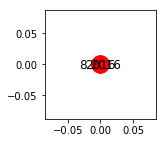

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.03 s
Mine:	-0.03 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


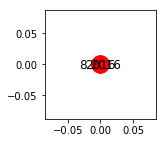

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.05 s
Mine:	-0.05 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


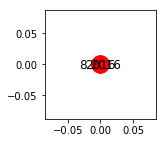

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.28 s
Mine:	-0.28 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


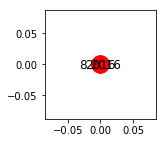

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.22 s
Mine:	-0.22 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


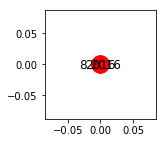

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


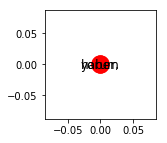

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 8


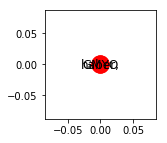

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 8


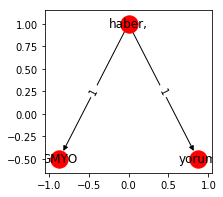

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


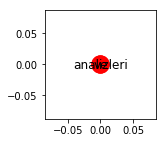

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


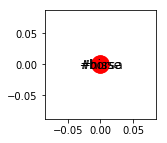

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


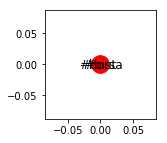

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 7
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


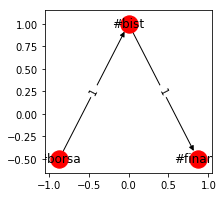

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


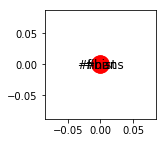

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 9
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


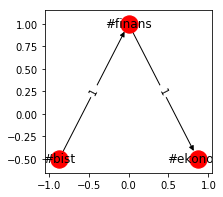

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


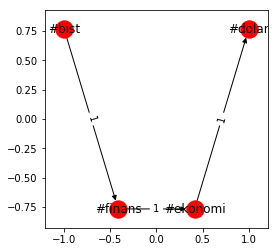

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


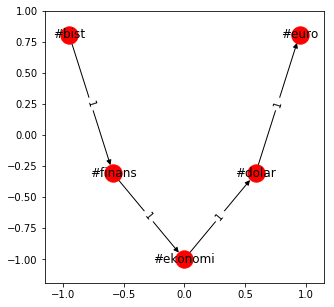

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


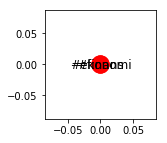

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


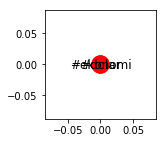

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


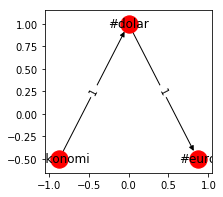

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


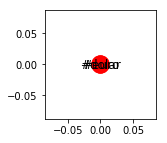

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.28 s
Mine:	-0.28 s
Total:	0.0 s
t # 0
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


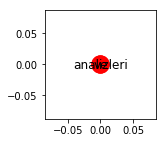

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


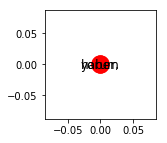

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 8


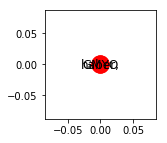

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 8


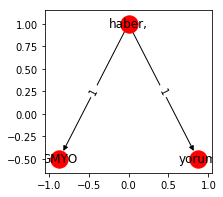

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


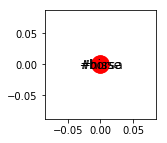

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


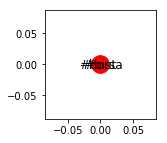

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


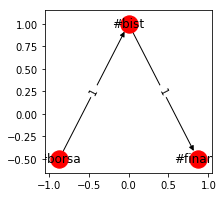

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 7
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


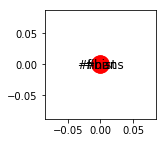

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


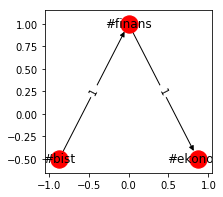

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 9
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


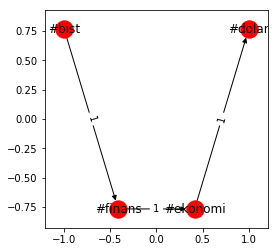

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


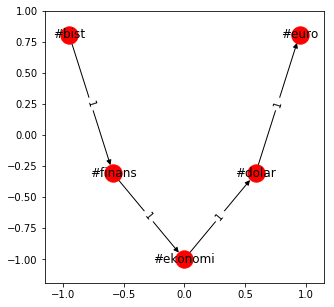

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


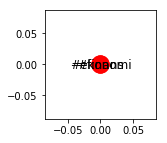

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


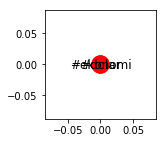

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


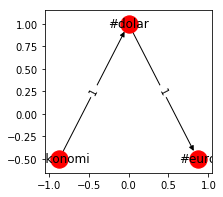

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


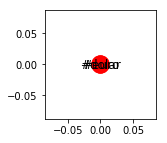

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.06 s
Mine:	-0.06 s
Total:	0.0 s
Read:	0.06 s
Mine:	-0.06 s
Total:	0.0 s
Read:	0.21 s
Mine:	-0.21 s
Total:	0.0 s
Read:	0.06 s
Mine:	-0.06 s
Total:	0.0 s
Read:	0.21 s
Mine:	-0.21 s
Total:	0.0 s
t # 0
v 0 10.2016
v 1 2016
e 0 1 1

Support: 8


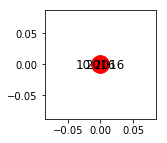

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


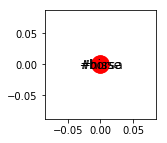

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


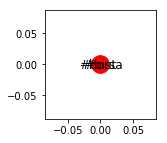

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


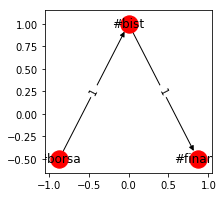

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


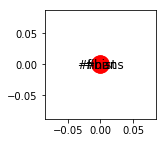

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


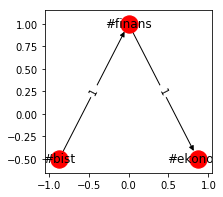

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


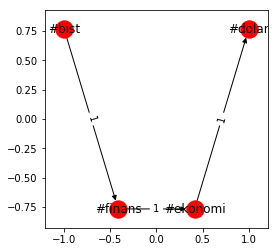

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 7
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


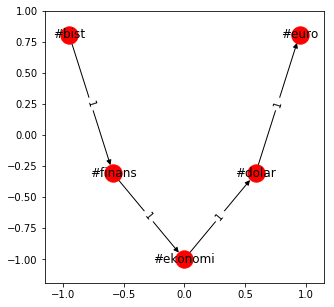

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


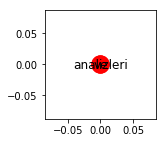

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 9
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


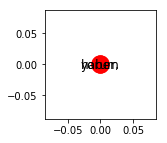

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 10
v 0 analizleri
v 1 !
e 0 1 1

Support: 8


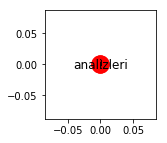

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


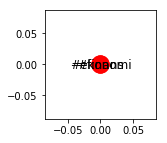

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


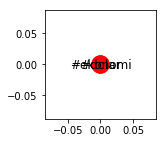

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


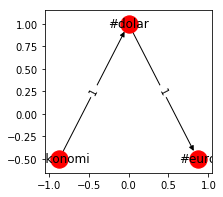

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


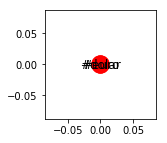

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 10.2016
v 1 2016
e 0 1 1

Support: 8


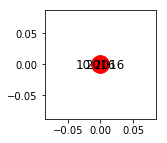

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


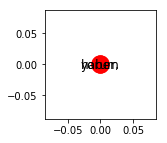

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


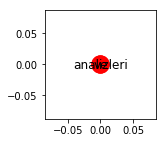

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 analizleri
v 1 !
e 0 1 1

Support: 8


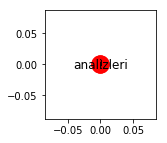

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


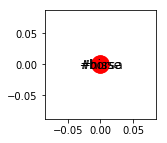

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


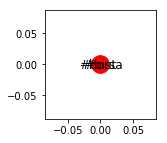

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


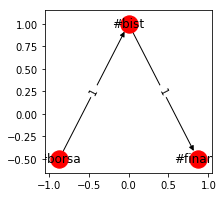

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 7
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 8


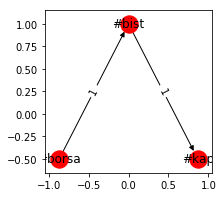

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


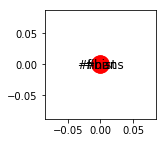

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 9
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


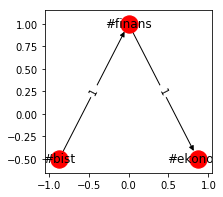

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


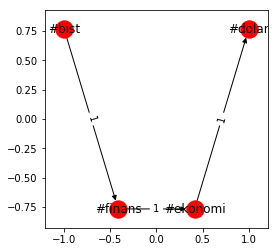

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


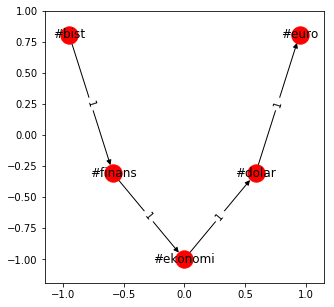

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
v 5 #kap
e 0 1 1
e 0 5 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


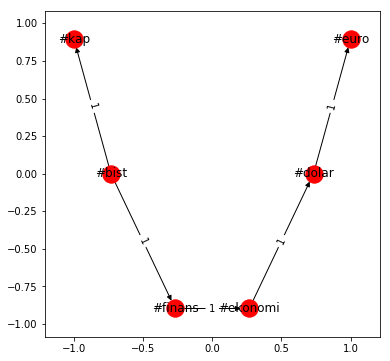

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #kap
e 0 1 1
e 0 4 1
e 1 2 1
e 2 3 1

Support: 8


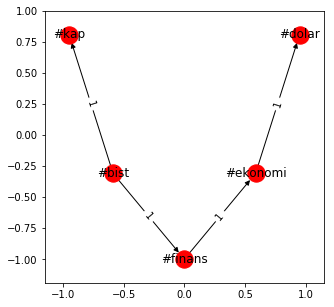

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #kap
e 0 1 1
e 0 3 1
e 1 2 1

Support: 8


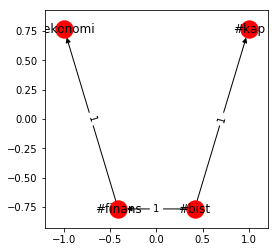

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #bist
v 1 #finans
v 2 #kap
e 0 1 1
e 0 2 1

Support: 8


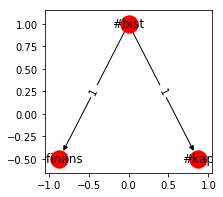

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 16
v 0 #bist
v 1 #kap
e 0 1 1

Support: 8


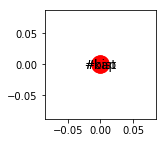

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


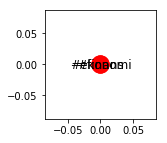

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


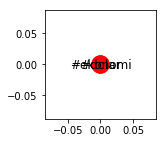

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


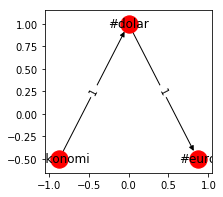

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


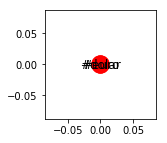

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 21
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 8


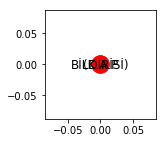

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
e 0 1 1
e 1 2 1

Support: 8


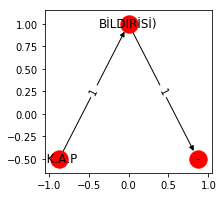

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 23
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


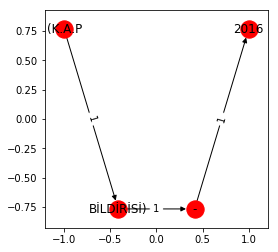

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 24
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


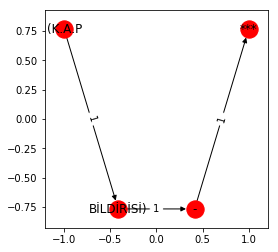

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 25
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 8


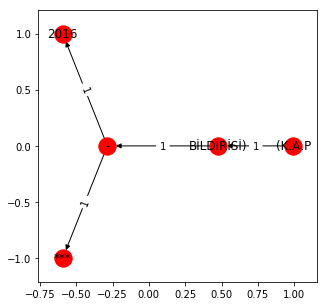

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 26
v 0 BİLDİRİSİ)
v 1 -
e 0 1 1

Support: 8


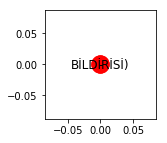

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 27
v 0 -
v 1 2016
e 0 1 1

Support: 8


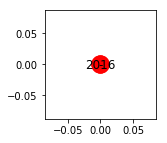

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 28
v 0 -
v 1 ***
e 0 1 1

Support: 8


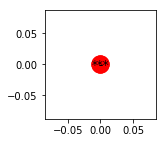

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 29
v 0 -
v 1 ***
v 2 2016
e 0 1 1
e 0 2 1

Support: 8


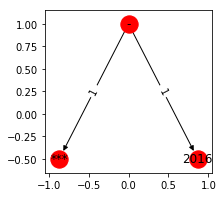

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 30
v 0 Ekim
v 1 2016
e 0 1 1

Support: 8


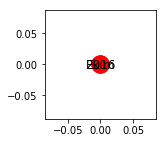

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


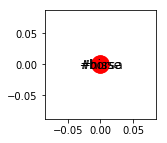

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


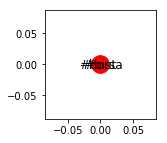

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 8


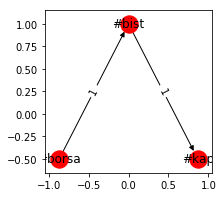

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 #bist
v 1 #kap
e 0 1 1

Support: 8


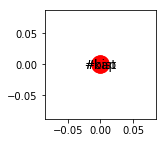

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 8


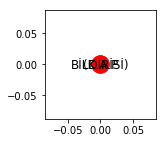

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 -
v 1 ***
e 0 1 1

Support: 8


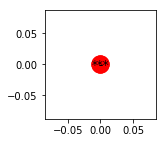

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.05 s
Mine:	-0.05 s
Total:	0.0 s
Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
Read:	0.03 s
Mine:	-0.03 s
Total:	0.0 s
t # 0
v 0 11.2016
v 1 2016
e 0 1 1

Support: 8


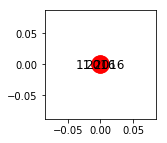

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.02 s
Mine:	-0.02 s
Total:	0.0 s
t # 0
v 0 11.2016
v 1 2016
e 0 1 1

Support: 8


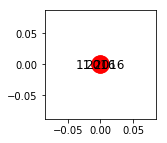

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.01 s
Mine:	-0.01 s
Total:	0.0 s
t # 0
v 0 11.2016
v 1 2016
e 0 1 1

Support: 8


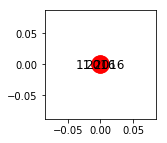

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.02 s
Mine:	-0.02 s
Total:	0.0 s


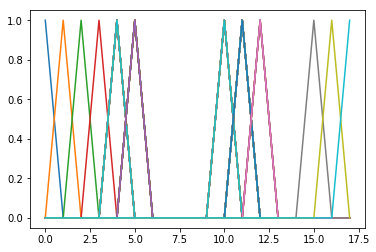

In [176]:

# run_all method parameters respectively
# support, window_value, distance, database_choice
all_graphs = run_all(8,8,2,2)


t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


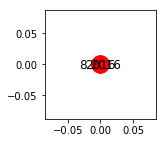

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 ve
v 1 analizleri
e 0 1 1

Support: 5


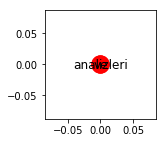

where: [2, 3, 4, 5, 7]

-----------------

t # 2
v 0 haber,
v 1 yorum
e 0 1 1

Support: 5


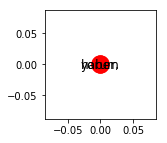

where: [2, 3, 4, 5, 7]

-----------------

t # 3
v 0 analizleri
v 1 !
e 0 1 1

Support: 5


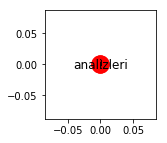

where: [2, 3, 4, 5, 7]

-----------------

t # 4
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 5


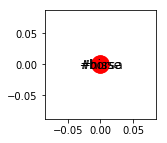

where: [2, 3, 4, 5, 7]

-----------------

t # 5
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 5


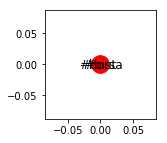

where: [2, 3, 4, 5, 7]

-----------------

t # 6
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 5


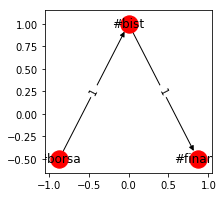

where: [2, 3, 4, 5, 7]

-----------------

t # 7
v 0 #bist
v 1 #finans
e 0 1 1

Support: 5


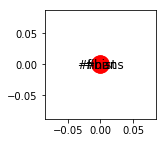

where: [2, 3, 4, 5, 7]

-----------------

t # 8
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 5


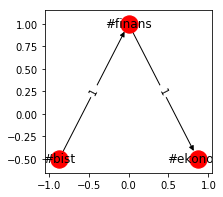

where: [2, 3, 4, 5, 7]

-----------------

t # 9
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


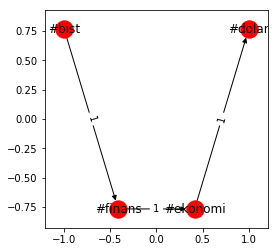

where: [2, 3, 4, 5, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


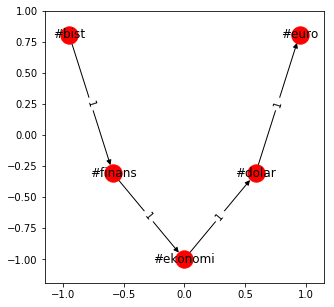

where: [2, 3, 4, 5, 7]

-----------------

t # 11
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 5


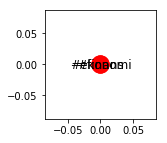

where: [2, 3, 4, 5, 7]

-----------------

t # 12
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 5


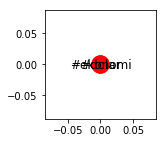

where: [2, 3, 4, 5, 7]

-----------------

t # 13
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 5


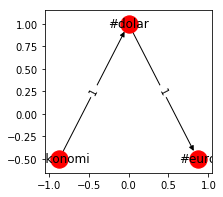

where: [2, 3, 4, 5, 7]

-----------------

t # 14
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 5


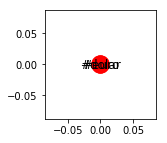

where: [2, 3, 4, 5, 7]

-----------------

Read:	0.03 s
Mine:	-0.03 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


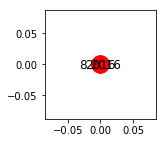

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 ve
v 1 analizleri
e 0 1 1

Support: 7


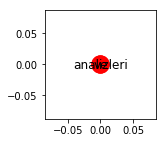

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 2
v 0 haber,
v 1 yorum
e 0 1 1

Support: 7


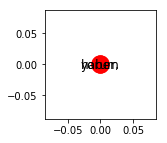

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 3
v 0 haber,
v 1 yorum
v 2 ÇİMENTO
e 0 1 1
e 0 2 1

Support: 5


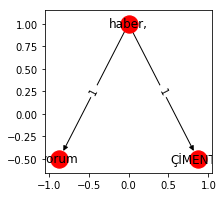

where: [0, 2, 3, 5, 7]

-----------------

t # 4
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 6


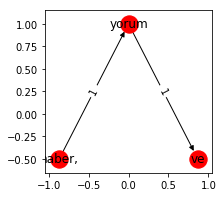

where: [1, 2, 3, 5, 6, 7]

-----------------

t # 5
v 0 haber,
v 1 ÇİMENTO
e 0 1 1

Support: 5


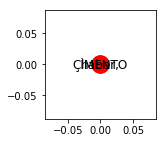

where: [0, 2, 3, 5, 7]

-----------------

t # 6
v 0 analizleri
v 1 !
e 0 1 1

Support: 7


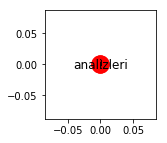

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 7
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 7


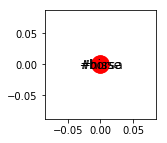

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 8
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 7


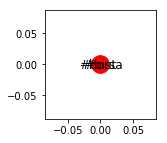

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 9
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 7


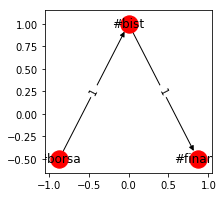

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
e 0 1 1

Support: 7


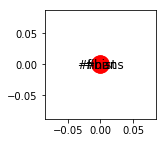

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 11
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 7


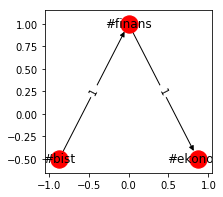

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 12
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


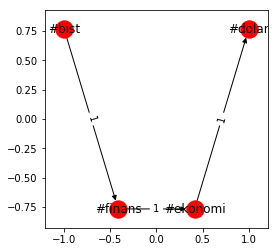

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 13
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 7


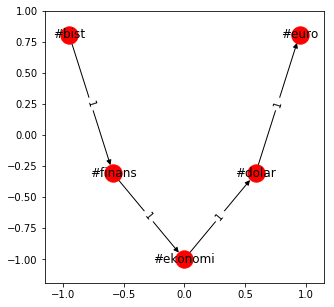

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 14
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 7


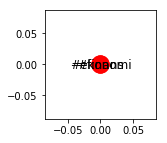

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 15
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 7


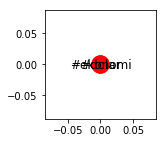

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 16
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 7


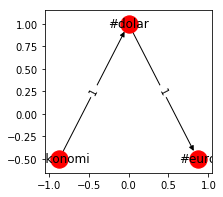

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 17
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 7


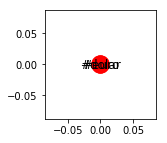

where: [0, 1, 2, 3, 5, 6, 7]

-----------------

t # 18
v 0 yorum
v 1 ve
e 0 1 1

Support: 6


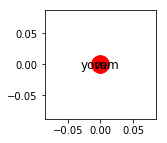

where: [1, 2, 3, 5, 6, 7]

-----------------

t # 19
v 0 RT
v 1 @Futbol_5:
e 0 1 1

Support: 5


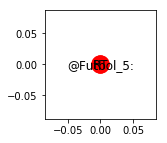

where: [1, 2, 3, 5, 6]

-----------------

t # 20
v 0 RT
v 1 @teroretavizyok:
e 0 1 1

Support: 6


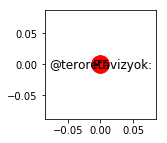

where: [1, 2, 3, 5, 6, 7]

-----------------

Read:	0.05 s
Mine:	-0.05 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


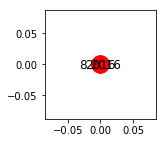

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 7


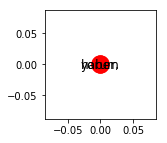

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 6


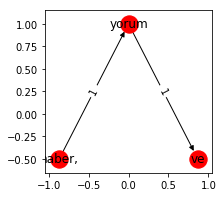

where: [0, 1, 3, 4, 5, 7]

-----------------

t # 3
v 0 haber,
v 1 yorum
v 2 ve
v 3 ÇİMENTO
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


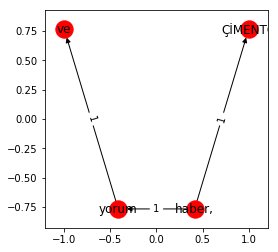

where: [0, 1, 3, 5, 7]

-----------------

t # 4
v 0 haber,
v 1 yorum
v 2 ÇİMENTO
e 0 1 1
e 0 2 1

Support: 6


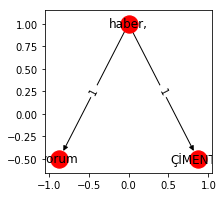

where: [0, 1, 3, 5, 6, 7]

-----------------

t # 5
v 0 haber,
v 1 ÇİMENTO
e 0 1 1

Support: 6


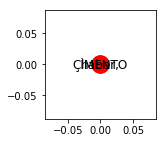

where: [0, 1, 3, 5, 6, 7]

-----------------

t # 6
v 0 yorum
v 1 ve
e 0 1 1

Support: 6


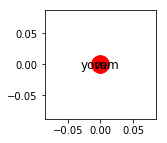

where: [0, 1, 3, 4, 5, 7]

-----------------

t # 7
v 0 ve
v 1 analizleri
e 0 1 1

Support: 7


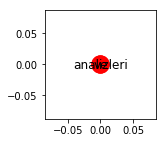

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 analizleri
v 1 !
e 0 1 1

Support: 6


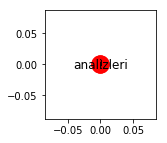

where: [0, 1, 3, 4, 5, 7]

-----------------

t # 9
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 7


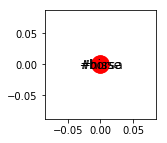

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 10
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 7


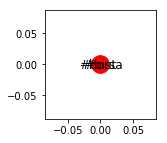

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 7


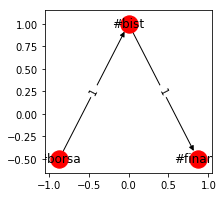

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #bist
v 1 #finans
e 0 1 1

Support: 7


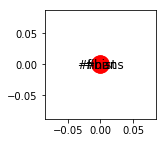

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 7


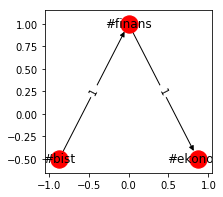

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


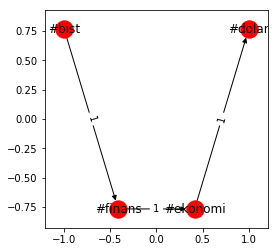

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 7


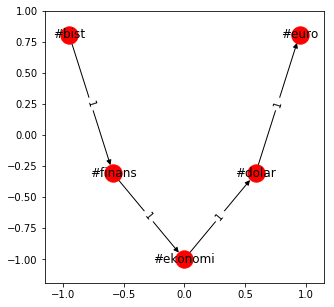

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 16
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 7


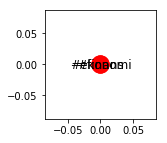

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 7


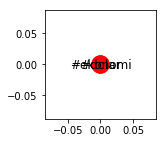

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 7


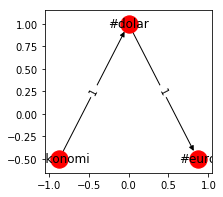

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 7


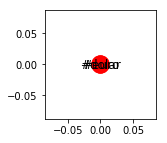

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 RT
v 1 @Futbol_5:
e 0 1 1

Support: 5


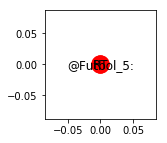

where: [0, 1, 3, 4, 7]

-----------------

t # 21
v 0 RT
v 1 @teroretavizyok:
e 0 1 1

Support: 7


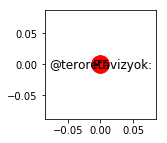

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 RT
v 1 @Cimbomist14:
e 0 1 1

Support: 5


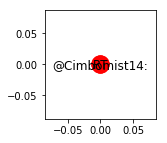

where: [0, 1, 3, 5, 7]

-----------------

t # 23
v 0 RT
v 1 @KptKUTERO:
e 0 1 1

Support: 6


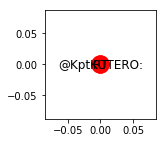

where: [1, 3, 4, 5, 6, 7]

-----------------

t # 24
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 6


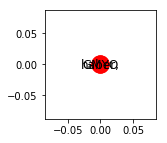

where: [1, 3, 4, 5, 6, 7]

-----------------

t # 25
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 6


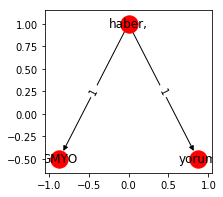

where: [1, 3, 4, 5, 6, 7]

-----------------

t # 26
v 0 haber,
v 1 GMYO
v 2 yorum
v 3 ve
e 0 1 1
e 0 2 1
e 2 3 1

Support: 5


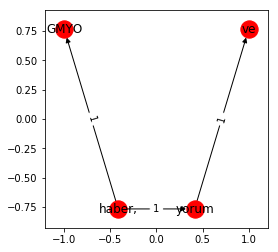

where: [1, 3, 4, 5, 7]

-----------------

t # 27
v 0 haber,
v 1 GMYO
v 2 yorum
v 3 ÇİMENTO
e 0 1 1
e 0 2 1
e 0 3 1

Support: 5


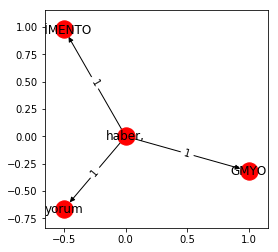

where: [1, 3, 5, 6, 7]

-----------------

t # 28
v 0 haber,
v 1 GMYO
v 2 ÇİMENTO
e 0 1 1
e 0 2 1

Support: 5


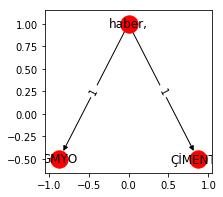

where: [1, 3, 5, 6, 7]

-----------------

Read:	0.26 s
Mine:	-0.26 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


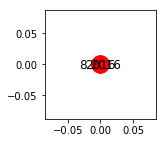

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 RT
v 1 @CimbomluBob:
e 0 1 1

Support: 5


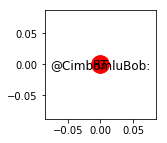

where: [0, 3, 4, 5, 6]

-----------------

t # 2
v 0 haber,
v 1 yorum
e 0 1 1

Support: 7


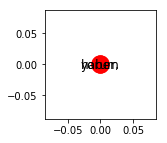

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 6


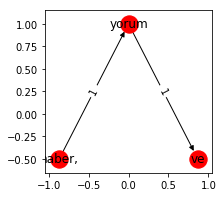

where: [1, 2, 3, 5, 6, 7]

-----------------

t # 4
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 7


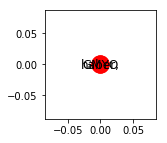

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 7


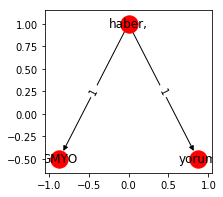

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 haber,
v 1 GMYO
v 2 yorum
v 3 ve
e 0 1 1
e 0 2 1
e 2 3 1

Support: 6


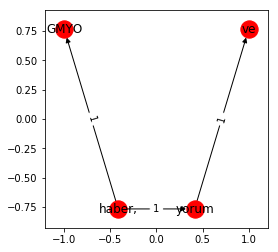

where: [1, 2, 3, 5, 6, 7]

-----------------

t # 7
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 5


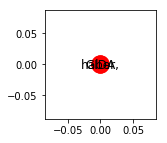

where: [1, 2, 4, 5, 7]

-----------------

t # 8
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


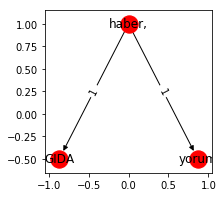

where: [1, 2, 4, 5, 7]

-----------------

t # 9
v 0 yorum
v 1 ve
e 0 1 1

Support: 6


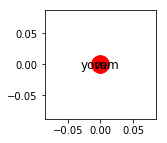

where: [1, 2, 3, 5, 6, 7]

-----------------

t # 10
v 0 ve
v 1 analizleri
e 0 1 1

Support: 7


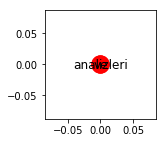

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 analizleri
v 1 !
e 0 1 1

Support: 5


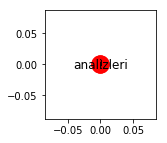

where: [1, 2, 3, 5, 6]

-----------------

t # 12
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 7


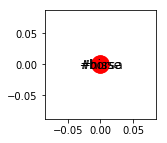

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 7


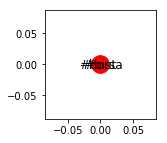

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 7


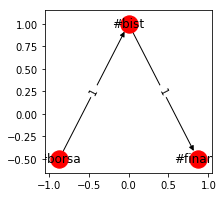

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #bist
v 1 #finans
e 0 1 1

Support: 7


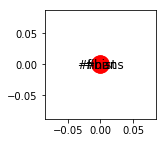

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 16
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 7


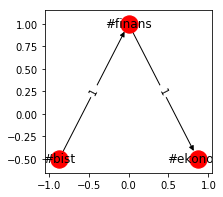

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


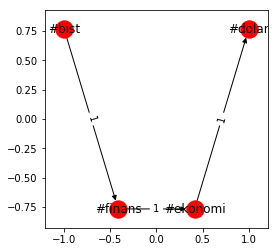

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 7


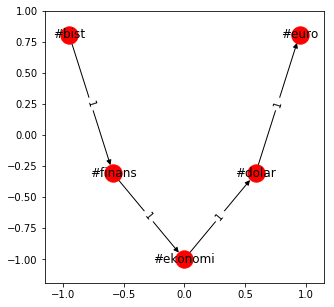

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 7


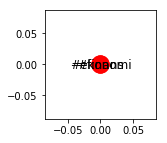

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 7


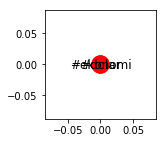

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 21
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 7


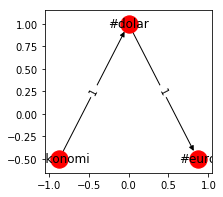

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 7


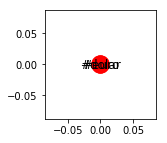

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 23
v 0 RT
v 1 @KptKUTERO:
e 0 1 1

Support: 5


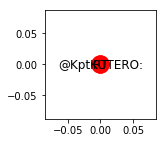

where: [1, 2, 3, 4, 5]

-----------------

t # 24
v 0 RT
v 1 @teroretavizyok:
e 0 1 1

Support: 7


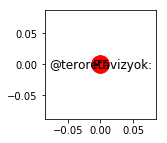

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 25
v 0 RT
v 1 @AJTurk:
e 0 1 1

Support: 6


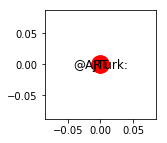

where: [1, 2, 4, 5, 6, 7]

-----------------

t # 26
v 0 RT
v 1 @Futbol_5:
e 0 1 1

Support: 5


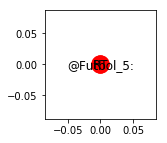

where: [1, 2, 5, 6, 7]

-----------------

t # 27
v 0 RT
v 1 @SelimAtalayNY:
e 0 1 1

Support: 5


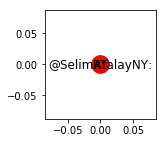

where: [2, 3, 4, 6, 7]

-----------------

Read:	0.08 s
Mine:	-0.08 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 8


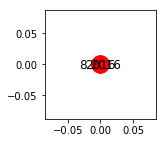

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


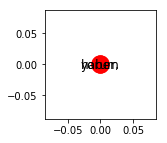

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 7


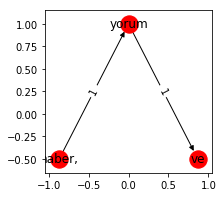

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 5


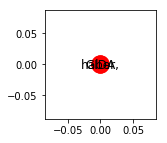

where: [0, 2, 3, 5, 6]

-----------------

t # 4
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


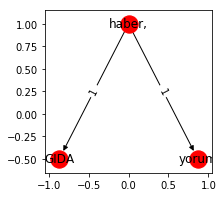

where: [0, 2, 3, 5, 6]

-----------------

t # 5
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 8


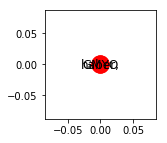

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 8


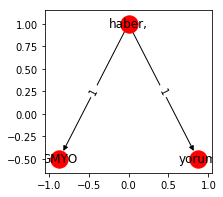

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 7
v 0 haber,
v 1 GMYO
v 2 yorum
v 3 ve
e 0 1 1
e 0 2 1
e 2 3 1

Support: 7


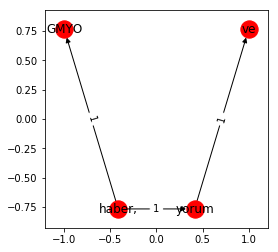

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 haber,
v 1 TURİZM
e 0 1 1

Support: 5


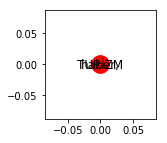

where: [0, 2, 4, 5, 6]

-----------------

t # 9
v 0 haber,
v 1 TURİZM
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


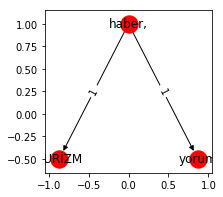

where: [0, 2, 4, 5, 6]

-----------------

t # 10
v 0 yorum
v 1 ve
e 0 1 1

Support: 7


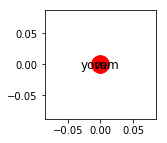

where: [0, 1, 3, 4, 5, 6, 7]

-----------------

t # 11
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


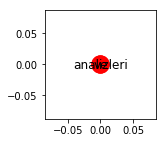

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 analizleri
v 1 !
e 0 1 1

Support: 6


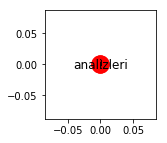

where: [0, 1, 3, 4, 6, 7]

-----------------

t # 13
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


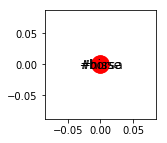

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


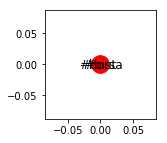

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


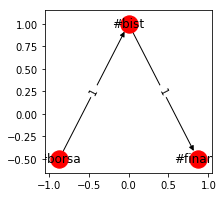

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 16
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


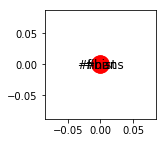

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


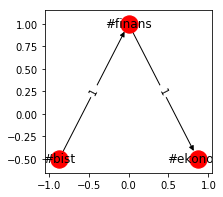

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


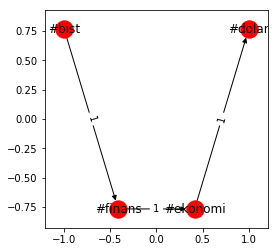

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


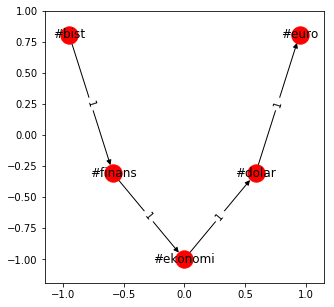

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


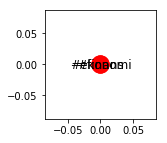

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 21
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


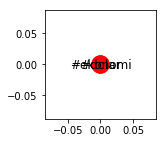

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


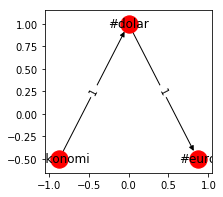

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 23
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


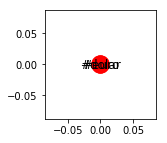

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 24
v 0 RT
v 1 @AJTurk:
e 0 1 1

Support: 5


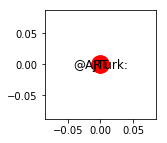

where: [0, 2, 3, 4, 5]

-----------------

t # 25
v 0 RT
v 1 @Efsanespors:
e 0 1 1

Support: 5


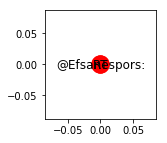

where: [0, 2, 3, 4, 6]

-----------------

t # 26
v 0 RT
v 1 @Futbol_5:
e 0 1 1

Support: 5


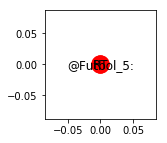

where: [0, 3, 4, 5, 6]

-----------------

t # 27
v 0 RT
v 1 @teroretavizyok:
e 0 1 1

Support: 7


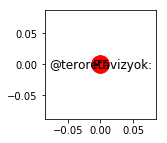

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 28
v 0 RT
v 1 @footbalista_:
e 0 1 1

Support: 5


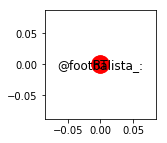

where: [0, 2, 4, 5, 6]

-----------------

t # 29
v 0 RT
v 1 @SelimAtalayNY:
e 0 1 1

Support: 5


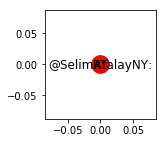

where: [0, 1, 2, 4, 5]

-----------------

Read:	0.26 s
Mine:	-0.26 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 7


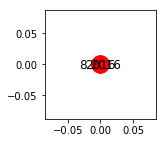

where: [0, 1, 2, 3, 4, 5, 6]

-----------------

t # 1
v 0 RT
v 1 @teroretavizyok:
e 0 1 1

Support: 5


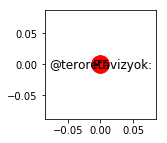

where: [0, 1, 2, 3, 5]

-----------------

t # 2
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


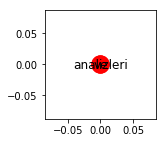

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


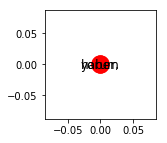

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 7


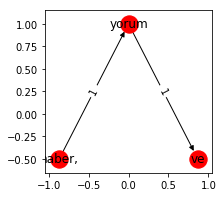

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 8


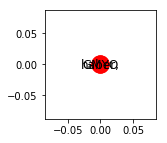

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 8


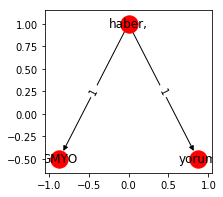

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 7
v 0 haber,
v 1 GMYO
v 2 yorum
v 3 ve
e 0 1 1
e 0 2 1
e 2 3 1

Support: 7


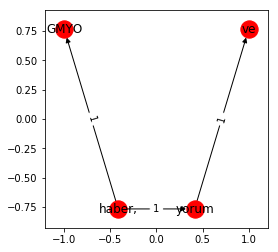

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 haber,
v 1 TEKSTİL
e 0 1 1

Support: 5


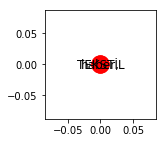

where: [0, 3, 5, 6, 7]

-----------------

t # 9
v 0 haber,
v 1 TEKSTİL
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


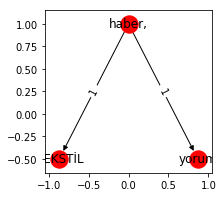

where: [0, 3, 5, 6, 7]

-----------------

t # 10
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 5


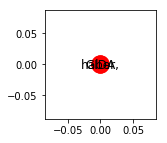

where: [0, 1, 3, 4, 6]

-----------------

t # 11
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


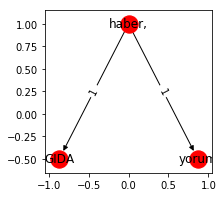

where: [0, 1, 3, 4, 6]

-----------------

t # 12
v 0 haber,
v 1 TURİZM
e 0 1 1

Support: 5


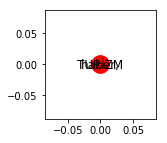

where: [0, 2, 3, 4, 6]

-----------------

t # 13
v 0 haber,
v 1 TURİZM
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


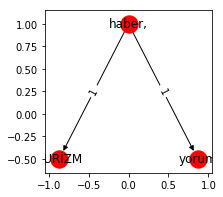

where: [0, 2, 3, 4, 6]

-----------------

t # 14
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


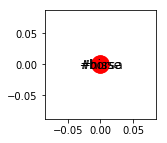

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


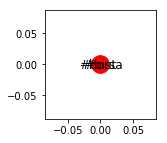

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 16
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


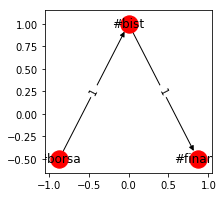

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


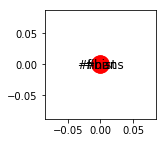

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


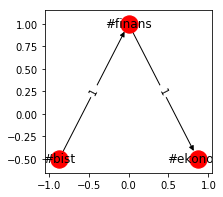

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


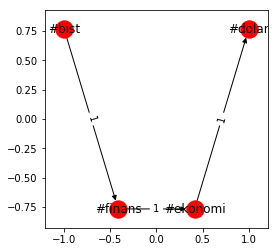

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


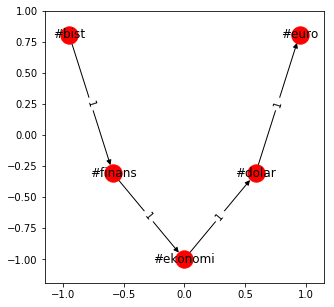

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 21
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


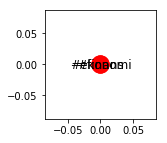

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


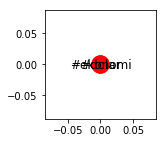

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 23
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


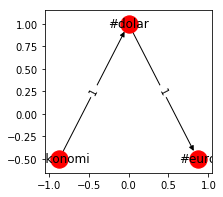

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 24
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


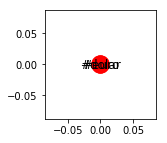

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 25
v 0 yorum
v 1 ve
e 0 1 1

Support: 7


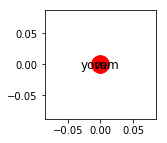

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 26
v 0 analizleri
v 1 !
e 0 1 1

Support: 6


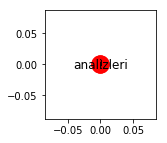

where: [1, 2, 4, 5, 6, 7]

-----------------

Read:	0.08 s
Mine:	-0.08 s
Total:	0.0 s
t # 0
v 0 8.2016
v 1 2016
e 0 1 1

Support: 5


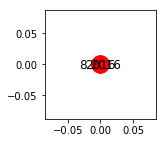

where: [0, 1, 2, 3, 4]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 6


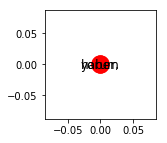

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 2
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 6


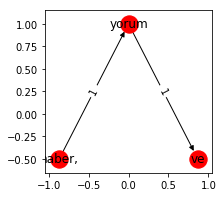

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 3
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 6


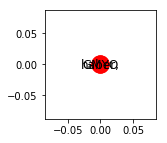

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 4
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 6


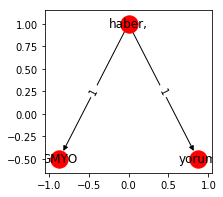

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 5
v 0 haber,
v 1 GMYO
v 2 yorum
v 3 ve
e 0 1 1
e 0 2 1
e 2 3 1

Support: 6


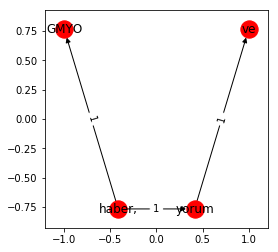

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 6
v 0 yorum
v 1 ve
e 0 1 1

Support: 6


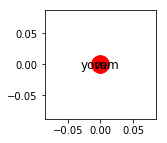

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 7
v 0 ve
v 1 analizleri
e 0 1 1

Support: 6


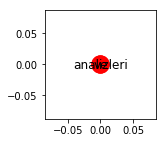

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 8
v 0 analizleri
v 1 !
e 0 1 1

Support: 5


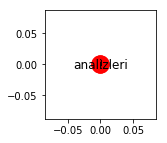

where: [0, 2, 3, 4, 5]

-----------------

t # 9
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 6


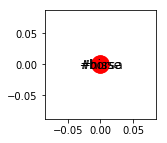

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 10
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 6


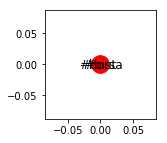

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 11
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 6


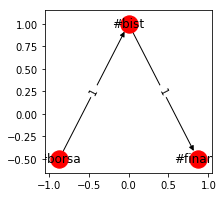

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 12
v 0 #bist
v 1 #finans
e 0 1 1

Support: 6


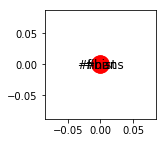

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 13
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 6


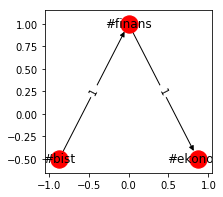

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 14
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 6


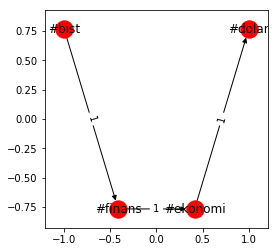

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 15
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 6


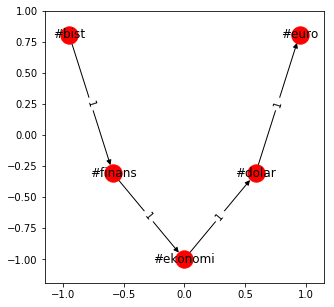

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 16
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 6


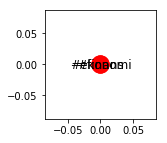

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 17
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 6


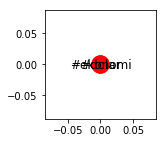

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 18
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 6


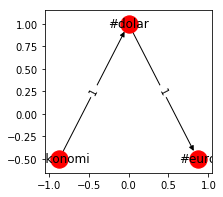

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 19
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 6


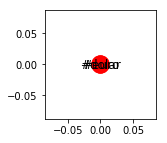

where: [0, 1, 2, 3, 4, 5]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 6


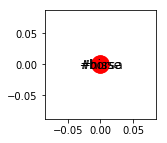

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 1
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 6


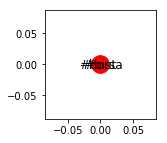

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 2
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 6


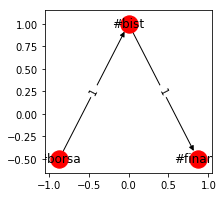

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 3
v 0 #bist
v 1 #finans
e 0 1 1

Support: 6


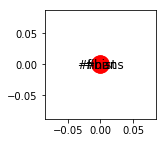

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 4
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 6


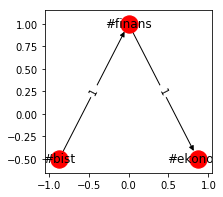

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 5
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 6


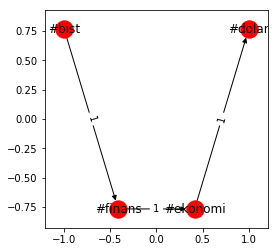

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 6
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 6


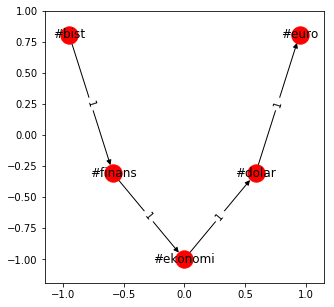

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 7
v 0 haber,
v 1 yorum
e 0 1 1

Support: 6


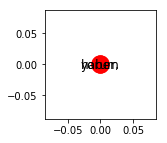

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 8
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 6


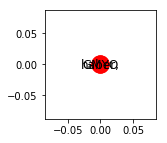

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 9
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 6


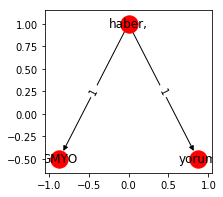

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 10
v 0 ve
v 1 analizleri
e 0 1 1

Support: 6


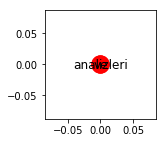

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 11
v 0 analizleri
v 1 !
e 0 1 1

Support: 6


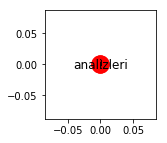

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 12
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 6


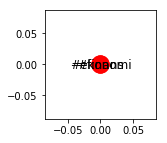

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 13
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 6


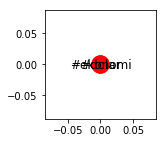

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 14
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 6


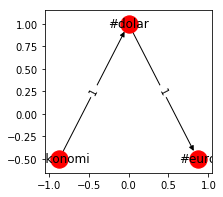

where: [0, 1, 2, 3, 6, 7]

-----------------

t # 15
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 6


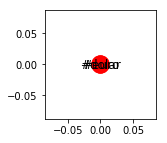

where: [0, 1, 2, 3, 6, 7]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 haber,
v 1 yorum
e 0 1 1

Support: 6


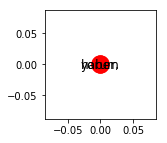

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 5


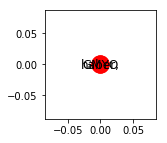

where: [0, 1, 4, 5, 6]

-----------------

t # 2
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


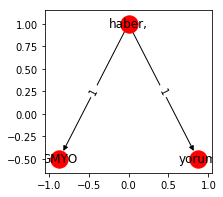

where: [0, 1, 4, 5, 6]

-----------------

t # 3
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 5


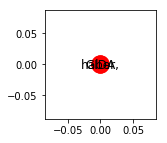

where: [0, 4, 5, 6, 7]

-----------------

t # 4
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


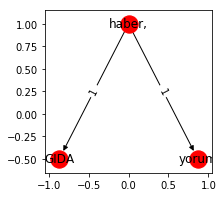

where: [0, 4, 5, 6, 7]

-----------------

t # 5
v 0 ve
v 1 analizleri
e 0 1 1

Support: 6


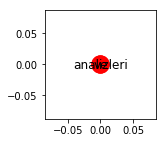

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 6
v 0 analizleri
v 1 !
e 0 1 1

Support: 6


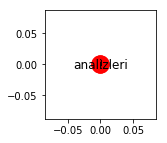

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 7
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 6


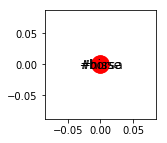

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 8
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 6


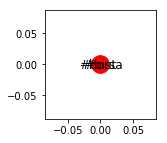

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 9
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 6


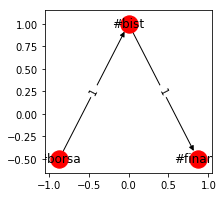

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
e 0 1 1

Support: 6


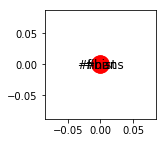

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 11
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 6


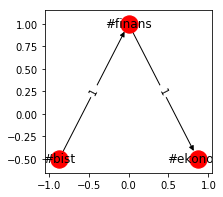

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 12
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 6


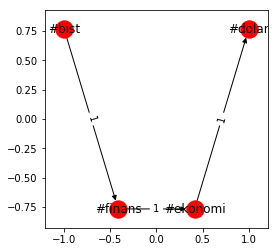

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 13
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 6


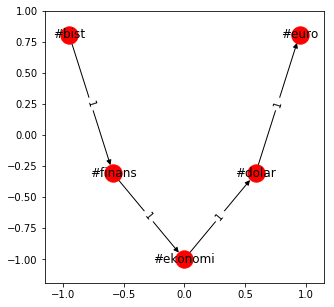

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 14
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 6


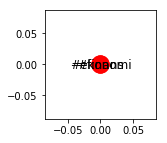

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 15
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 6


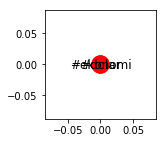

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 16
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 6


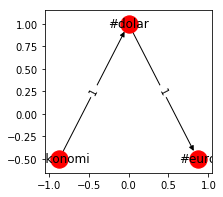

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 17
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 6


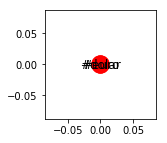

where: [0, 1, 4, 5, 6, 7]

-----------------

t # 18
v 0 10.2016
v 1 2016
e 0 1 1

Support: 5


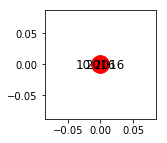

where: [3, 4, 5, 6, 7]

-----------------

Read:	0.03 s
Mine:	-0.03 s
Total:	0.0 s
t # 0
v 0 10.2016
v 1 2016
e 0 1 1

Support: 7


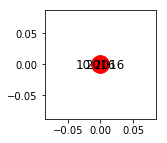

where: [1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 5


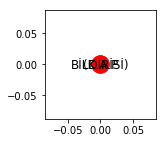

where: [2, 4, 5, 6, 7]

-----------------

t # 2
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
e 0 1 1
e 1 2 1

Support: 5


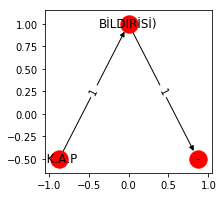

where: [2, 4, 5, 6, 7]

-----------------

t # 3
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


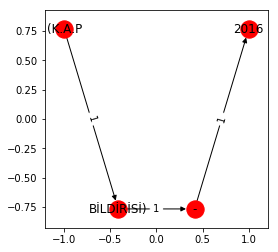

where: [2, 4, 5, 6, 7]

-----------------

t # 4
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


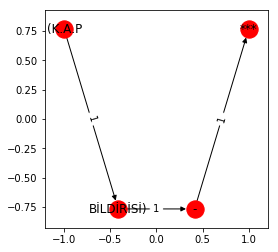

where: [2, 4, 5, 6, 7]

-----------------

t # 5
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


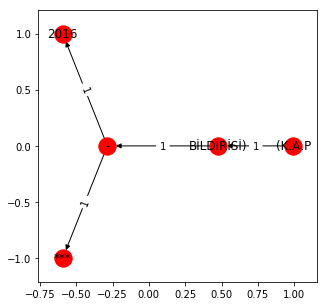

where: [2, 4, 5, 6, 7]

-----------------

t # 6
v 0 BİLDİRİSİ)
v 1 -
e 0 1 1

Support: 5


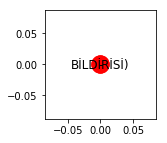

where: [2, 4, 5, 6, 7]

-----------------

t # 7
v 0 -
v 1 2016
e 0 1 1

Support: 5


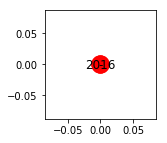

where: [2, 4, 5, 6, 7]

-----------------

t # 8
v 0 -
v 1 ***
e 0 1 1

Support: 5


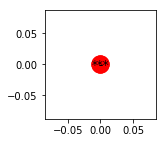

where: [2, 4, 5, 6, 7]

-----------------

t # 9
v 0 -
v 1 ***
v 2 2016
e 0 1 1
e 0 2 1

Support: 5


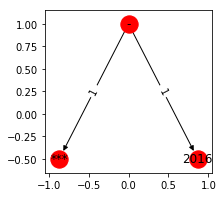

where: [2, 4, 5, 6, 7]

-----------------

t # 10
v 0 Ekim
v 1 2016
e 0 1 1

Support: 5


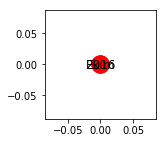

where: [2, 4, 5, 6, 7]

-----------------

t # 11
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 6


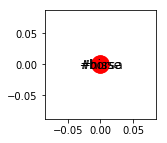

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 6


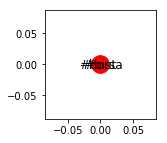

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 5


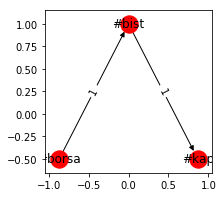

where: [2, 4, 5, 6, 7]

-----------------

t # 14
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 6


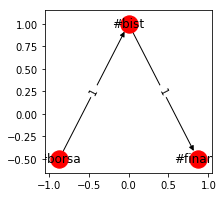

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #bist
v 1 #kap
e 0 1 1

Support: 5


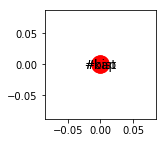

where: [2, 4, 5, 6, 7]

-----------------

t # 16
v 0 #bist
v 1 #finans
e 0 1 1

Support: 6


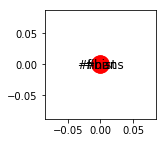

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 6


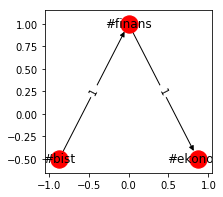

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 6


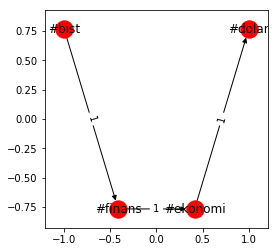

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 6


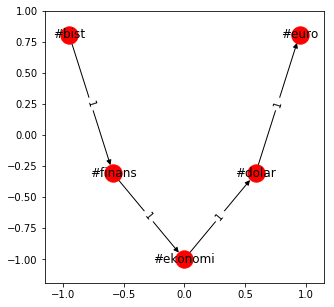

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
v 5 #kap
e 0 1 1
e 0 5 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


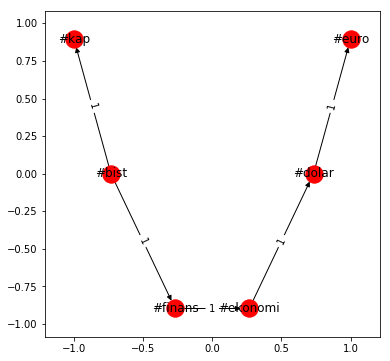

where: [2, 4, 5, 6, 7]

-----------------

t # 21
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #kap
e 0 1 1
e 0 4 1
e 1 2 1
e 2 3 1

Support: 5


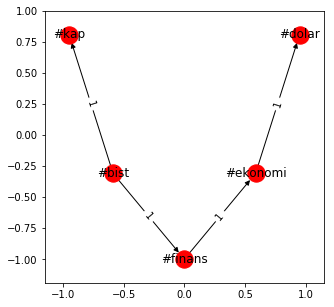

where: [2, 4, 5, 6, 7]

-----------------

t # 22
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #kap
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


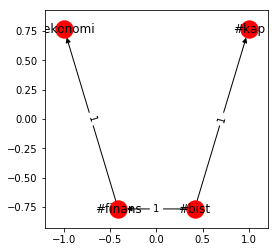

where: [2, 4, 5, 6, 7]

-----------------

t # 23
v 0 #bist
v 1 #finans
v 2 #kap
e 0 1 1
e 0 2 1

Support: 5


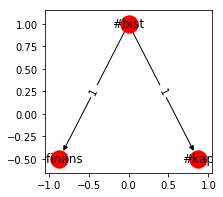

where: [2, 4, 5, 6, 7]

-----------------

t # 24
v 0 ve
v 1 analizleri
e 0 1 1

Support: 6


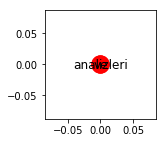

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 25
v 0 haber,
v 1 yorum
e 0 1 1

Support: 6


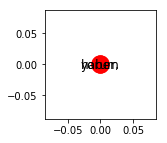

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 26
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 5


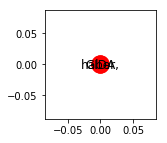

where: [2, 3, 4, 5, 6]

-----------------

t # 27
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


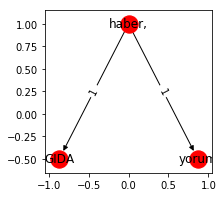

where: [2, 3, 4, 5, 6]

-----------------

t # 28
v 0 analizleri
v 1 !
e 0 1 1

Support: 6


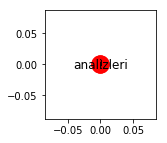

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 29
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 6


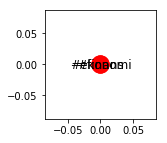

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 30
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 6


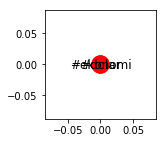

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 31
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 6


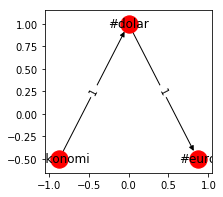

where: [2, 3, 4, 5, 6, 7]

-----------------

t # 32
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 6


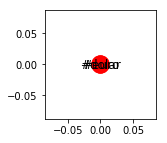

where: [2, 3, 4, 5, 6, 7]

-----------------

Read:	0.03 s
Mine:	-0.03 s
Total:	0.0 s
t # 0
v 0 10.2016
v 1 2016
e 0 1 1

Support: 8


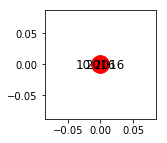

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 7


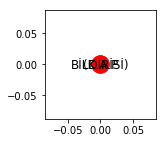

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
e 0 1 1
e 1 2 1

Support: 7


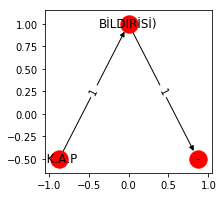

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 3
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


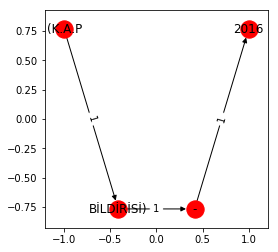

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 4
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
v 4 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


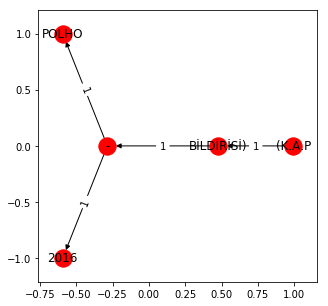

where: [2, 3, 4, 6, 7]

-----------------

t # 5
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


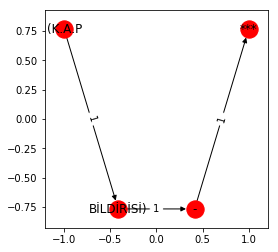

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


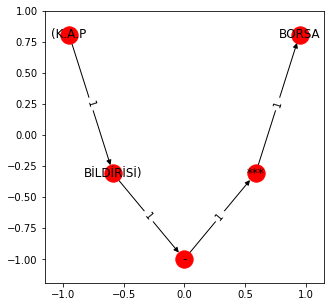

where: [0, 4, 5, 6, 7]

-----------------

t # 7
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


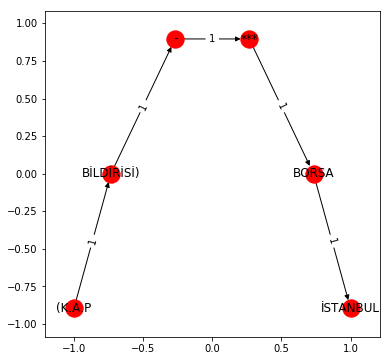

where: [0, 4, 5, 6, 7]

-----------------

t # 8
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1

Support: 5


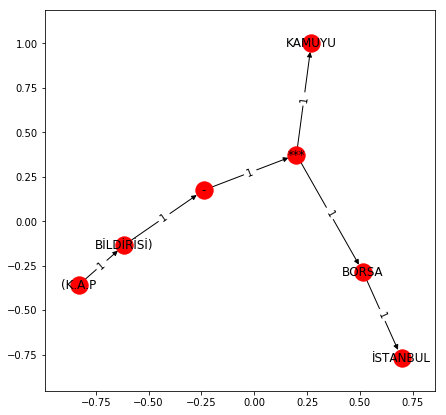

where: [0, 4, 5, 6, 7]

-----------------

t # 9
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1

Support: 5


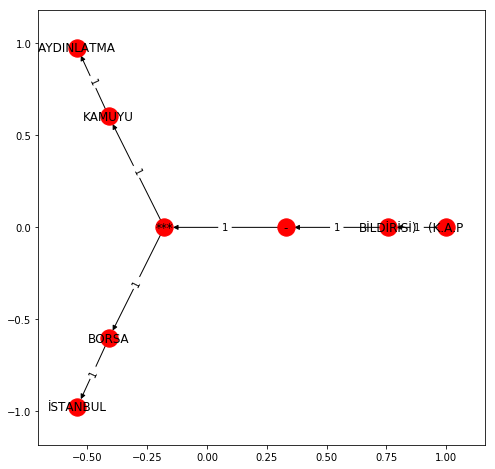

where: [0, 4, 5, 6, 7]

-----------------

t # 10
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1
e 7 8 1

Support: 5


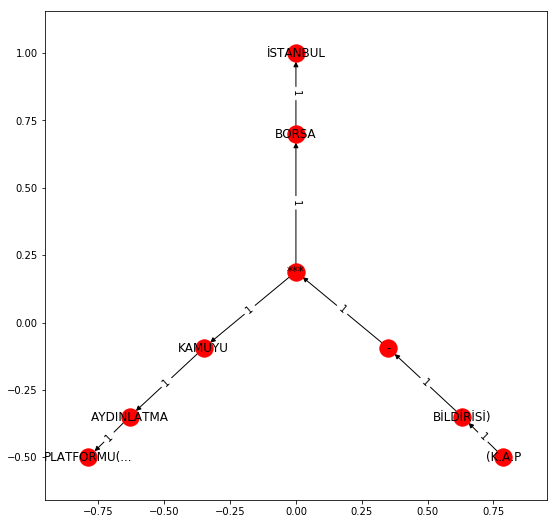

where: [0, 4, 5, 6, 7]

-----------------

t # 11
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 PLATFORMU(...
v 9 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 9 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1
e 7 8 1

Support: 5


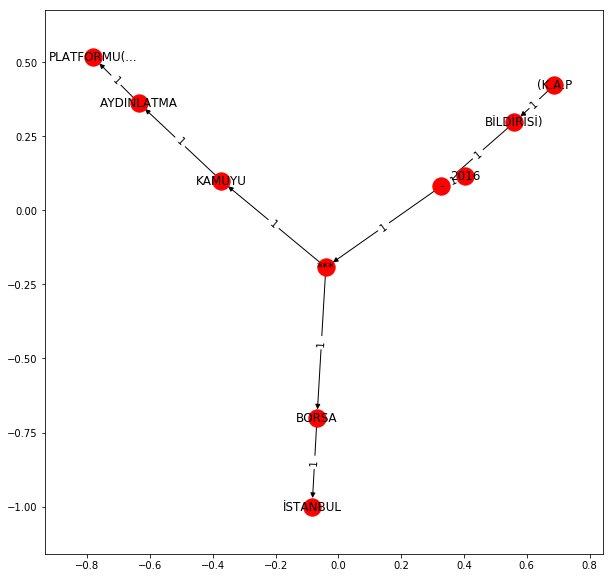

where: [0, 4, 5, 6, 7]

-----------------

t # 12
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 8 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1

Support: 5


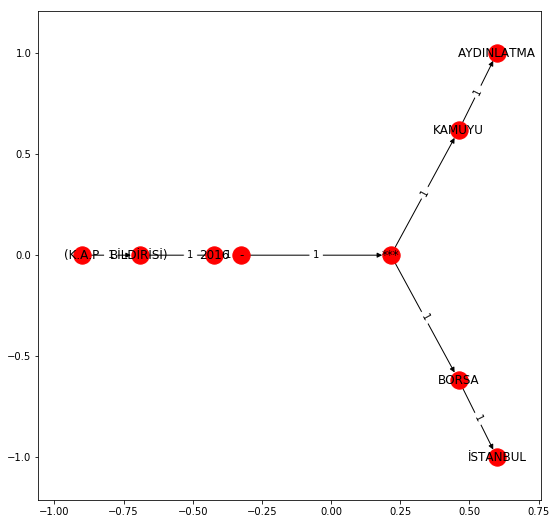

where: [0, 4, 5, 6, 7]

-----------------

t # 13
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 3 6 1
e 4 5 1

Support: 5


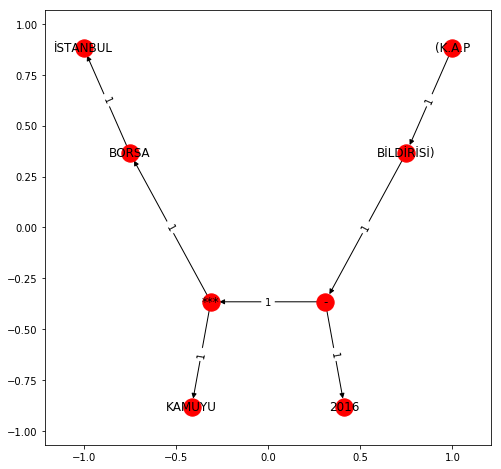

where: [0, 4, 5, 6, 7]

-----------------

t # 14
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


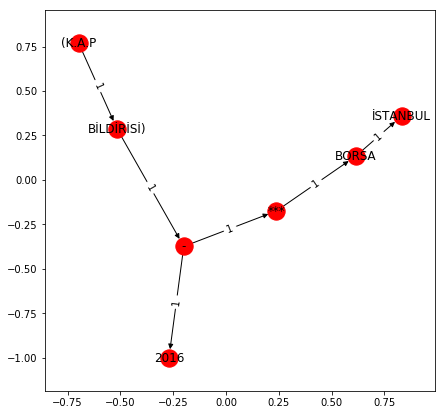

where: [0, 4, 5, 6, 7]

-----------------

t # 15
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1

Support: 5


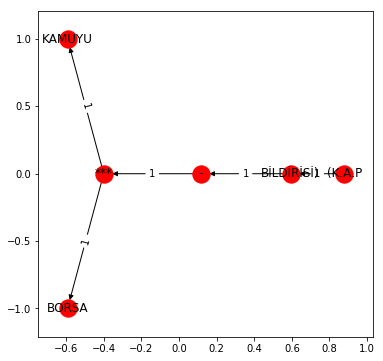

where: [0, 4, 5, 6, 7]

-----------------

t # 16
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1
e 5 6 1

Support: 5


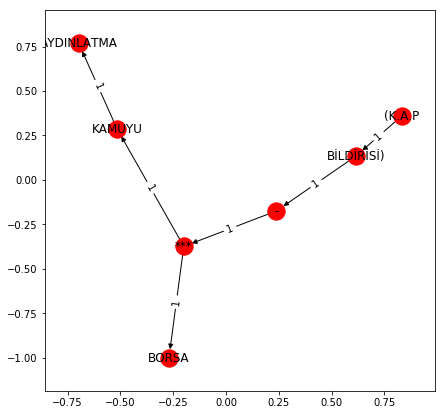

where: [0, 4, 5, 6, 7]

-----------------

t # 17
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1
e 5 6 1
e 6 7 1

Support: 5


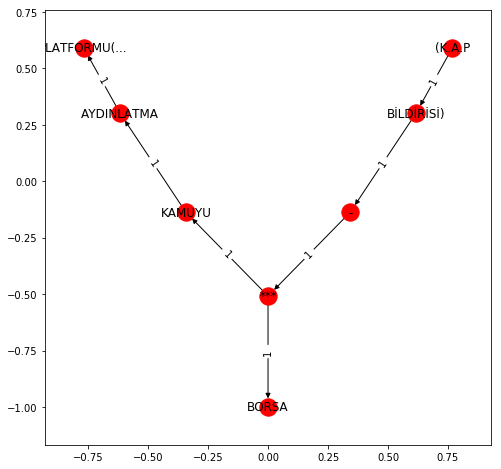

where: [0, 4, 5, 6, 7]

-----------------

t # 18
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 PLATFORMU(...
v 8 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 8 1
e 3 4 1
e 3 5 1
e 5 6 1
e 6 7 1

Support: 5


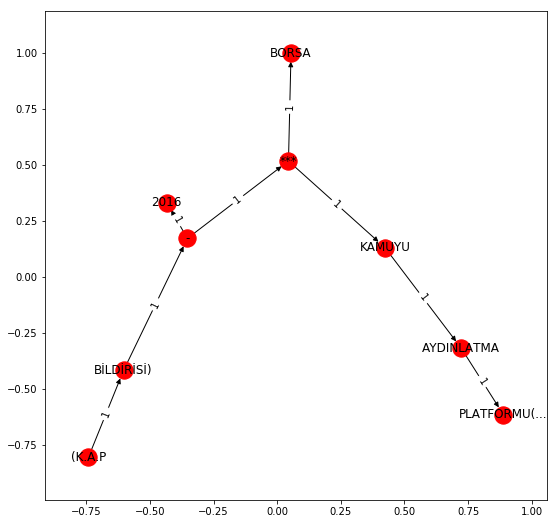

where: [0, 4, 5, 6, 7]

-----------------

t # 19
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 3 5 1
e 5 6 1

Support: 5


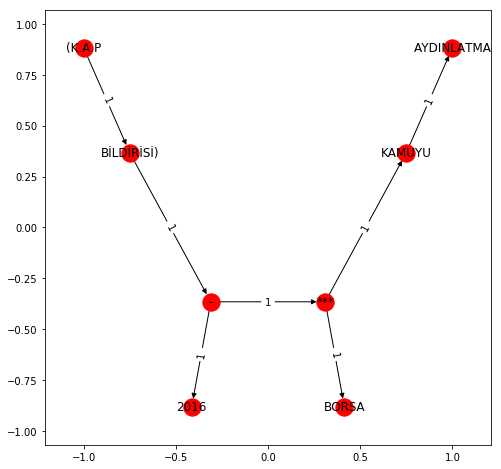

where: [0, 4, 5, 6, 7]

-----------------

t # 20
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


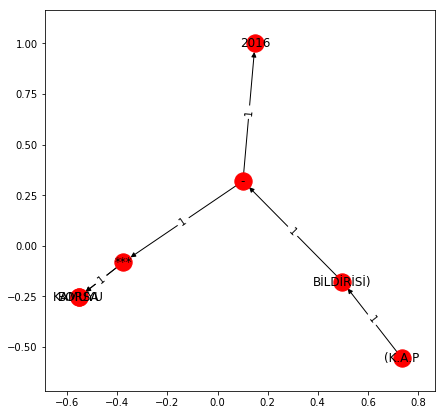

where: [0, 4, 5, 6, 7]

-----------------

t # 21
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


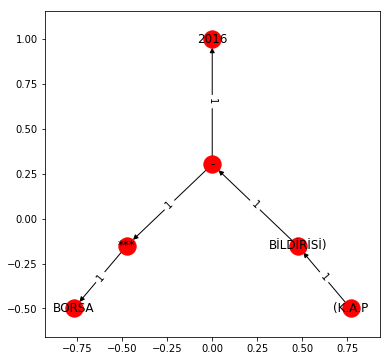

where: [0, 4, 5, 6, 7]

-----------------

t # 22
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


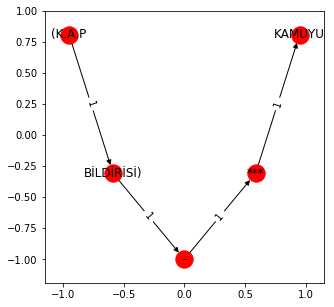

where: [0, 4, 5, 6, 7]

-----------------

t # 23
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


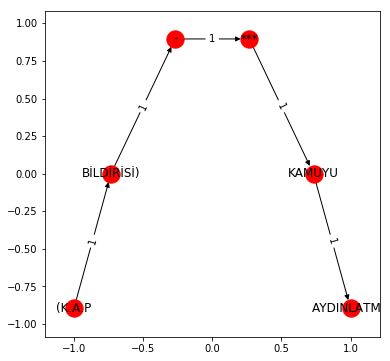

where: [0, 4, 5, 6, 7]

-----------------

t # 24
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


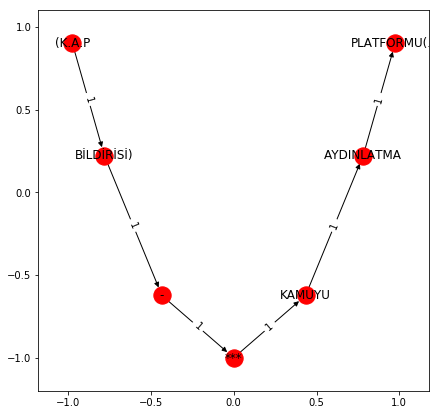

where: [0, 4, 5, 6, 7]

-----------------

t # 25
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 PLATFORMU(...
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


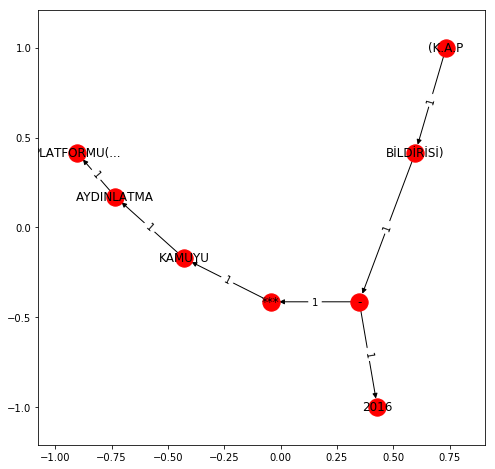

where: [0, 4, 5, 6, 7]

-----------------

t # 26
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


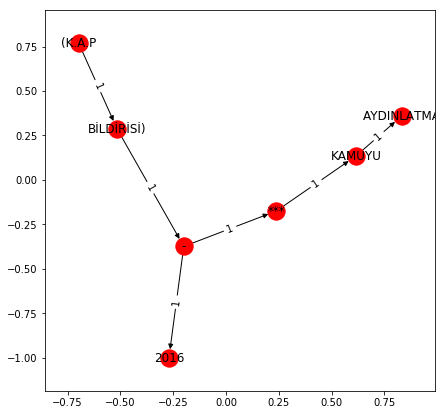

where: [0, 4, 5, 6, 7]

-----------------

t # 27
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


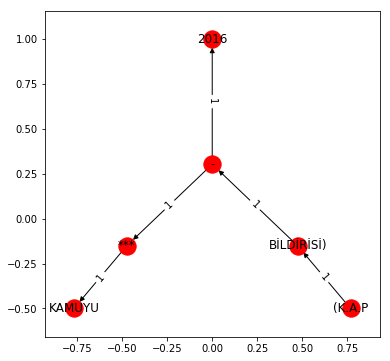

where: [0, 4, 5, 6, 7]

-----------------

t # 28
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 7


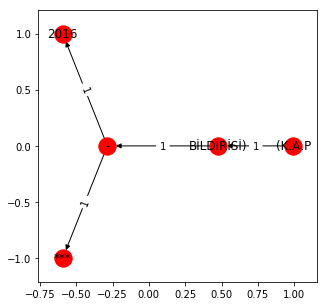

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 29
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
v 5 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1
e 2 5 1

Support: 5


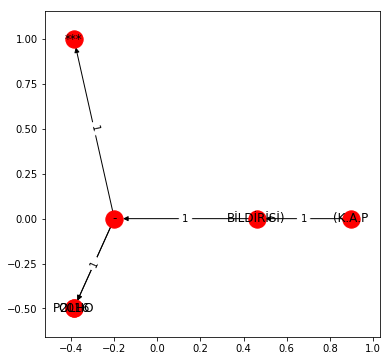

where: [2, 3, 4, 6, 7]

-----------------

t # 30
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


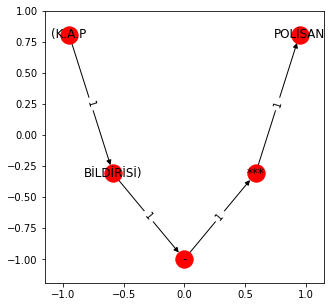

where: [2, 3, 4, 6, 7]

-----------------

t # 31
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


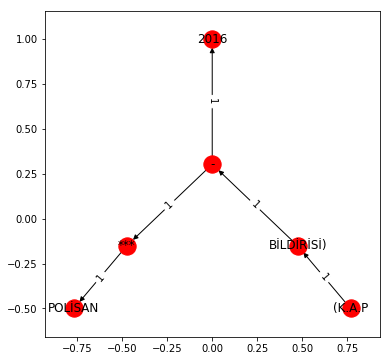

where: [2, 3, 4, 6, 7]

-----------------

t # 32
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 2016
v 6 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 2 6 1
e 3 4 1

Support: 5


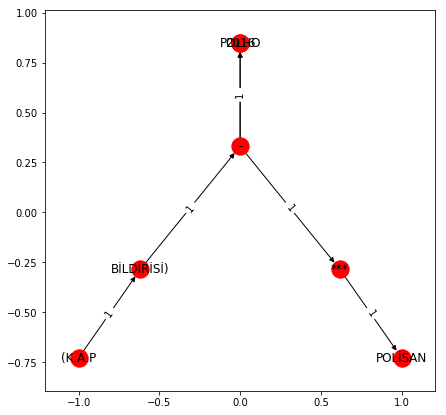

where: [2, 3, 4, 6, 7]

-----------------

t # 33
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


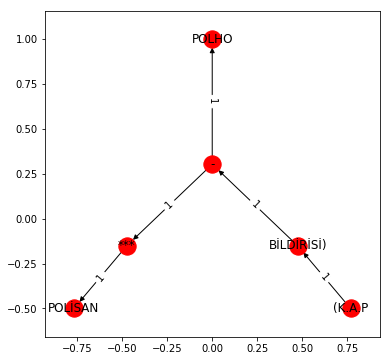

where: [2, 3, 4, 6, 7]

-----------------

t # 34
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


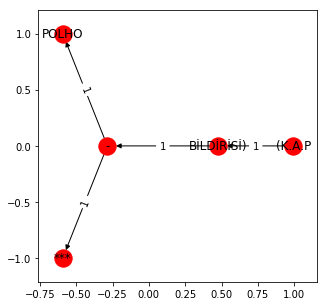

where: [2, 3, 4, 6, 7]

-----------------

t # 35
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 POLHO
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


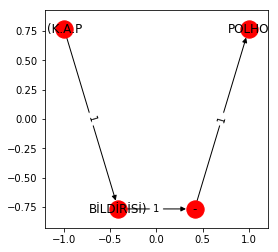

where: [2, 3, 4, 6, 7]

-----------------

t # 36
v 0 BİLDİRİSİ)
v 1 -
e 0 1 1

Support: 7


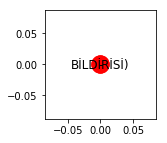

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 37
v 0 BİLDİRİSİ)
v 1 -
v 2 POLHO
e 0 1 1
e 1 2 1

Support: 5


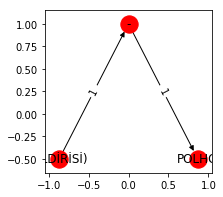

where: [2, 3, 4, 6, 7]

-----------------

t # 38
v 0 -
v 1 2016
e 0 1 1

Support: 7


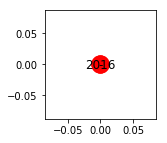

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 39
v 0 -
v 1 2016
v 2 POLHO
e 0 1 1
e 0 2 1

Support: 5


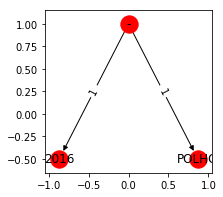

where: [2, 3, 4, 6, 7]

-----------------

t # 40
v 0 -
v 1 ***
e 0 1 1

Support: 7


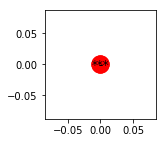

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 41
v 0 -
v 1 ***
v 2 BORSA
e 0 1 1
e 1 2 1

Support: 5


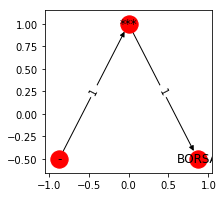

where: [0, 4, 5, 6, 7]

-----------------

t # 42
v 0 -
v 1 ***
v 2 BORSA
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


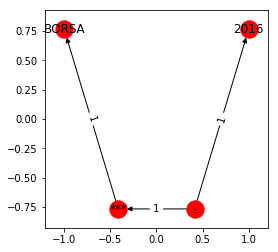

where: [0, 4, 5, 6, 7]

-----------------

t # 43
v 0 -
v 1 ***
v 2 KAMUYU
e 0 1 1
e 1 2 1

Support: 5


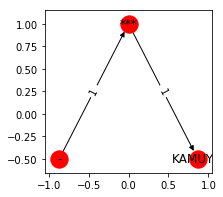

where: [0, 4, 5, 6, 7]

-----------------

t # 44
v 0 -
v 1 ***
v 2 KAMUYU
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


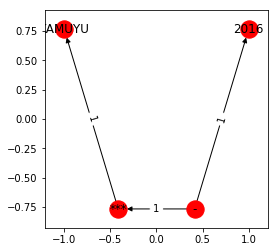

where: [0, 4, 5, 6, 7]

-----------------

t # 45
v 0 -
v 1 ***
v 2 2016
e 0 1 1
e 0 2 1

Support: 7


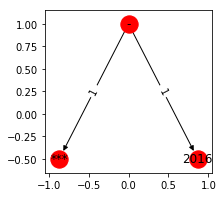

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 46
v 0 -
v 1 ***
v 2 2016
v 3 POLHO
e 0 1 1
e 0 2 1
e 0 3 1

Support: 5


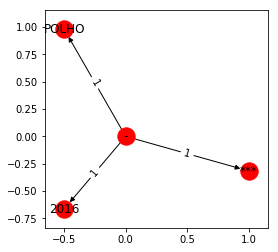

where: [2, 3, 4, 6, 7]

-----------------

t # 47
v 0 -
v 1 ***
v 2 POLİSAN
e 0 1 1
e 1 2 1

Support: 5


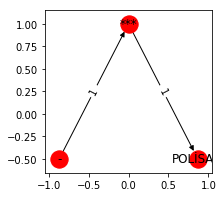

where: [2, 3, 4, 6, 7]

-----------------

t # 48
v 0 -
v 1 ***
v 2 POLİSAN
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


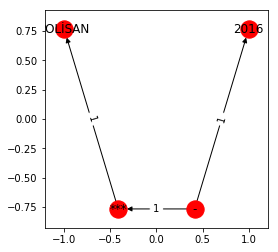

where: [2, 3, 4, 6, 7]

-----------------

t # 49
v 0 -
v 1 ***
v 2 POLİSAN
v 3 2016
v 4 POLHO
e 0 1 1
e 0 3 1
e 0 4 1
e 1 2 1

Support: 5


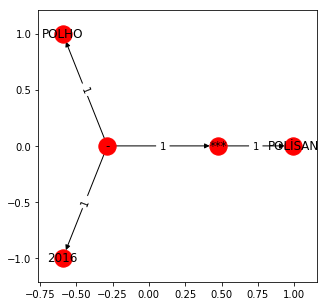

where: [2, 3, 4, 6, 7]

-----------------

t # 50
v 0 -
v 1 ***
v 2 POLİSAN
v 3 POLHO
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


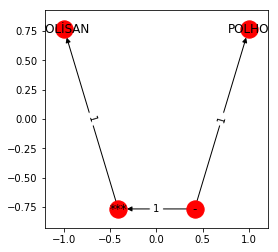

where: [2, 3, 4, 6, 7]

-----------------

t # 51
v 0 -
v 1 ***
v 2 POLHO
e 0 1 1
e 0 2 1

Support: 5


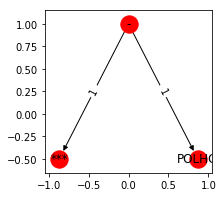

where: [2, 3, 4, 6, 7]

-----------------

t # 52
v 0 Ekim
v 1 2016
e 0 1 1

Support: 7


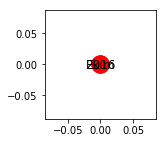

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 53
v 0 ***
v 1 BORSA
e 0 1 1

Support: 5


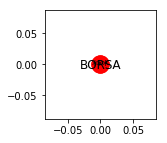

where: [0, 4, 5, 6, 7]

-----------------

t # 54
v 0 ***
v 1 BORSA
v 2 İSTANBUL
e 0 1 1
e 1 2 1

Support: 5


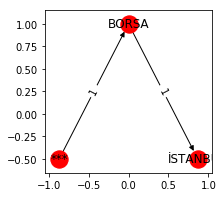

where: [0, 4, 5, 6, 7]

-----------------

t # 55
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


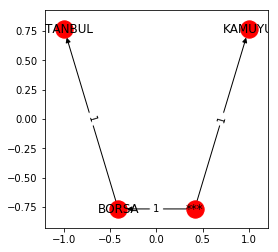

where: [0, 4, 5, 6, 7]

-----------------

t # 56
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
v 4 AYDINLATMA
e 0 1 1
e 0 3 1
e 1 2 1
e 3 4 1

Support: 5


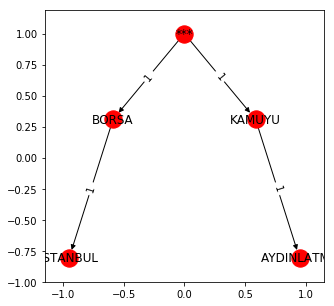

where: [0, 4, 5, 6, 7]

-----------------

t # 57
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
v 4 AYDINLATMA
v 5 PLATFORMU(...
e 0 1 1
e 0 3 1
e 1 2 1
e 3 4 1
e 4 5 1

Support: 5


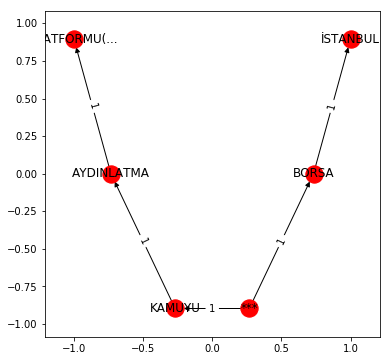

where: [0, 4, 5, 6, 7]

-----------------

t # 58
v 0 ***
v 1 BORSA
v 2 KAMUYU
e 0 1 1
e 0 2 1

Support: 5


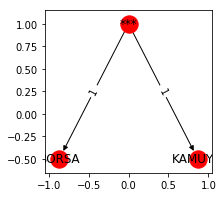

where: [0, 4, 5, 6, 7]

-----------------

t # 59
v 0 ***
v 1 BORSA
v 2 KAMUYU
v 3 AYDINLATMA
e 0 1 1
e 0 2 1
e 2 3 1

Support: 5


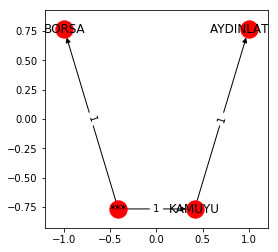

where: [0, 4, 5, 6, 7]

-----------------

t # 60
v 0 ***
v 1 BORSA
v 2 KAMUYU
v 3 AYDINLATMA
v 4 PLATFORMU(...
e 0 1 1
e 0 2 1
e 2 3 1
e 3 4 1

Support: 5


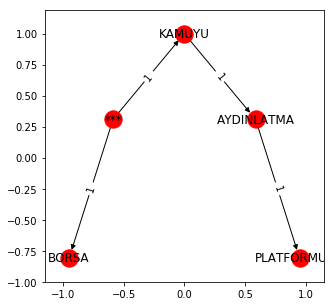

where: [0, 4, 5, 6, 7]

-----------------

t # 61
v 0 ***
v 1 KAMUYU
e 0 1 1

Support: 5


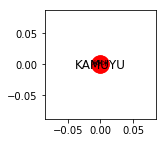

where: [0, 4, 5, 6, 7]

-----------------

t # 62
v 0 ***
v 1 KAMUYU
v 2 AYDINLATMA
e 0 1 1
e 1 2 1

Support: 5


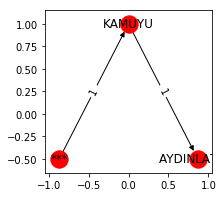

where: [0, 4, 5, 6, 7]

-----------------

t # 63
v 0 ***
v 1 KAMUYU
v 2 AYDINLATMA
v 3 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


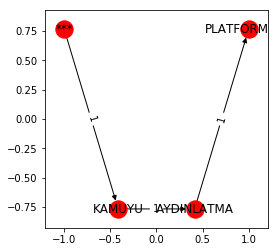

where: [0, 4, 5, 6, 7]

-----------------

t # 64
v 0 BORSA
v 1 İSTANBUL
e 0 1 1

Support: 5


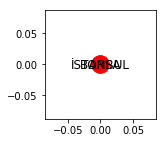

where: [0, 4, 5, 6, 7]

-----------------

t # 65
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


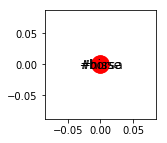

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 66
v 0 #hisse
v 1 ##ARCLK
e 0 1 1

Support: 5


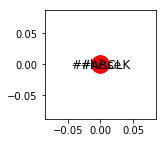

where: [0, 1, 2, 3, 7]

-----------------

t # 67
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


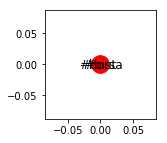

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 68
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 7


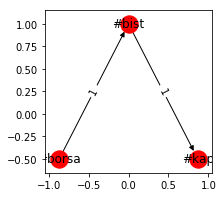

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 69
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


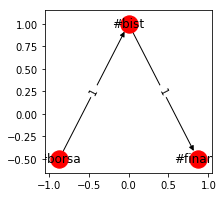

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 70
v 0 #bist
v 1 #kap
e 0 1 1

Support: 7


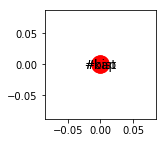

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 71
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


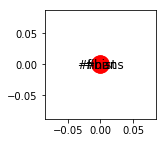

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 72
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


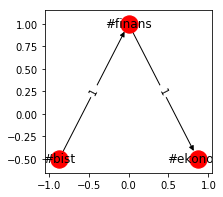

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 73
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


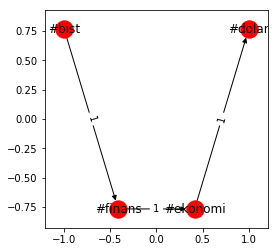

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 74
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


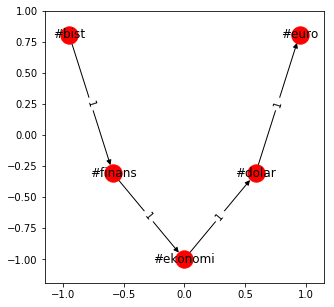

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 75
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
v 5 #kap
e 0 1 1
e 0 5 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 7


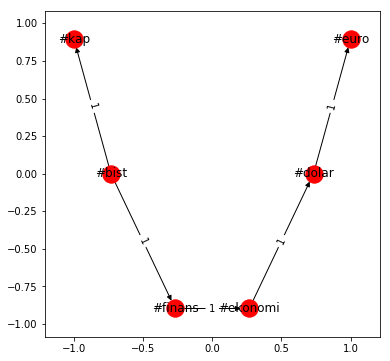

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 76
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #kap
e 0 1 1
e 0 4 1
e 1 2 1
e 2 3 1

Support: 7


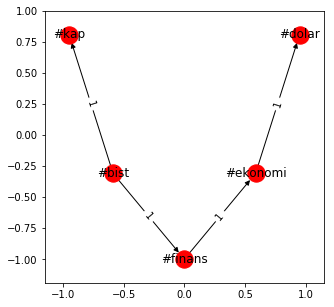

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 77
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #kap
e 0 1 1
e 0 3 1
e 1 2 1

Support: 7


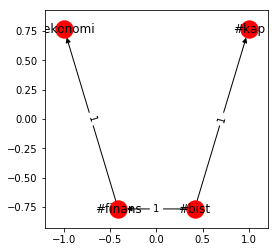

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 78
v 0 #bist
v 1 #finans
v 2 #kap
e 0 1 1
e 0 2 1

Support: 7


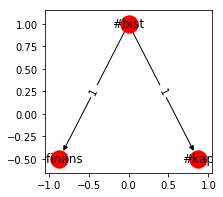

where: [0, 2, 3, 4, 5, 6, 7]

-----------------

t # 79
v 0 YATIRIM
v 1 OR...
e 0 1 1

Support: 5


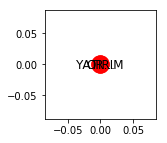

where: [0, 4, 5, 6, 7]

-----------------

t # 80
v 0 KAMUYU
v 1 AYDINLATMA
e 0 1 1

Support: 5


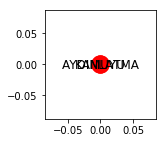

where: [0, 4, 5, 6, 7]

-----------------

t # 81
v 0 KAMUYU
v 1 AYDINLATMA
v 2 PLATFORMU(...
e 0 1 1
e 1 2 1

Support: 5


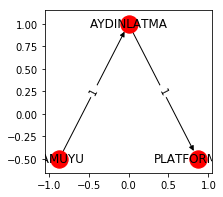

where: [0, 4, 5, 6, 7]

-----------------

t # 82
v 0 AYDINLATMA
v 1 PLATFORMU(...
e 0 1 1

Support: 5


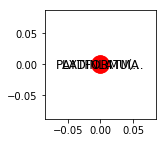

where: [0, 4, 5, 6, 7]

-----------------

t # 83
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


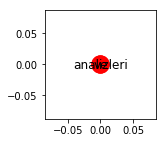

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 84
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


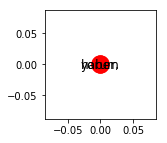

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 85
v 0 haber,
v 1 yorum
v 2 ÇİMENTO
e 0 1 1
e 0 2 1

Support: 5


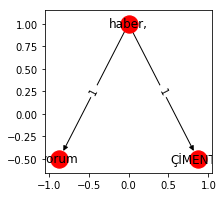

where: [1, 2, 5, 6, 7]

-----------------

t # 86
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 5


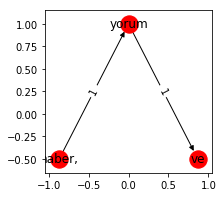

where: [2, 3, 4, 6, 7]

-----------------

t # 87
v 0 haber,
v 1 GMYO
e 0 1 1

Support: 5


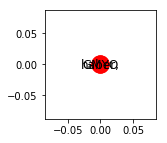

where: [0, 1, 2, 6, 7]

-----------------

t # 88
v 0 haber,
v 1 GMYO
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


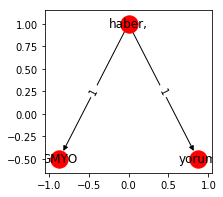

where: [0, 1, 2, 6, 7]

-----------------

t # 89
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 6


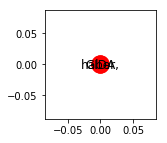

where: [0, 1, 2, 3, 4, 6]

-----------------

t # 90
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 6


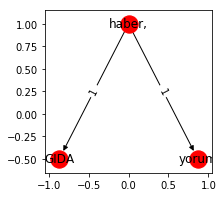

where: [0, 1, 2, 3, 4, 6]

-----------------

t # 91
v 0 analizleri
v 1 !
e 0 1 1

Support: 8


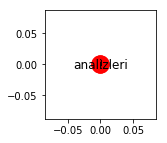

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 92
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


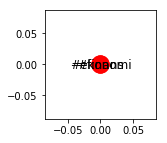

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 93
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


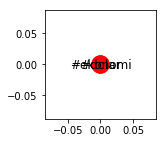

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 94
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


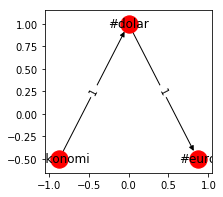

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 95
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


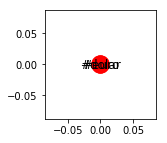

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 96
v 0 haber,
v 1 ÇİMENTO
e 0 1 1

Support: 5


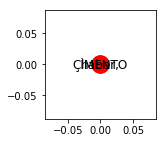

where: [1, 2, 5, 6, 7]

-----------------

t # 97
v 0 yorum
v 1 ve
e 0 1 1

Support: 5


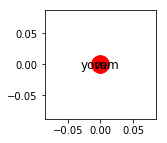

where: [2, 3, 4, 6, 7]

-----------------

t # 98
v 0 -
v 1 POLHO
e 0 1 1

Support: 5


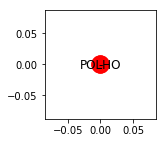

where: [2, 3, 4, 6, 7]

-----------------

t # 99
v 0 ***
v 1 POLİSAN
e 0 1 1

Support: 5


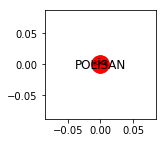

where: [2, 3, 4, 6, 7]

-----------------

t # 100
v 0 HOLDİNG
v 1 A.Ş.(
e 0 1 1

Support: 5


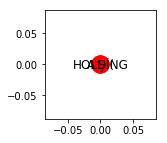

where: [2, 3, 4, 5, 7]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 10.2016
v 1 2016
e 0 1 1

Support: 8


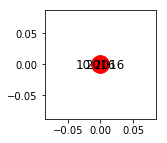

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 8


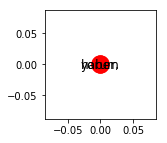

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 2
v 0 haber,
v 1 yorum
v 2 ve
e 0 1 1
e 1 2 1

Support: 6


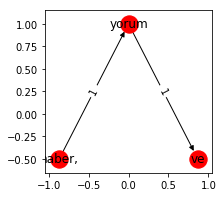

where: [0, 1, 2, 4, 5, 6]

-----------------

t # 3
v 0 haber,
v 1 GIDA
e 0 1 1

Support: 5


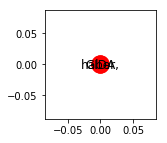

where: [0, 1, 2, 4, 6]

-----------------

t # 4
v 0 haber,
v 1 GIDA
v 2 yorum
e 0 1 1
e 0 2 1

Support: 5


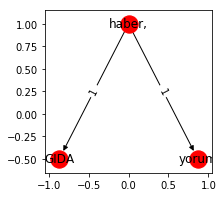

where: [0, 1, 2, 4, 6]

-----------------

t # 5
v 0 haber,
v 1 GIDA
v 2 yorum
v 3 ve
e 0 1 1
e 0 2 1
e 2 3 1

Support: 5


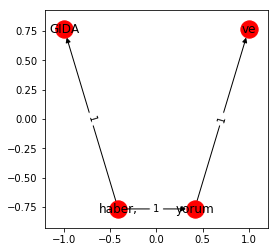

where: [0, 1, 2, 4, 6]

-----------------

t # 6
v 0 yorum
v 1 ve
e 0 1 1

Support: 6


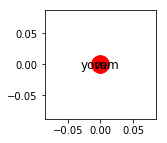

where: [0, 1, 2, 4, 5, 6]

-----------------

t # 7
v 0 ve
v 1 analizleri
e 0 1 1

Support: 8


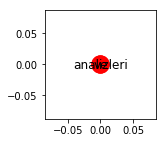

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 analizleri
v 1 !
e 0 1 1

Support: 8


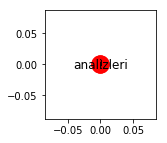

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 9
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


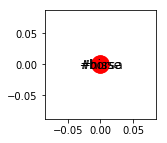

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 10
v 0 #hisse
v 1 ##POLHO
e 0 1 1

Support: 5


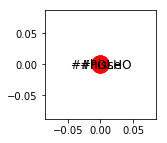

where: [0, 2, 4, 5, 7]

-----------------

t # 11
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


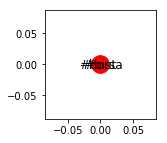

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 12
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 8


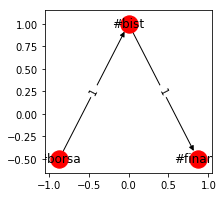

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 13
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 8


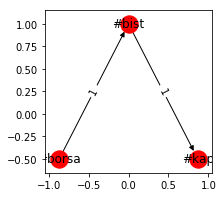

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 14
v 0 #bist
v 1 #finans
e 0 1 1

Support: 8


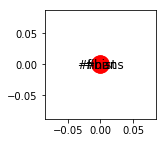

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 15
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 8


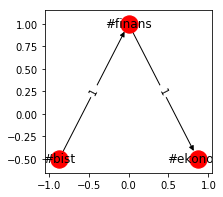

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 16
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


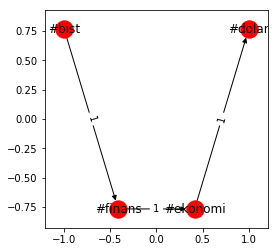

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


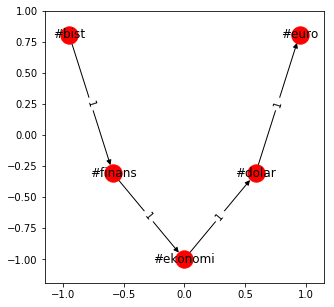

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 18
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
v 5 #kap
e 0 1 1
e 0 5 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 8


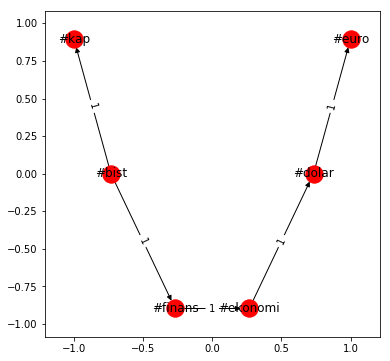

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 19
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #kap
e 0 1 1
e 0 4 1
e 1 2 1
e 2 3 1

Support: 8


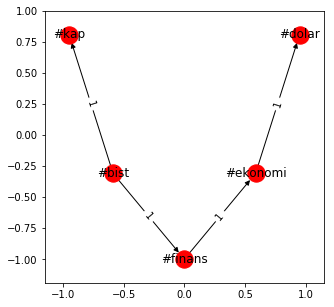

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 20
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #kap
e 0 1 1
e 0 3 1
e 1 2 1

Support: 8


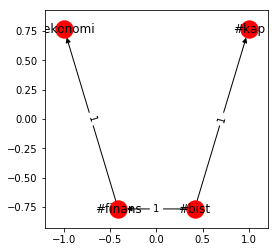

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 21
v 0 #bist
v 1 #finans
v 2 #kap
e 0 1 1
e 0 2 1

Support: 8


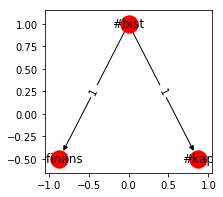

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 #bist
v 1 #kap
e 0 1 1

Support: 8


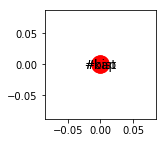

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 23
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 8


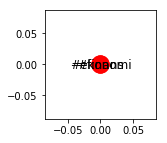

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 24
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 8


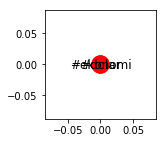

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 25
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 8


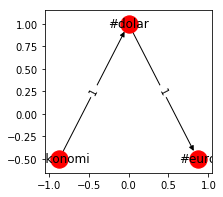

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 26
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 8


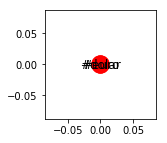

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 27
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 8


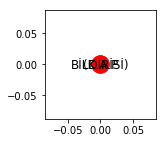

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 28
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
e 0 1 1
e 1 2 1

Support: 8


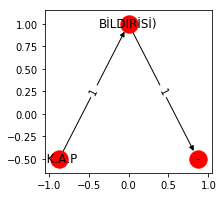

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 29
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


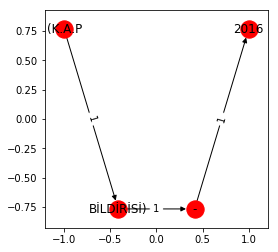

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 30
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
v 4 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 6


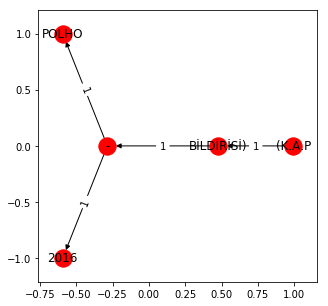

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 31
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
v 4 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


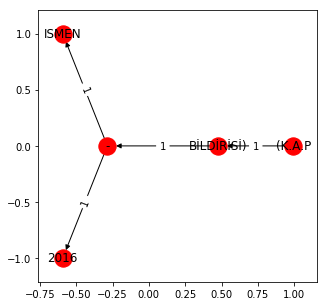

where: [3, 4, 5, 6, 7]

-----------------

t # 32
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 POLHO
e 0 1 1
e 1 2 1
e 2 3 1

Support: 6


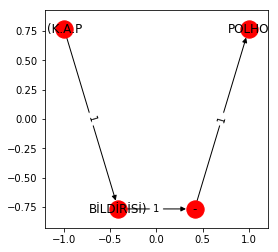

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 33
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
e 0 1 1
e 1 2 1
e 2 3 1

Support: 8


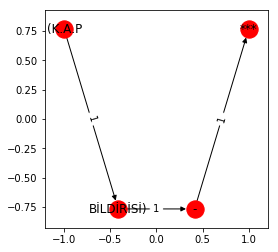

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 34
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 6


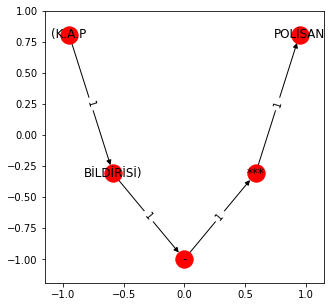

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 35
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


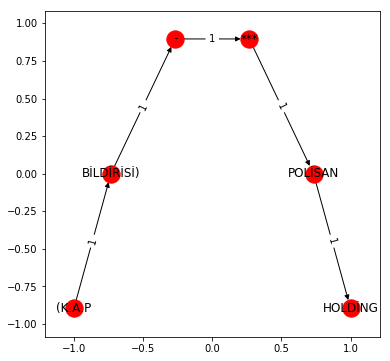

where: [0, 1, 2, 5, 7]

-----------------

t # 36
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 A.Ş.(
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


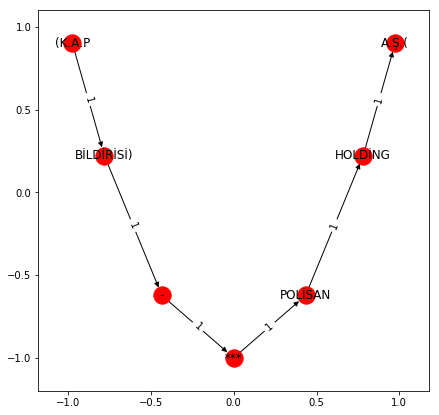

where: [0, 1, 2, 5, 7]

-----------------

t # 37
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 A.Ş.(
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


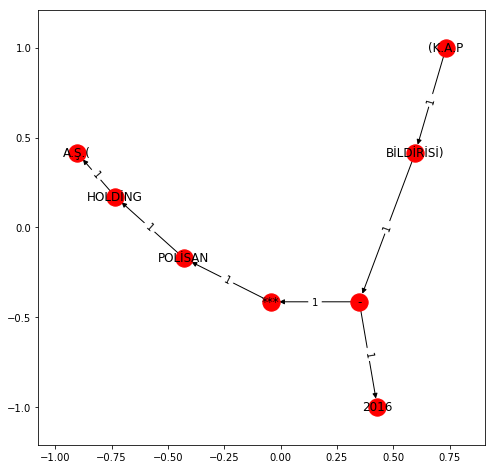

where: [0, 1, 2, 5, 7]

-----------------

t # 38
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 A.Ş.(
v 7 2016
v 8 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 2 8 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


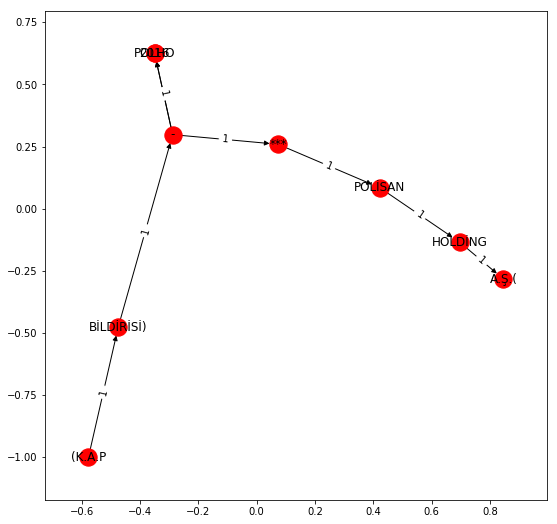

where: [0, 1, 2, 5, 7]

-----------------

t # 39
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 A.Ş.(
v 7 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


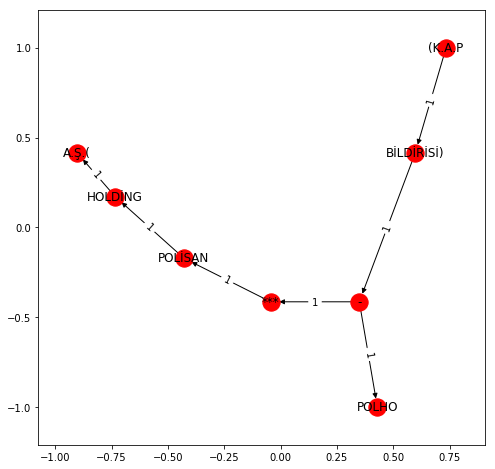

where: [0, 1, 2, 5, 7]

-----------------

t # 40
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


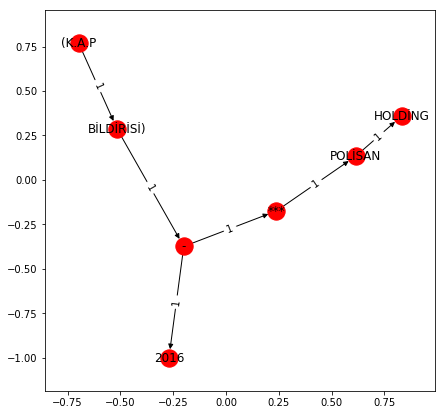

where: [0, 1, 2, 5, 7]

-----------------

t # 41
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 2016
v 7 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 2 7 1
e 3 4 1
e 4 5 1

Support: 5


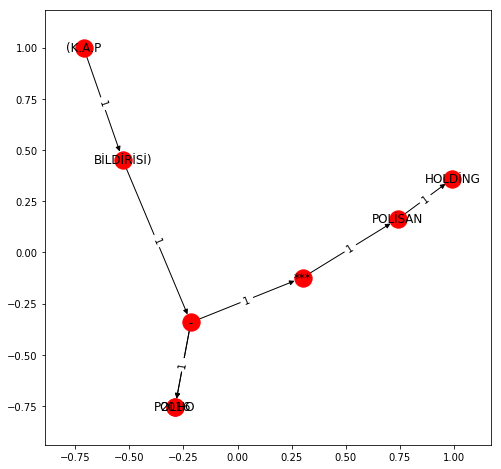

where: [0, 1, 2, 5, 7]

-----------------

t # 42
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 HOLDİNG
v 6 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


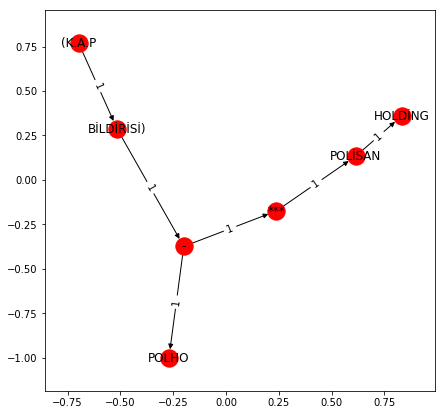

where: [0, 1, 2, 5, 7]

-----------------

t # 43
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 6


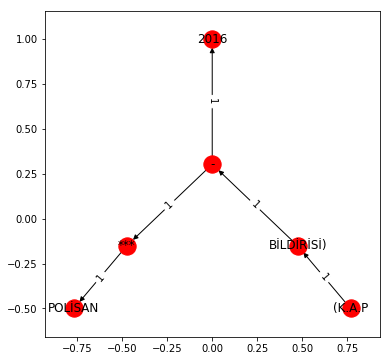

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 44
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 2016
v 6 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 2 6 1
e 3 4 1

Support: 6


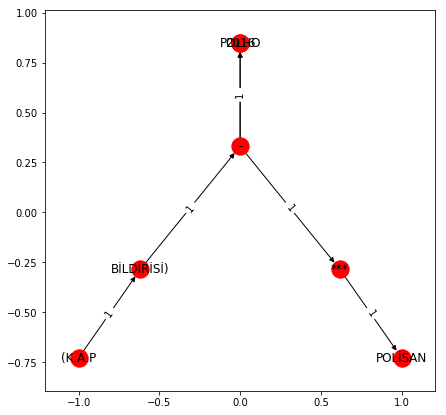

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 45
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLİSAN
v 5 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 6


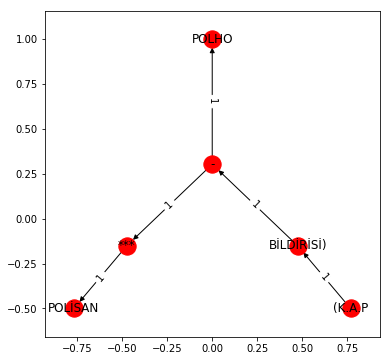

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 46
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 8


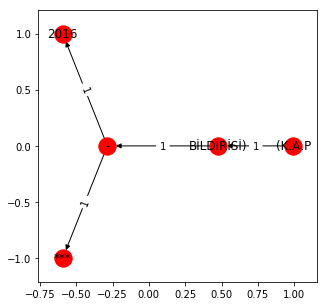

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 47
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
v 5 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1
e 2 5 1

Support: 6


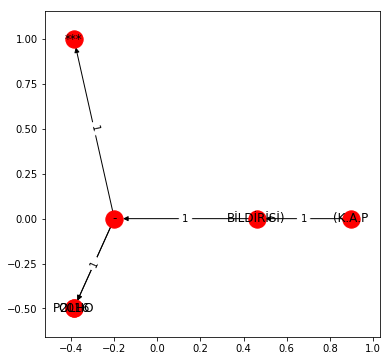

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 48
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
v 5 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1
e 2 5 1

Support: 5


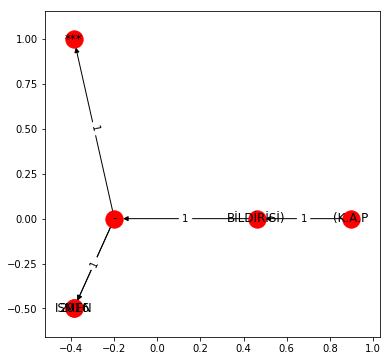

where: [3, 4, 5, 6, 7]

-----------------

t # 49
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 POLHO
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 6


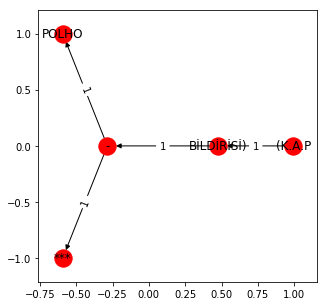

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 50
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


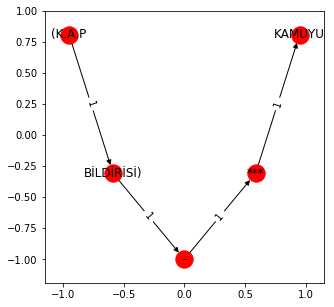

where: [2, 3, 4, 5, 7]

-----------------

t # 51
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


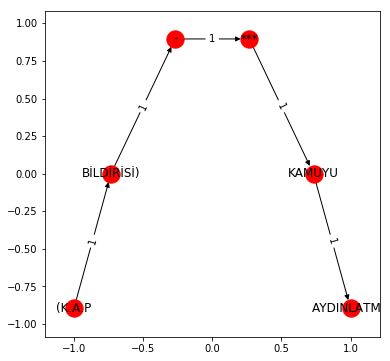

where: [2, 3, 4, 5, 7]

-----------------

t # 52
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


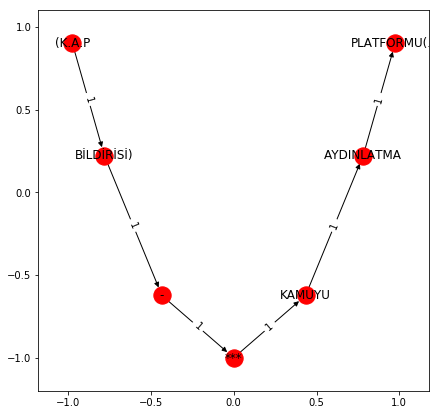

where: [2, 3, 4, 5, 7]

-----------------

t # 53
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 PLATFORMU(...
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


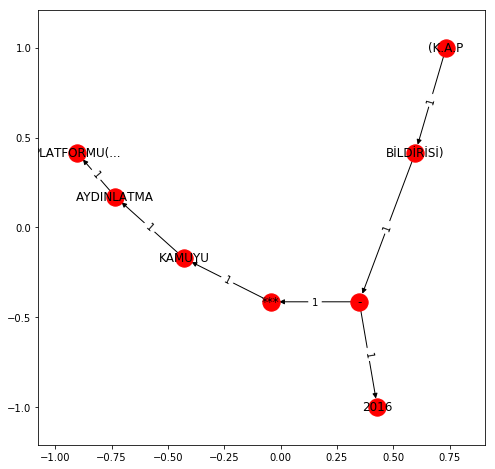

where: [2, 3, 4, 5, 7]

-----------------

t # 54
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


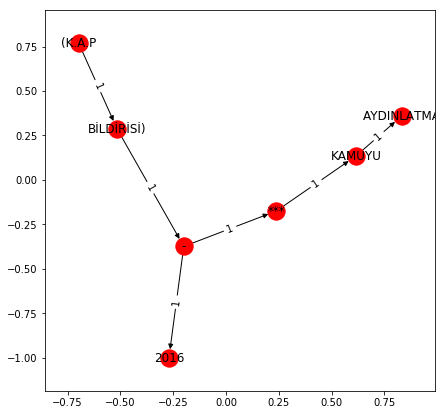

where: [2, 3, 4, 5, 7]

-----------------

t # 55
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


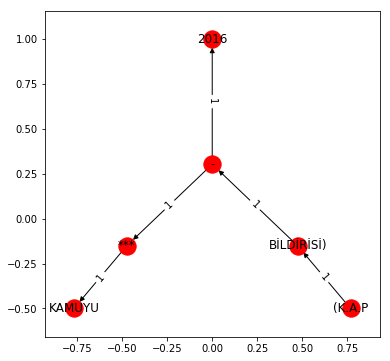

where: [2, 3, 4, 5, 7]

-----------------

t # 56
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


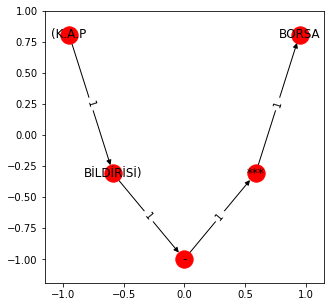

where: [2, 3, 4, 5, 7]

-----------------

t # 57
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


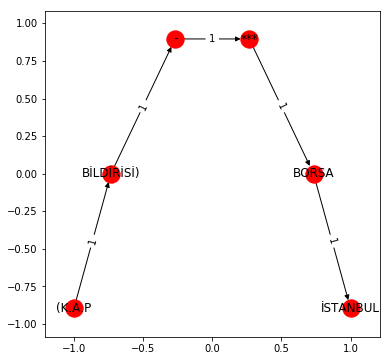

where: [2, 3, 4, 5, 7]

-----------------

t # 58
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1

Support: 5


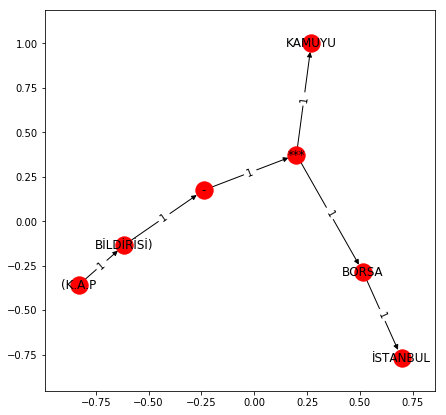

where: [2, 3, 4, 5, 7]

-----------------

t # 59
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1

Support: 5


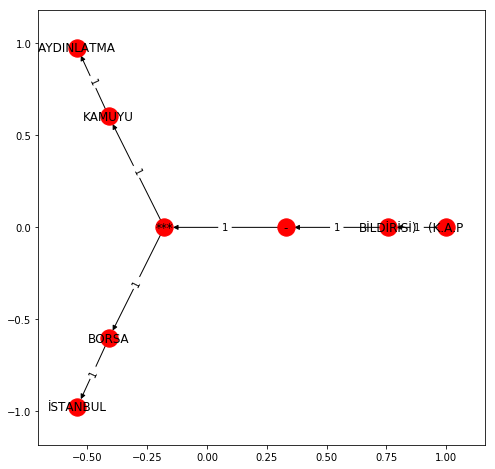

where: [2, 3, 4, 5, 7]

-----------------

t # 60
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1
e 7 8 1

Support: 5


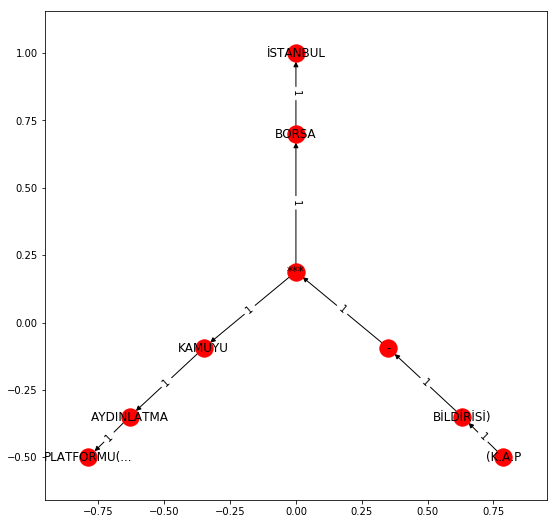

where: [2, 3, 4, 5, 7]

-----------------

t # 61
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 PLATFORMU(...
v 9 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 9 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1
e 7 8 1

Support: 5


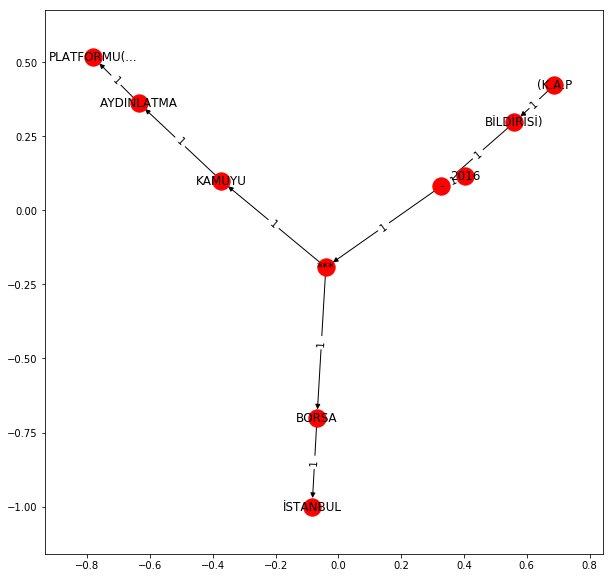

where: [2, 3, 4, 5, 7]

-----------------

t # 62
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 8 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1

Support: 5


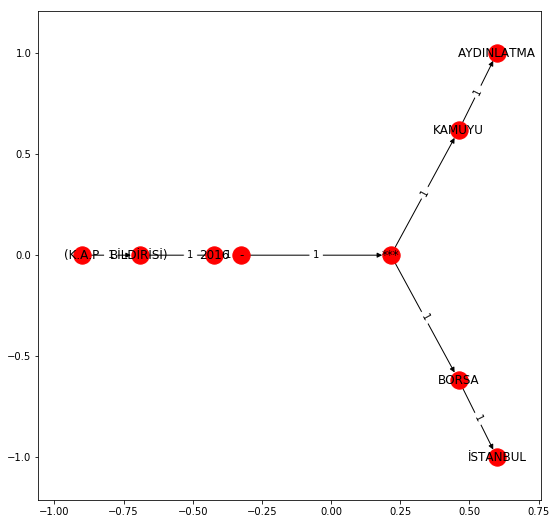

where: [2, 3, 4, 5, 7]

-----------------

t # 63
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 3 6 1
e 4 5 1

Support: 5


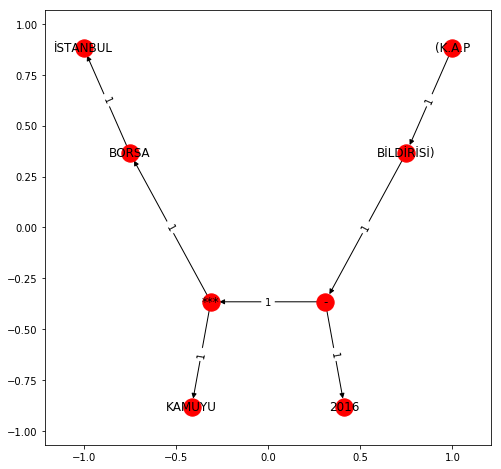

where: [2, 3, 4, 5, 7]

-----------------

t # 64
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


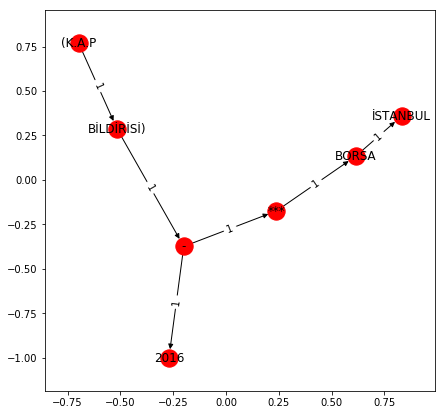

where: [2, 3, 4, 5, 7]

-----------------

t # 65
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1

Support: 5


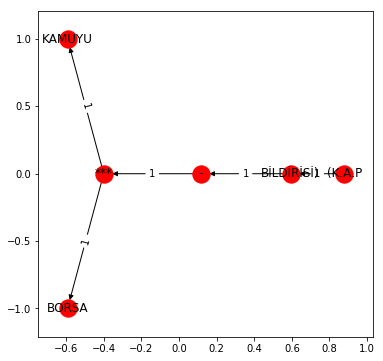

where: [2, 3, 4, 5, 7]

-----------------

t # 66
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1
e 5 6 1

Support: 5


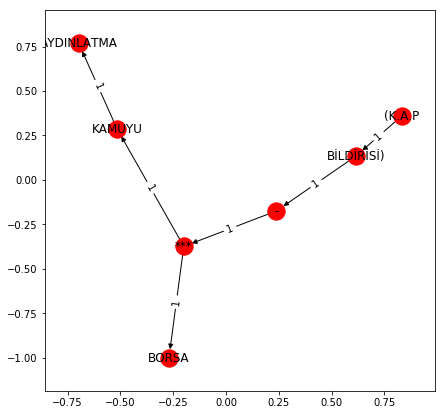

where: [2, 3, 4, 5, 7]

-----------------

t # 67
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1
e 5 6 1
e 6 7 1

Support: 5


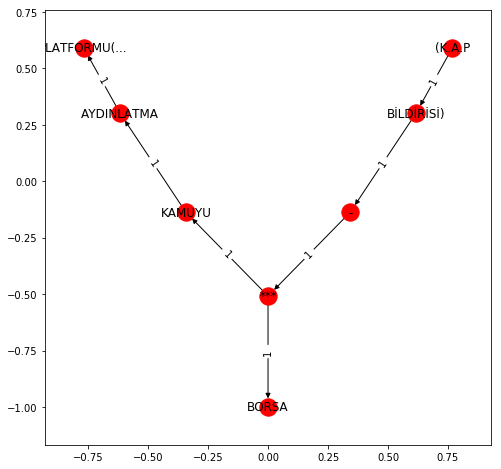

where: [2, 3, 4, 5, 7]

-----------------

t # 68
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 PLATFORMU(...
v 8 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 8 1
e 3 4 1
e 3 5 1
e 5 6 1
e 6 7 1

Support: 5


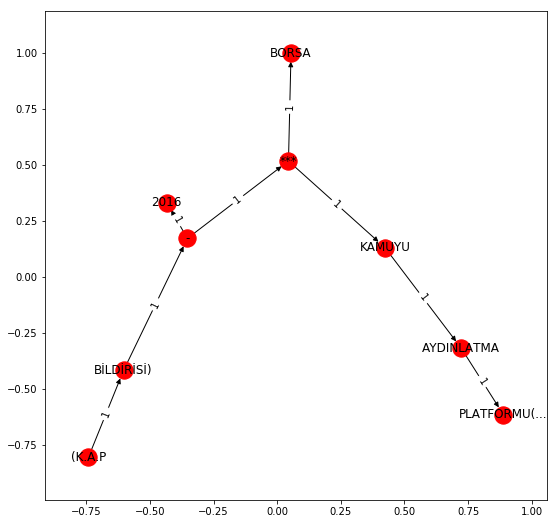

where: [2, 3, 4, 5, 7]

-----------------

t # 69
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 3 5 1
e 5 6 1

Support: 5


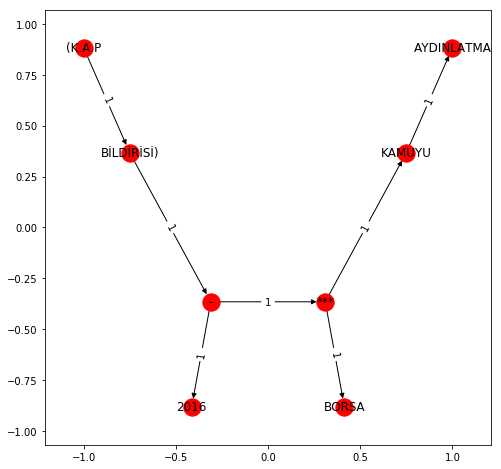

where: [2, 3, 4, 5, 7]

-----------------

t # 70
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


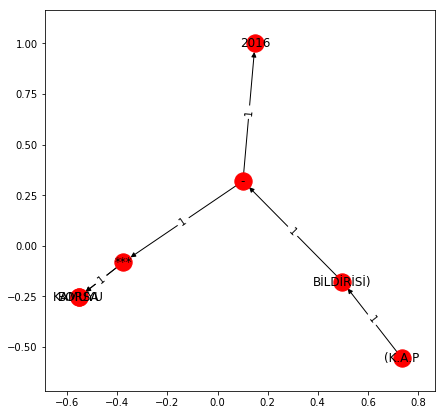

where: [2, 3, 4, 5, 7]

-----------------

t # 71
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


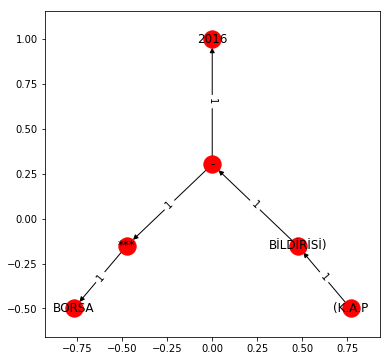

where: [2, 3, 4, 5, 7]

-----------------

t # 72
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


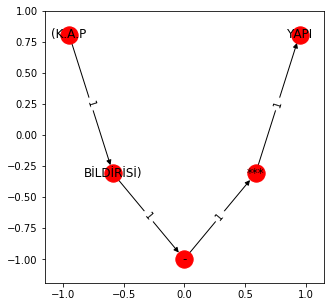

where: [3, 4, 5, 6, 7]

-----------------

t # 73
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1

Support: 5


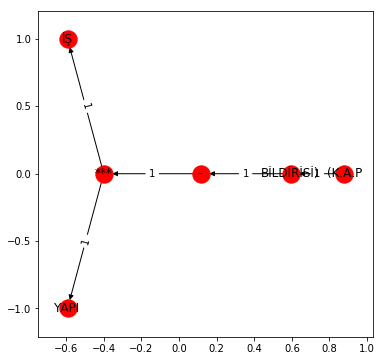

where: [3, 4, 5, 6, 7]

-----------------

t # 74
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


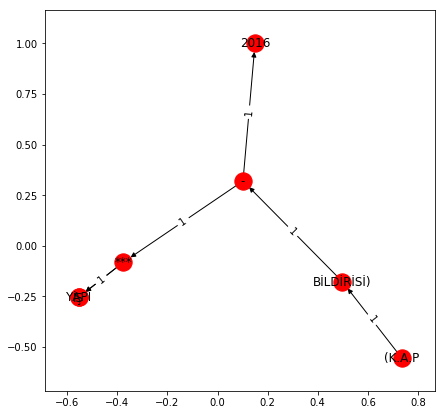

where: [3, 4, 5, 6, 7]

-----------------

t # 75
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
v 6 2016
v 7 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 2 7 1
e 3 4 1
e 3 5 1

Support: 5


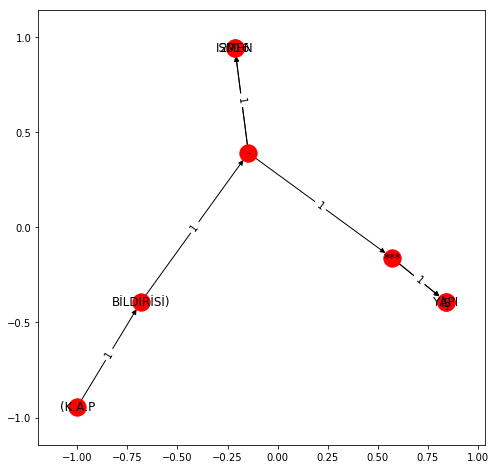

where: [3, 4, 5, 6, 7]

-----------------

t # 76
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
v 6 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


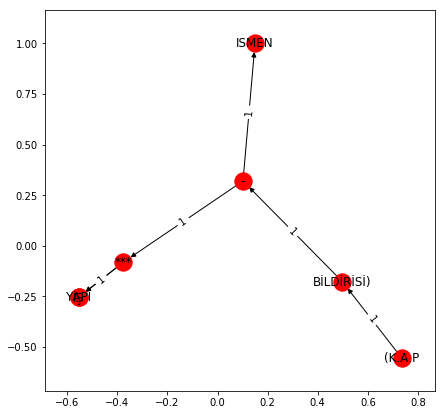

where: [3, 4, 5, 6, 7]

-----------------

t # 77
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


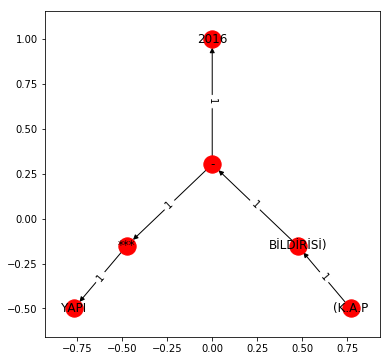

where: [3, 4, 5, 6, 7]

-----------------

t # 78
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 2016
v 6 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 2 6 1
e 3 4 1

Support: 5


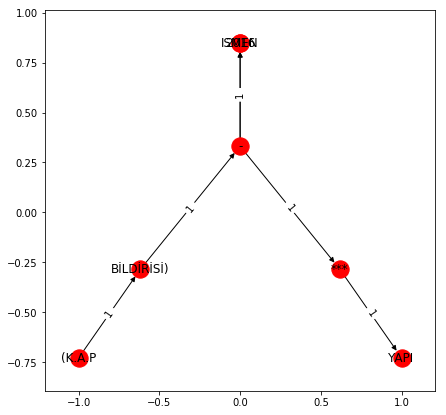

where: [3, 4, 5, 6, 7]

-----------------

t # 79
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


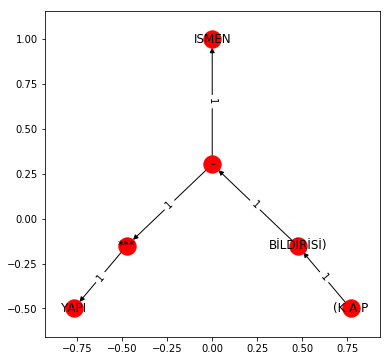

where: [3, 4, 5, 6, 7]

-----------------

t # 80
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


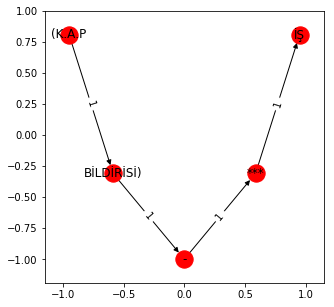

where: [3, 4, 5, 6, 7]

-----------------

t # 81
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


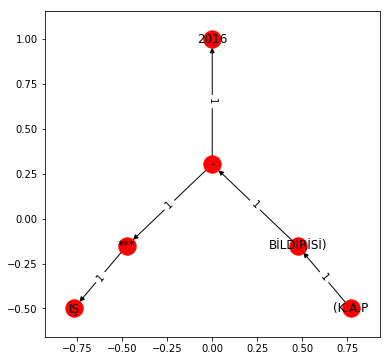

where: [3, 4, 5, 6, 7]

-----------------

t # 82
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
v 5 2016
v 6 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 2 6 1
e 3 4 1

Support: 5


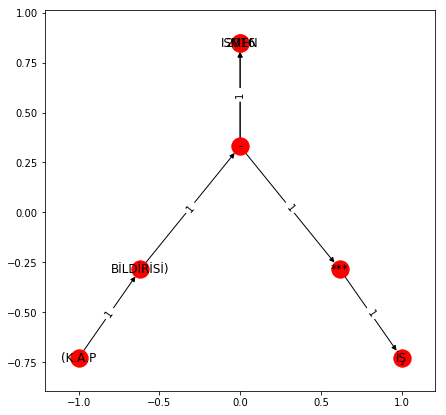

where: [3, 4, 5, 6, 7]

-----------------

t # 83
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
v 5 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


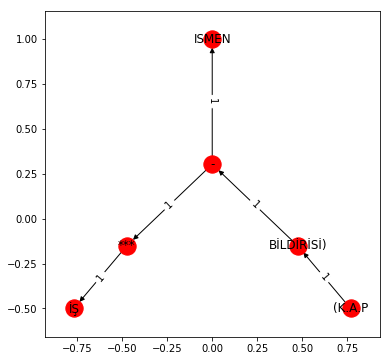

where: [3, 4, 5, 6, 7]

-----------------

t # 84
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


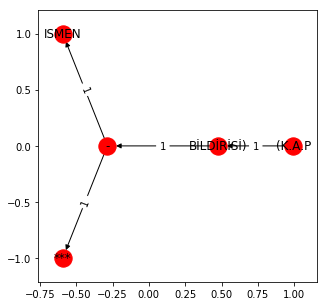

where: [3, 4, 5, 6, 7]

-----------------

t # 85
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


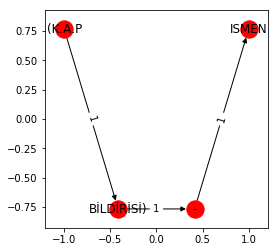

where: [3, 4, 5, 6, 7]

-----------------

t # 86
v 0 BİLDİRİSİ)
v 1 -
e 0 1 1

Support: 8


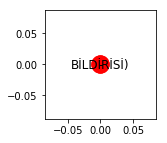

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 87
v 0 BİLDİRİSİ)
v 1 -
v 2 POLHO
e 0 1 1
e 1 2 1

Support: 6


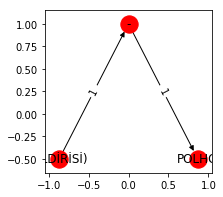

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 88
v 0 BİLDİRİSİ)
v 1 -
v 2 ISMEN
e 0 1 1
e 1 2 1

Support: 5


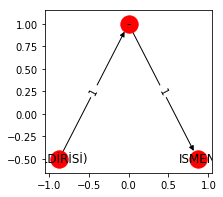

where: [3, 4, 5, 6, 7]

-----------------

t # 89
v 0 -
v 1 2016
e 0 1 1

Support: 8


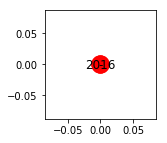

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 90
v 0 -
v 1 2016
v 2 POLHO
e 0 1 1
e 0 2 1

Support: 6


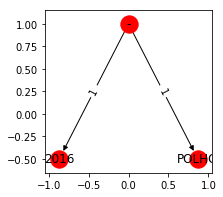

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 91
v 0 -
v 1 2016
v 2 ISMEN
e 0 1 1
e 0 2 1

Support: 5


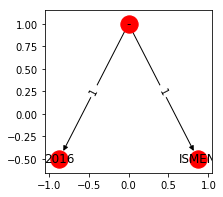

where: [3, 4, 5, 6, 7]

-----------------

t # 92
v 0 -
v 1 POLHO
e 0 1 1

Support: 6


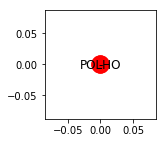

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 93
v 0 -
v 1 ***
e 0 1 1

Support: 8


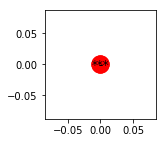

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 94
v 0 -
v 1 ***
v 2 POLİSAN
e 0 1 1
e 1 2 1

Support: 6


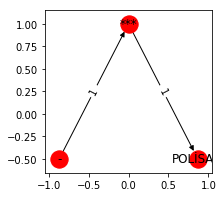

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 95
v 0 -
v 1 ***
v 2 POLİSAN
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 6


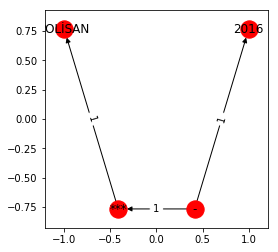

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 96
v 0 -
v 1 ***
v 2 POLİSAN
v 3 2016
v 4 POLHO
e 0 1 1
e 0 3 1
e 0 4 1
e 1 2 1

Support: 6


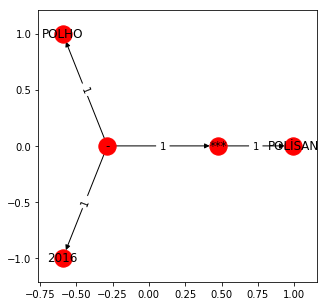

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 97
v 0 -
v 1 ***
v 2 POLİSAN
v 3 POLHO
e 0 1 1
e 0 3 1
e 1 2 1

Support: 6


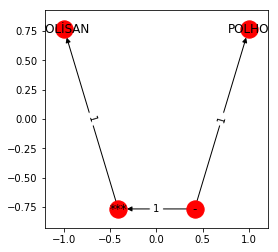

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 98
v 0 -
v 1 ***
v 2 2016
e 0 1 1
e 0 2 1

Support: 8


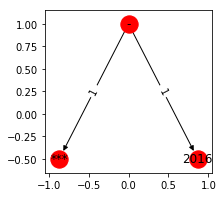

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 99
v 0 -
v 1 ***
v 2 2016
v 3 POLHO
e 0 1 1
e 0 2 1
e 0 3 1

Support: 6


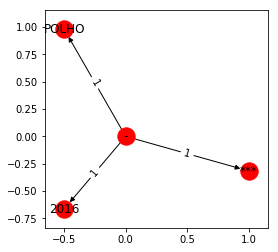

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 100
v 0 -
v 1 ***
v 2 2016
v 3 ISMEN
e 0 1 1
e 0 2 1
e 0 3 1

Support: 5


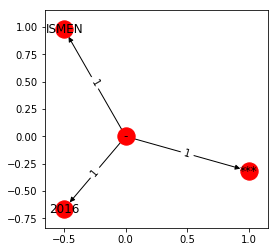

where: [3, 4, 5, 6, 7]

-----------------

t # 101
v 0 -
v 1 ***
v 2 POLHO
e 0 1 1
e 0 2 1

Support: 6


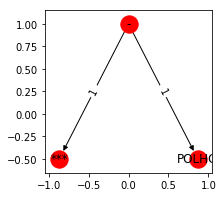

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 102
v 0 -
v 1 ***
v 2 KAMUYU
e 0 1 1
e 1 2 1

Support: 5


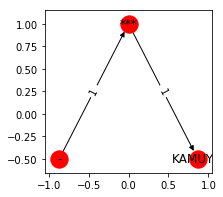

where: [2, 3, 4, 5, 7]

-----------------

t # 103
v 0 -
v 1 ***
v 2 KAMUYU
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


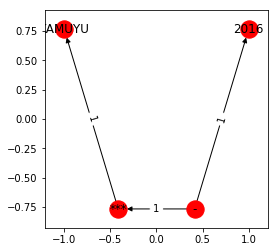

where: [2, 3, 4, 5, 7]

-----------------

t # 104
v 0 -
v 1 ***
v 2 BORSA
e 0 1 1
e 1 2 1

Support: 5


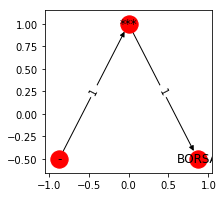

where: [2, 3, 4, 5, 7]

-----------------

t # 105
v 0 -
v 1 ***
v 2 BORSA
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


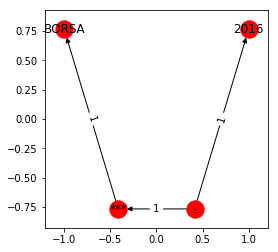

where: [2, 3, 4, 5, 7]

-----------------

t # 106
v 0 -
v 1 ***
v 2 YAPI
e 0 1 1
e 1 2 1

Support: 5


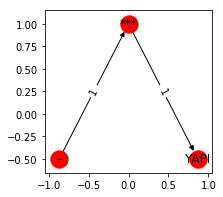

where: [3, 4, 5, 6, 7]

-----------------

t # 107
v 0 -
v 1 ***
v 2 YAPI
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


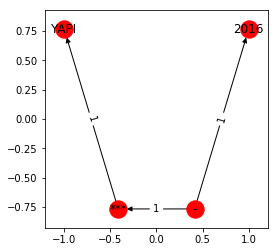

where: [3, 4, 5, 6, 7]

-----------------

t # 108
v 0 -
v 1 ***
v 2 YAPI
v 3 2016
v 4 ISMEN
e 0 1 1
e 0 3 1
e 0 4 1
e 1 2 1

Support: 5


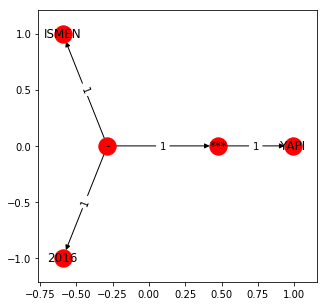

where: [3, 4, 5, 6, 7]

-----------------

t # 109
v 0 -
v 1 ***
v 2 YAPI
v 3 ISMEN
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


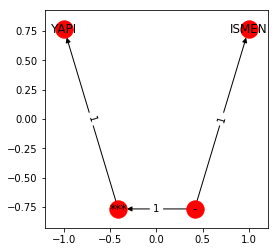

where: [3, 4, 5, 6, 7]

-----------------

t # 110
v 0 -
v 1 ***
v 2 İŞ
e 0 1 1
e 1 2 1

Support: 5


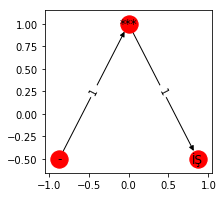

where: [3, 4, 5, 6, 7]

-----------------

t # 111
v 0 -
v 1 ***
v 2 İŞ
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


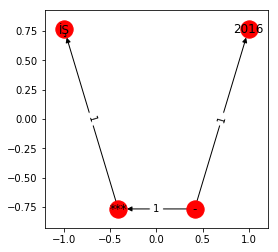

where: [3, 4, 5, 6, 7]

-----------------

t # 112
v 0 -
v 1 ***
v 2 İŞ
v 3 2016
v 4 ISMEN
e 0 1 1
e 0 3 1
e 0 4 1
e 1 2 1

Support: 5


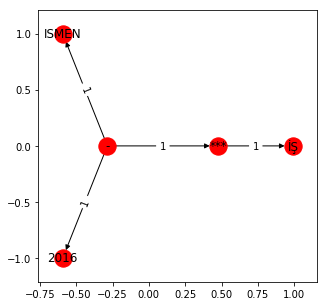

where: [3, 4, 5, 6, 7]

-----------------

t # 113
v 0 -
v 1 ***
v 2 İŞ
v 3 ISMEN
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


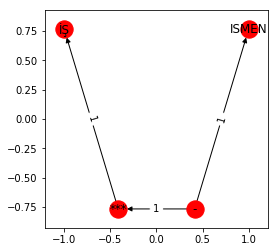

where: [3, 4, 5, 6, 7]

-----------------

t # 114
v 0 -
v 1 ***
v 2 ISMEN
e 0 1 1
e 0 2 1

Support: 5


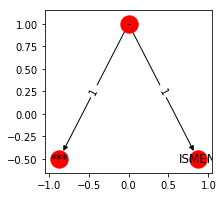

where: [3, 4, 5, 6, 7]

-----------------

t # 115
v 0 Ekim
v 1 2016
e 0 1 1

Support: 8


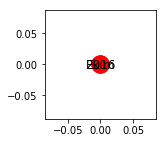

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 116
v 0 ***
v 1 POLİSAN
e 0 1 1

Support: 6


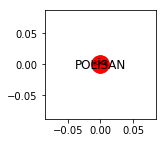

where: [0, 1, 2, 4, 5, 7]

-----------------

t # 117
v 0 ***
v 1 POLİSAN
v 2 HOLDİNG
e 0 1 1
e 1 2 1

Support: 5


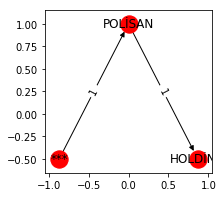

where: [0, 1, 2, 5, 7]

-----------------

t # 118
v 0 ***
v 1 POLİSAN
v 2 HOLDİNG
v 3 A.Ş.(
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


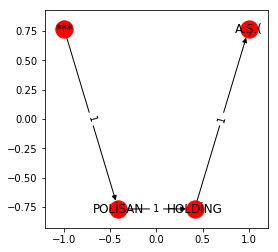

where: [0, 1, 2, 5, 7]

-----------------

t # 119
v 0 POLİSAN
v 1 HOLDİNG
e 0 1 1

Support: 5


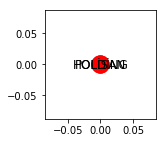

where: [0, 1, 2, 5, 7]

-----------------

t # 120
v 0 HOLDİNG
v 1 A.Ş.(
e 0 1 1

Support: 6


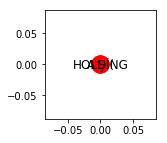

where: [0, 1, 2, 3, 5, 7]

-----------------

t # 121
v 0 RT
v 1 @HistoryInPix:
e 0 1 1

Support: 5


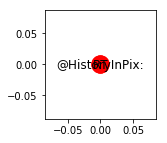

where: [1, 2, 4, 6, 7]

-----------------

t # 122
v 0 ***
v 1 KAMUYU
e 0 1 1

Support: 5


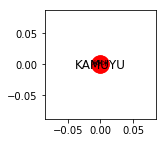

where: [2, 3, 4, 5, 7]

-----------------

t # 123
v 0 ***
v 1 KAMUYU
v 2 AYDINLATMA
e 0 1 1
e 1 2 1

Support: 5


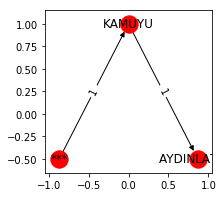

where: [2, 3, 4, 5, 7]

-----------------

t # 124
v 0 ***
v 1 KAMUYU
v 2 AYDINLATMA
v 3 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


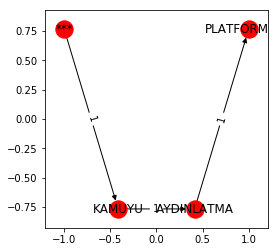

where: [2, 3, 4, 5, 7]

-----------------

t # 125
v 0 ***
v 1 BORSA
e 0 1 1

Support: 5


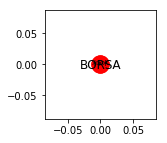

where: [2, 3, 4, 5, 7]

-----------------

t # 126
v 0 ***
v 1 BORSA
v 2 İSTANBUL
e 0 1 1
e 1 2 1

Support: 5


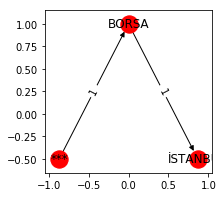

where: [2, 3, 4, 5, 7]

-----------------

t # 127
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


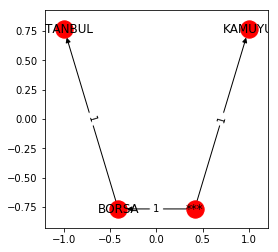

where: [2, 3, 4, 5, 7]

-----------------

t # 128
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
v 4 AYDINLATMA
e 0 1 1
e 0 3 1
e 1 2 1
e 3 4 1

Support: 5


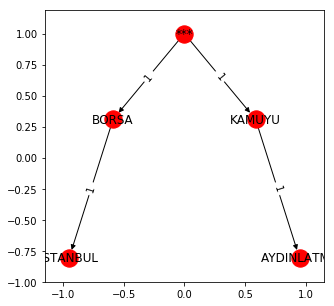

where: [2, 3, 4, 5, 7]

-----------------

t # 129
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
v 4 AYDINLATMA
v 5 PLATFORMU(...
e 0 1 1
e 0 3 1
e 1 2 1
e 3 4 1
e 4 5 1

Support: 5


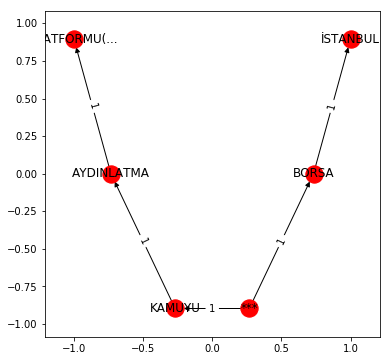

where: [2, 3, 4, 5, 7]

-----------------

t # 130
v 0 ***
v 1 BORSA
v 2 KAMUYU
e 0 1 1
e 0 2 1

Support: 5


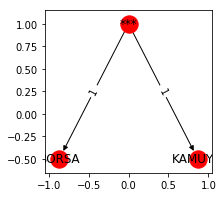

where: [2, 3, 4, 5, 7]

-----------------

t # 131
v 0 ***
v 1 BORSA
v 2 KAMUYU
v 3 AYDINLATMA
e 0 1 1
e 0 2 1
e 2 3 1

Support: 5


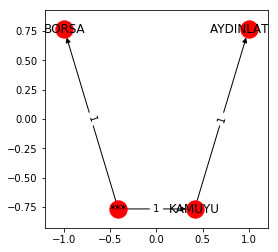

where: [2, 3, 4, 5, 7]

-----------------

t # 132
v 0 ***
v 1 BORSA
v 2 KAMUYU
v 3 AYDINLATMA
v 4 PLATFORMU(...
e 0 1 1
e 0 2 1
e 2 3 1
e 3 4 1

Support: 5


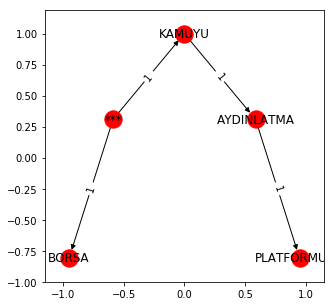

where: [2, 3, 4, 5, 7]

-----------------

t # 133
v 0 KAMUYU
v 1 AYDINLATMA
e 0 1 1

Support: 5


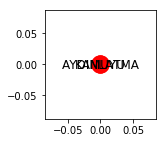

where: [2, 3, 4, 5, 7]

-----------------

t # 134
v 0 KAMUYU
v 1 AYDINLATMA
v 2 PLATFORMU(...
e 0 1 1
e 1 2 1

Support: 5


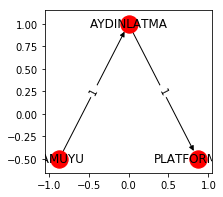

where: [2, 3, 4, 5, 7]

-----------------

t # 135
v 0 AYDINLATMA
v 1 PLATFORMU(...
e 0 1 1

Support: 5


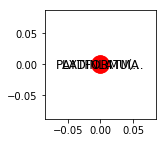

where: [2, 3, 4, 5, 7]

-----------------

t # 136
v 0 YATIRIM
v 1 OR...
e 0 1 1

Support: 5


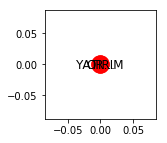

where: [2, 3, 4, 5, 6]

-----------------

t # 137
v 0 BORSA
v 1 İSTANBUL
e 0 1 1

Support: 5


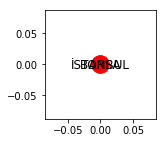

where: [2, 3, 4, 5, 7]

-----------------

t # 138
v 0 -
v 1 ISMEN
e 0 1 1

Support: 5


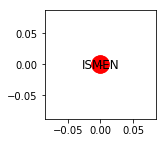

where: [3, 4, 5, 6, 7]

-----------------

t # 139
v 0 ***
v 1 YAPI
e 0 1 1

Support: 5


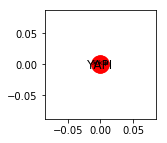

where: [3, 4, 5, 6, 7]

-----------------

t # 140
v 0 ***
v 1 YAPI
v 2 İŞ
e 0 1 1
e 0 2 1

Support: 5


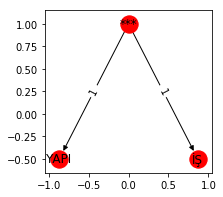

where: [3, 4, 5, 6, 7]

-----------------

t # 141
v 0 ***
v 1 İŞ
e 0 1 1

Support: 5


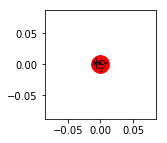

where: [3, 4, 5, 6, 7]

-----------------

t # 142
v 0 #hisse
v 1 ##ISMEN
e 0 1 1

Support: 5


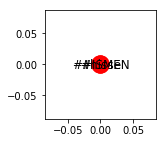

where: [3, 4, 5, 6, 7]

-----------------

t # 143
v 0 YATIRIM
v 1 MENKUL
e 0 1 1

Support: 5


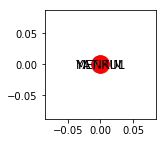

where: [3, 4, 5, 6, 7]

-----------------

t # 144
v 0 MENKUL
v 1 DEĞERLER
e 0 1 1

Support: 5


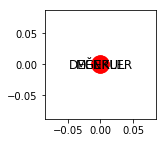

where: [3, 4, 5, 6, 7]

-----------------

t # 145
v 0 DEĞERLER
v 1 A...
e 0 1 1

Support: 5


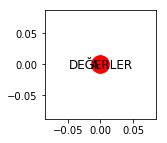

where: [3, 4, 5, 6, 7]

-----------------

t # 146
v 0 A...
v 1 ##ISMEN
e 0 1 1

Support: 5


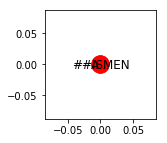

where: [3, 4, 5, 6, 7]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 10.2016
v 1 2016
e 0 1 1

Support: 6


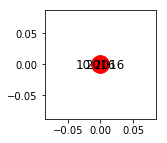

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 1
v 0 haber,
v 1 yorum
e 0 1 1

Support: 7


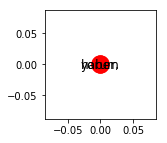

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 2
v 0 ve
v 1 analizleri
e 0 1 1

Support: 7


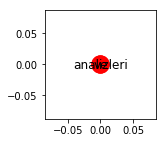

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 3
v 0 analizleri
v 1 !
e 0 1 1

Support: 7


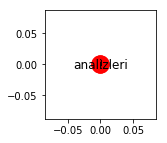

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 4
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 8


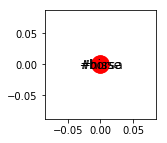

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 5
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 8


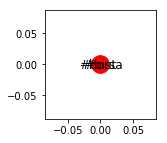

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 6
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 7


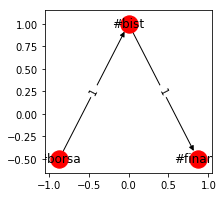

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 7
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 8


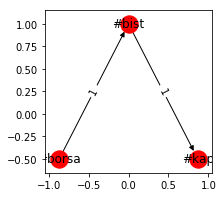

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 8
v 0 #bist
v 1 #finans
e 0 1 1

Support: 7


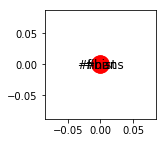

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 9
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 7


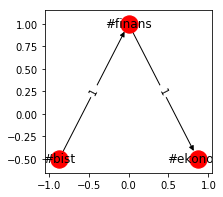

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 10
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


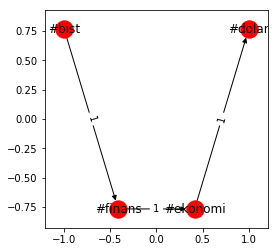

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 11
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 7


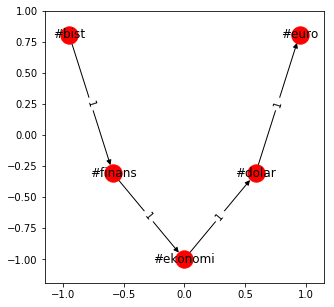

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 12
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
v 5 #kap
e 0 1 1
e 0 5 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 7


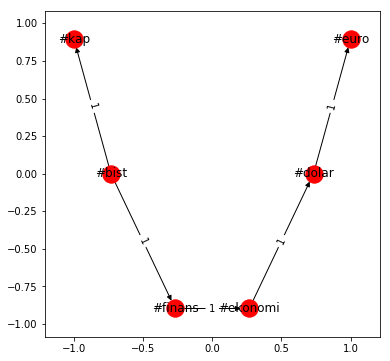

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 13
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #kap
e 0 1 1
e 0 4 1
e 1 2 1
e 2 3 1

Support: 7


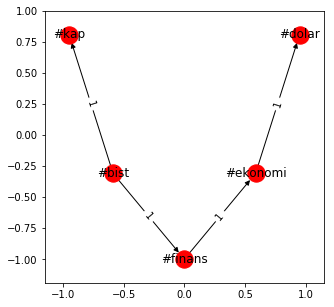

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 14
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #kap
e 0 1 1
e 0 3 1
e 1 2 1

Support: 7


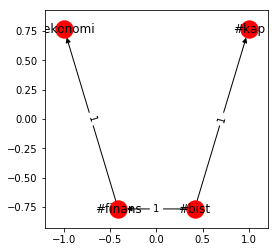

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 15
v 0 #bist
v 1 #finans
v 2 #kap
e 0 1 1
e 0 2 1

Support: 7


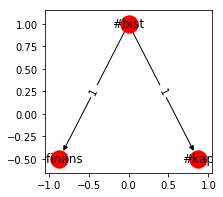

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 16
v 0 #bist
v 1 #kap
e 0 1 1

Support: 8


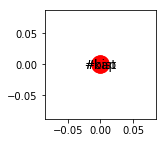

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 17
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 7


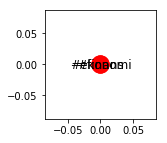

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 18
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 7


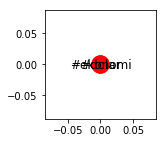

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 19
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 7


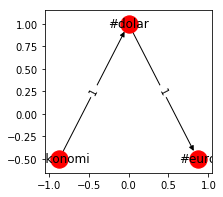

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 20
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 7


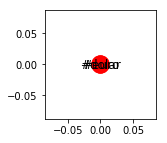

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 21
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 8


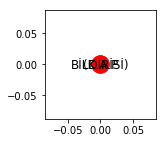

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 22
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
e 0 1 1
e 1 2 1

Support: 7


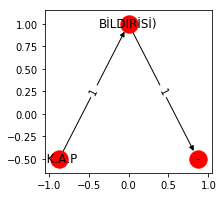

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 23
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


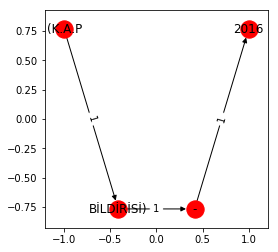

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 24
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
v 4 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


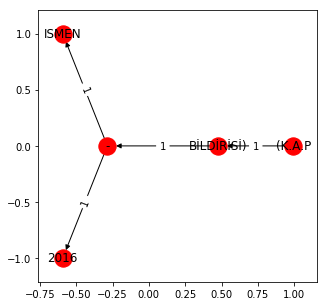

where: [1, 2, 3, 4, 5]

-----------------

t # 25
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
e 0 1 1
e 1 2 1
e 2 3 1

Support: 7


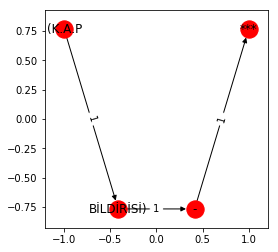

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 26
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


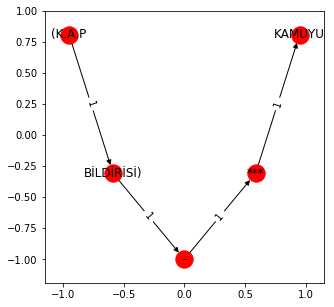

where: [0, 1, 2, 3, 5]

-----------------

t # 27
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


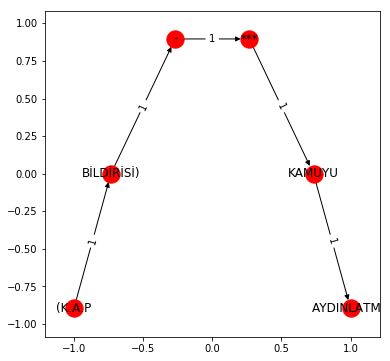

where: [0, 1, 2, 3, 5]

-----------------

t # 28
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


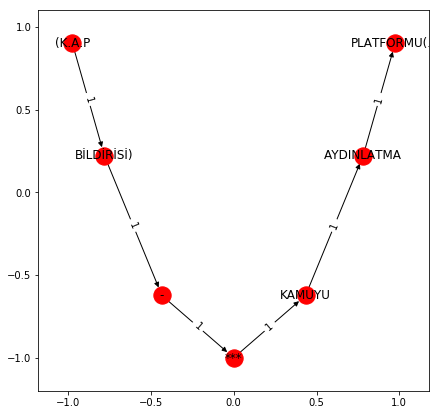

where: [0, 1, 2, 3, 5]

-----------------

t # 29
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 PLATFORMU(...
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 4 5 1
e 5 6 1

Support: 5


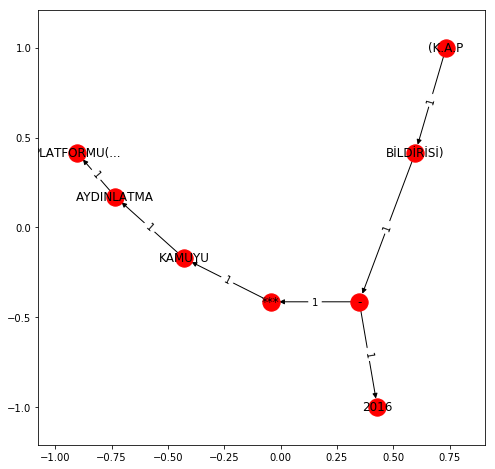

where: [0, 1, 2, 3, 5]

-----------------

t # 30
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 AYDINLATMA
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


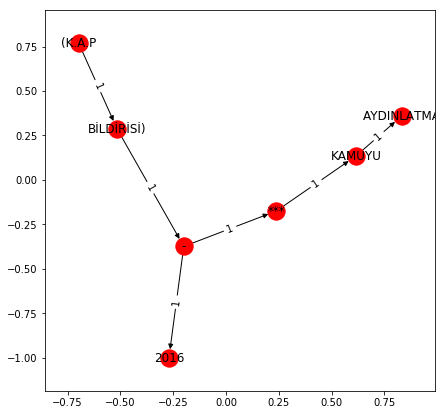

where: [0, 1, 2, 3, 5]

-----------------

t # 31
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 KAMUYU
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


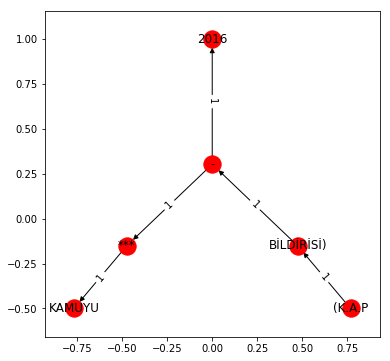

where: [0, 1, 2, 3, 5]

-----------------

t # 32
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


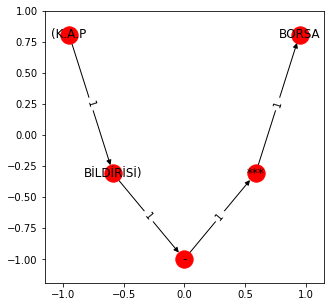

where: [0, 1, 2, 3, 5]

-----------------

t # 33
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 4 5 1

Support: 5


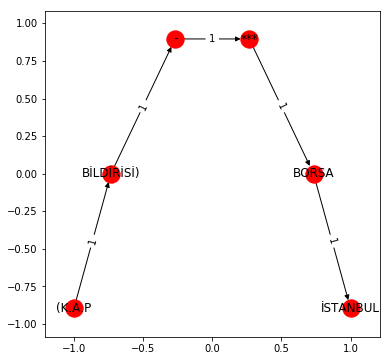

where: [0, 1, 2, 3, 5]

-----------------

t # 34
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1

Support: 5


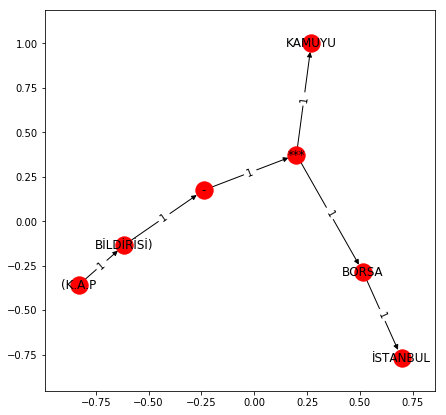

where: [0, 1, 2, 3, 5]

-----------------

t # 35
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1

Support: 5


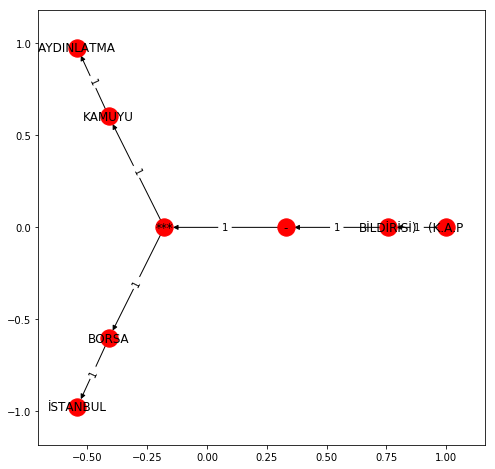

where: [0, 1, 2, 3, 5]

-----------------

t # 36
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1
e 7 8 1

Support: 5


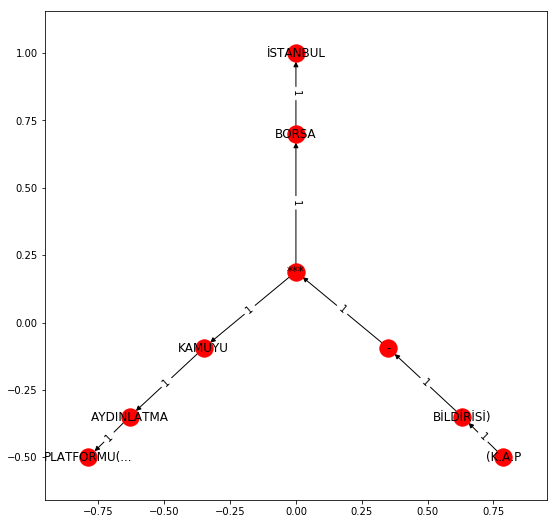

where: [0, 1, 2, 3, 5]

-----------------

t # 37
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 PLATFORMU(...
v 9 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 9 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1
e 7 8 1

Support: 5


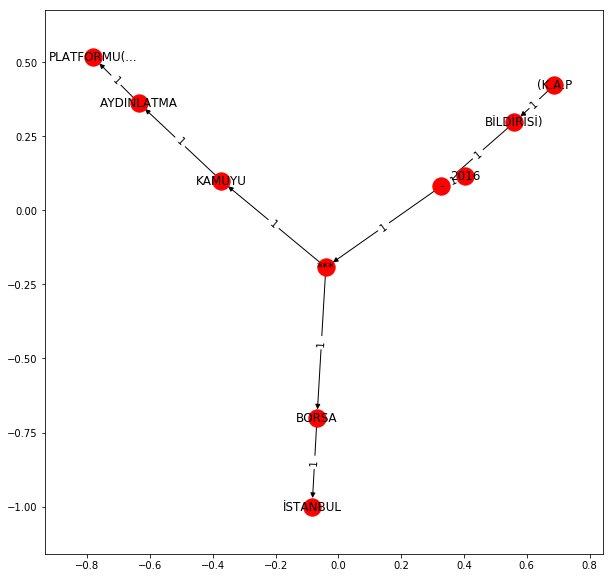

where: [0, 1, 2, 3, 5]

-----------------

t # 38
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 AYDINLATMA
v 8 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 8 1
e 3 4 1
e 3 6 1
e 4 5 1
e 6 7 1

Support: 5


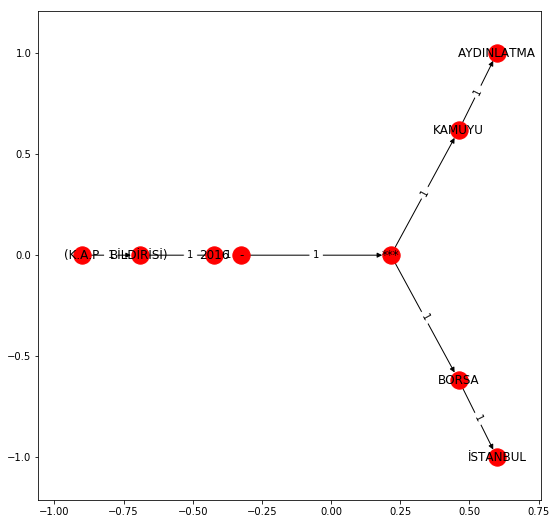

where: [0, 1, 2, 3, 5]

-----------------

t # 39
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 KAMUYU
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 3 6 1
e 4 5 1

Support: 5


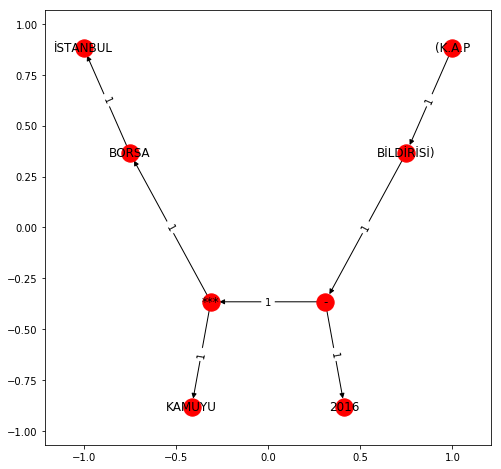

where: [0, 1, 2, 3, 5]

-----------------

t # 40
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 İSTANBUL
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 4 5 1

Support: 5


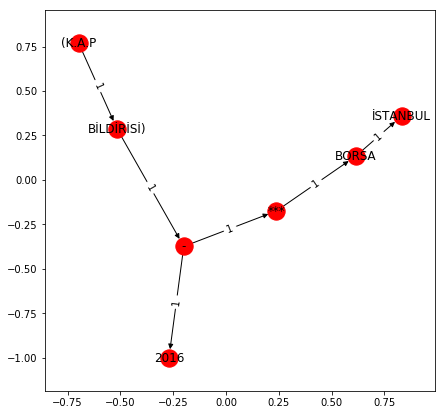

where: [0, 1, 2, 3, 5]

-----------------

t # 41
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1

Support: 5


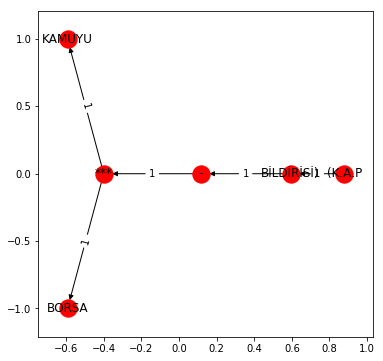

where: [0, 1, 2, 3, 5]

-----------------

t # 42
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1
e 5 6 1

Support: 5


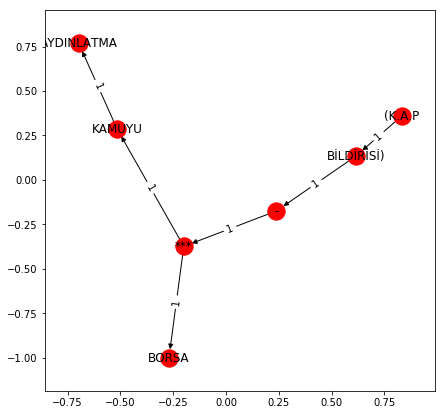

where: [0, 1, 2, 3, 5]

-----------------

t # 43
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1
e 5 6 1
e 6 7 1

Support: 5


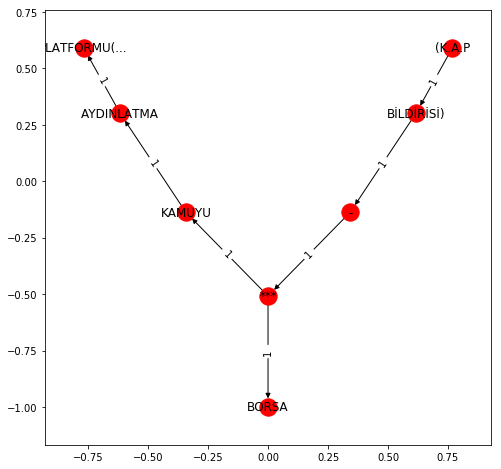

where: [0, 1, 2, 3, 5]

-----------------

t # 44
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 PLATFORMU(...
v 8 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 8 1
e 3 4 1
e 3 5 1
e 5 6 1
e 6 7 1

Support: 5


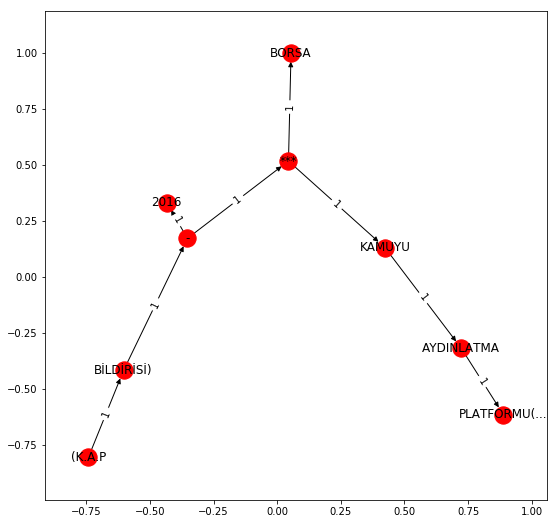

where: [0, 1, 2, 3, 5]

-----------------

t # 45
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 AYDINLATMA
v 7 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 7 1
e 3 4 1
e 3 5 1
e 5 6 1

Support: 5


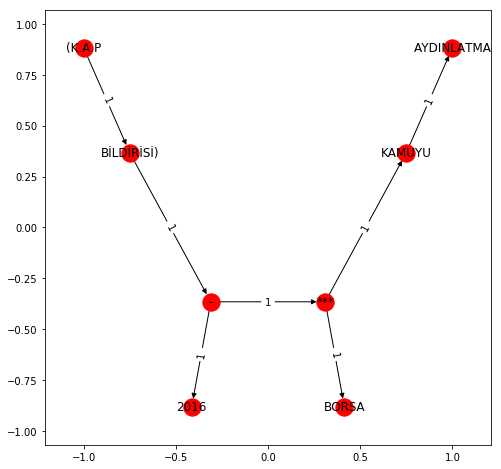

where: [0, 1, 2, 3, 5]

-----------------

t # 46
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 KAMUYU
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


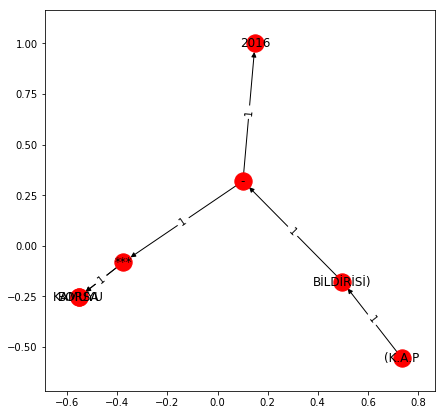

where: [0, 1, 2, 3, 5]

-----------------

t # 47
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 BORSA
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


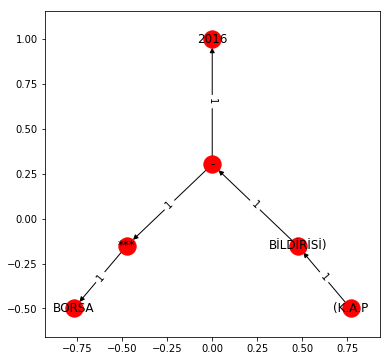

where: [0, 1, 2, 3, 5]

-----------------

t # 48
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 7


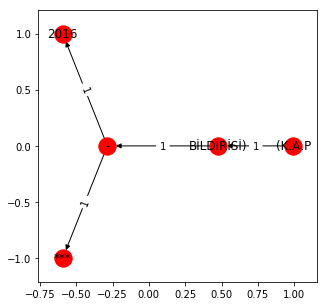

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 49
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
v 5 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1
e 2 5 1

Support: 5


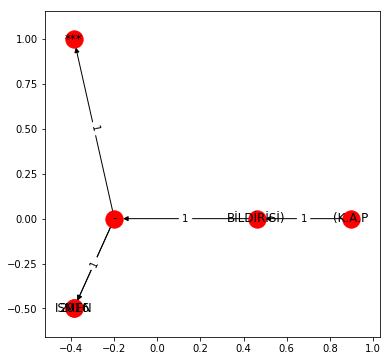

where: [1, 2, 3, 4, 5]

-----------------

t # 50
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


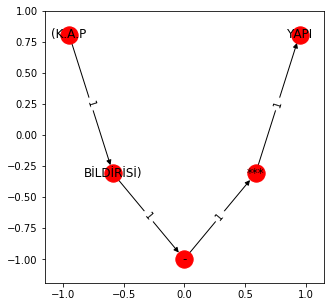

where: [1, 2, 3, 4, 5]

-----------------

t # 51
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1
e 3 5 1

Support: 5


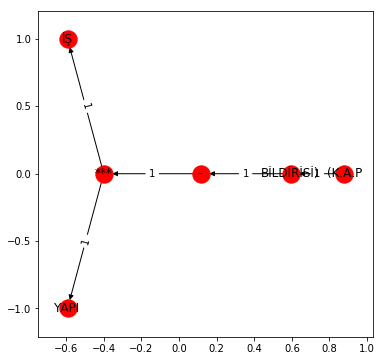

where: [1, 2, 3, 4, 5]

-----------------

t # 52
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
v 6 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


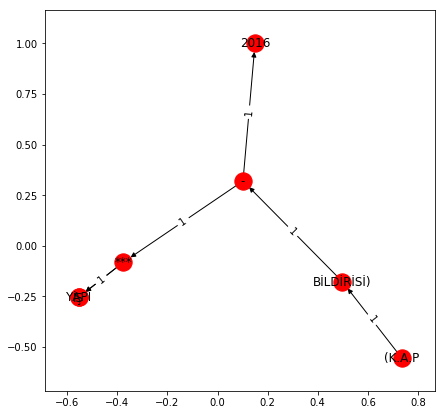

where: [1, 2, 3, 4, 5]

-----------------

t # 53
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
v 6 2016
v 7 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 2 7 1
e 3 4 1
e 3 5 1

Support: 5


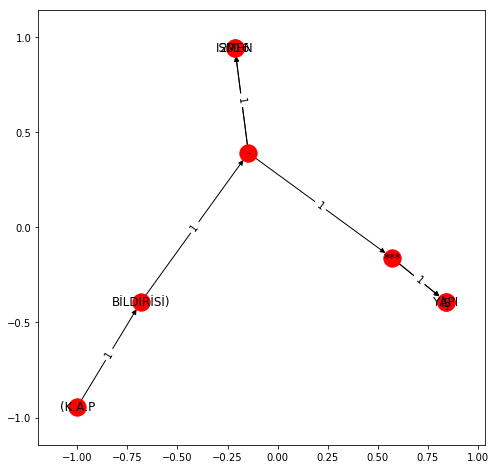

where: [1, 2, 3, 4, 5]

-----------------

t # 54
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 İŞ
v 6 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 6 1
e 3 4 1
e 3 5 1

Support: 5


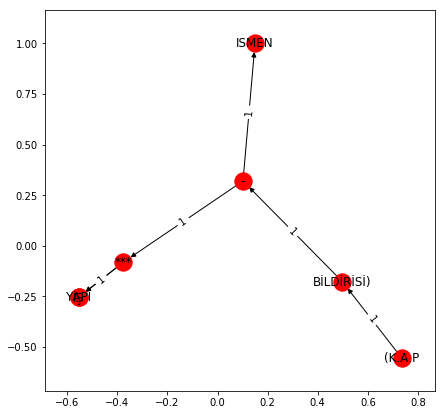

where: [1, 2, 3, 4, 5]

-----------------

t # 55
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


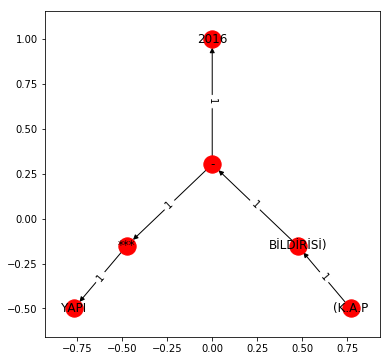

where: [1, 2, 3, 4, 5]

-----------------

t # 56
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 2016
v 6 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 2 6 1
e 3 4 1

Support: 5


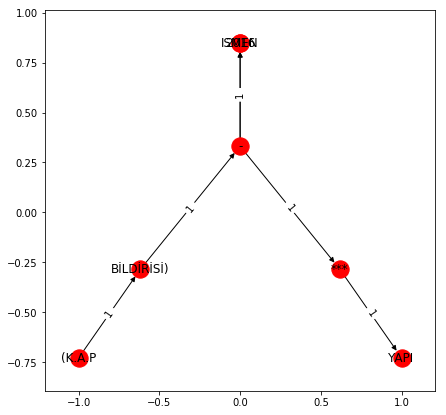

where: [1, 2, 3, 4, 5]

-----------------

t # 57
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 YAPI
v 5 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


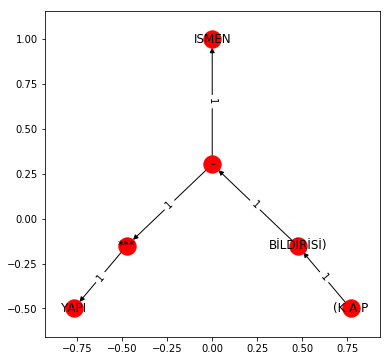

where: [1, 2, 3, 4, 5]

-----------------

t # 58
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


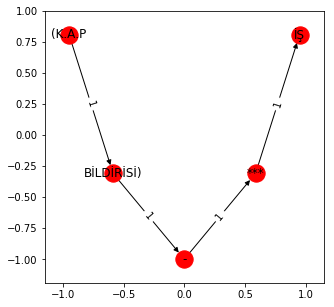

where: [1, 2, 3, 4, 5]

-----------------

t # 59
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
v 5 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


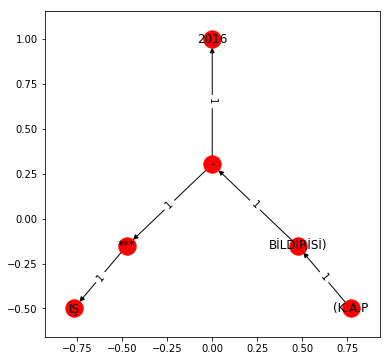

where: [1, 2, 3, 4, 5]

-----------------

t # 60
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
v 5 2016
v 6 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 2 6 1
e 3 4 1

Support: 5


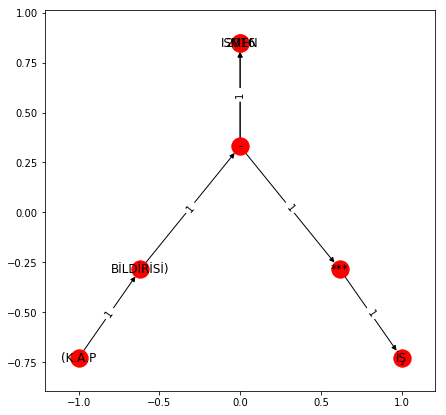

where: [1, 2, 3, 4, 5]

-----------------

t # 61
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 İŞ
v 5 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 5 1
e 3 4 1

Support: 5


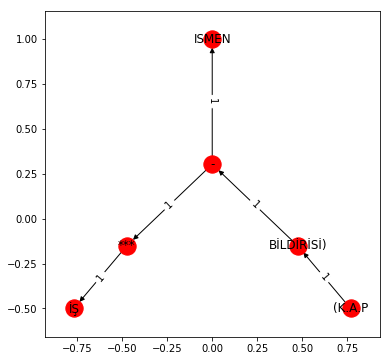

where: [1, 2, 3, 4, 5]

-----------------

t # 62
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


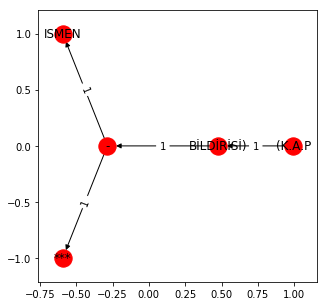

where: [1, 2, 3, 4, 5]

-----------------

t # 63
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ISMEN
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


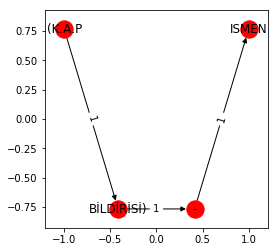

where: [1, 2, 3, 4, 5]

-----------------

t # 64
v 0 BİLDİRİSİ)
v 1 -
e 0 1 1

Support: 7


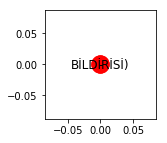

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 65
v 0 BİLDİRİSİ)
v 1 -
v 2 ISMEN
e 0 1 1
e 1 2 1

Support: 5


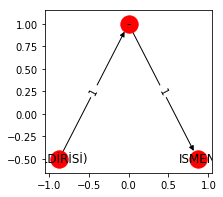

where: [1, 2, 3, 4, 5]

-----------------

t # 66
v 0 -
v 1 2016
e 0 1 1

Support: 7


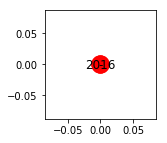

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 67
v 0 -
v 1 2016
v 2 ISMEN
e 0 1 1
e 0 2 1

Support: 5


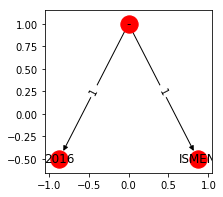

where: [1, 2, 3, 4, 5]

-----------------

t # 68
v 0 -
v 1 ***
e 0 1 1

Support: 8


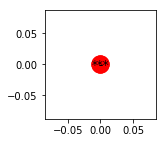

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 69
v 0 -
v 1 ***
v 2 KAMUYU
e 0 1 1
e 1 2 1

Support: 5


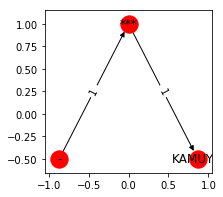

where: [0, 1, 2, 3, 5]

-----------------

t # 70
v 0 -
v 1 ***
v 2 KAMUYU
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


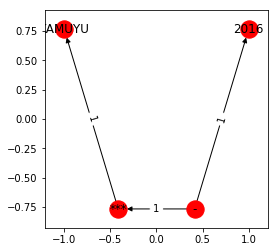

where: [0, 1, 2, 3, 5]

-----------------

t # 71
v 0 -
v 1 ***
v 2 BORSA
e 0 1 1
e 1 2 1

Support: 5


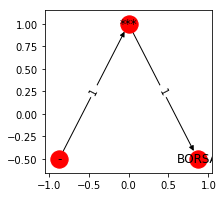

where: [0, 1, 2, 3, 5]

-----------------

t # 72
v 0 -
v 1 ***
v 2 BORSA
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


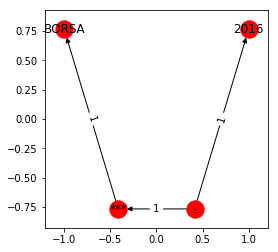

where: [0, 1, 2, 3, 5]

-----------------

t # 73
v 0 -
v 1 ***
v 2 2016
e 0 1 1
e 0 2 1

Support: 7


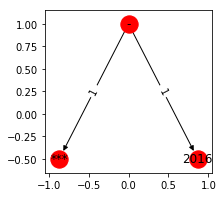

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 74
v 0 -
v 1 ***
v 2 2016
v 3 ISMEN
e 0 1 1
e 0 2 1
e 0 3 1

Support: 5


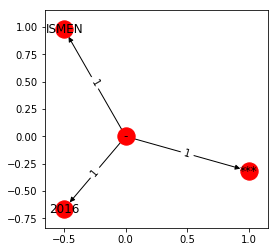

where: [1, 2, 3, 4, 5]

-----------------

t # 75
v 0 -
v 1 ***
v 2 YAPI
e 0 1 1
e 1 2 1

Support: 5


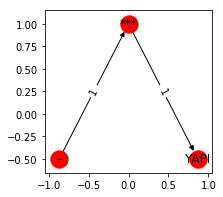

where: [1, 2, 3, 4, 5]

-----------------

t # 76
v 0 -
v 1 ***
v 2 YAPI
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


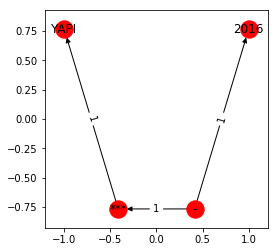

where: [1, 2, 3, 4, 5]

-----------------

t # 77
v 0 -
v 1 ***
v 2 YAPI
v 3 2016
v 4 ISMEN
e 0 1 1
e 0 3 1
e 0 4 1
e 1 2 1

Support: 5


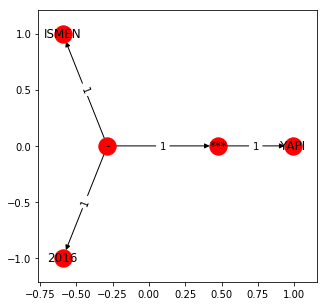

where: [1, 2, 3, 4, 5]

-----------------

t # 78
v 0 -
v 1 ***
v 2 YAPI
v 3 ISMEN
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


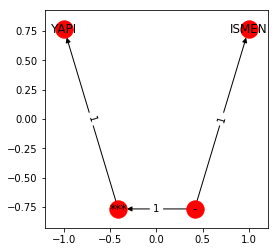

where: [1, 2, 3, 4, 5]

-----------------

t # 79
v 0 -
v 1 ***
v 2 İŞ
e 0 1 1
e 1 2 1

Support: 5


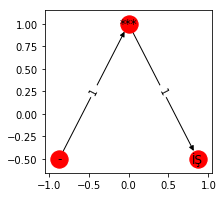

where: [1, 2, 3, 4, 5]

-----------------

t # 80
v 0 -
v 1 ***
v 2 İŞ
v 3 2016
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


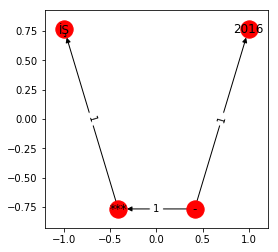

where: [1, 2, 3, 4, 5]

-----------------

t # 81
v 0 -
v 1 ***
v 2 İŞ
v 3 2016
v 4 ISMEN
e 0 1 1
e 0 3 1
e 0 4 1
e 1 2 1

Support: 5


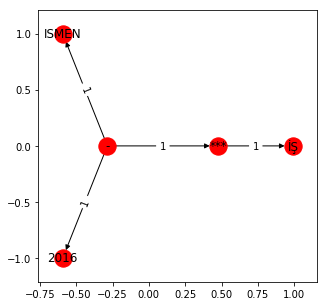

where: [1, 2, 3, 4, 5]

-----------------

t # 82
v 0 -
v 1 ***
v 2 İŞ
v 3 ISMEN
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


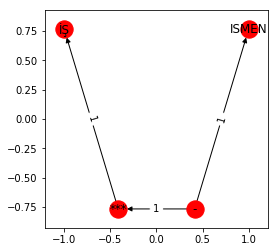

where: [1, 2, 3, 4, 5]

-----------------

t # 83
v 0 -
v 1 ***
v 2 ISMEN
e 0 1 1
e 0 2 1

Support: 5


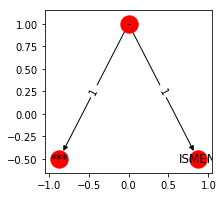

where: [1, 2, 3, 4, 5]

-----------------

t # 84
v 0 Ekim
v 1 2016
e 0 1 1

Support: 7


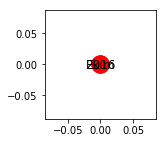

where: [0, 1, 2, 3, 4, 5, 7]

-----------------

t # 85
v 0 ***
v 1 KAMUYU
e 0 1 1

Support: 5


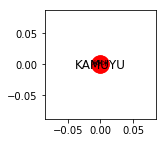

where: [0, 1, 2, 3, 5]

-----------------

t # 86
v 0 ***
v 1 KAMUYU
v 2 AYDINLATMA
e 0 1 1
e 1 2 1

Support: 5


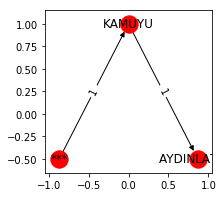

where: [0, 1, 2, 3, 5]

-----------------

t # 87
v 0 ***
v 1 KAMUYU
v 2 AYDINLATMA
v 3 PLATFORMU(...
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


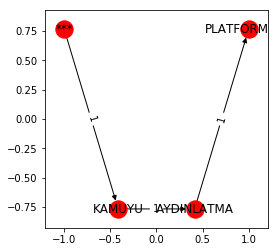

where: [0, 1, 2, 3, 5]

-----------------

t # 88
v 0 ***
v 1 BORSA
e 0 1 1

Support: 5


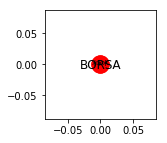

where: [0, 1, 2, 3, 5]

-----------------

t # 89
v 0 ***
v 1 BORSA
v 2 İSTANBUL
e 0 1 1
e 1 2 1

Support: 5


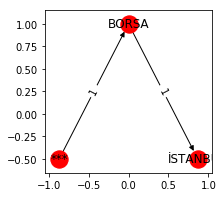

where: [0, 1, 2, 3, 5]

-----------------

t # 90
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


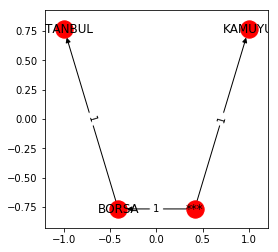

where: [0, 1, 2, 3, 5]

-----------------

t # 91
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
v 4 AYDINLATMA
e 0 1 1
e 0 3 1
e 1 2 1
e 3 4 1

Support: 5


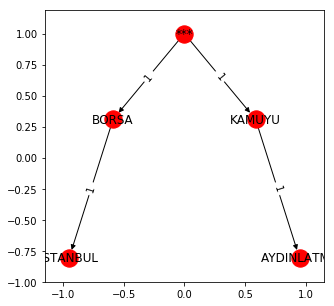

where: [0, 1, 2, 3, 5]

-----------------

t # 92
v 0 ***
v 1 BORSA
v 2 İSTANBUL
v 3 KAMUYU
v 4 AYDINLATMA
v 5 PLATFORMU(...
e 0 1 1
e 0 3 1
e 1 2 1
e 3 4 1
e 4 5 1

Support: 5


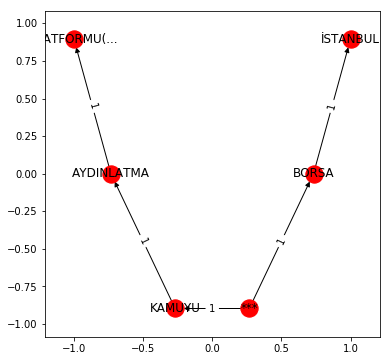

where: [0, 1, 2, 3, 5]

-----------------

t # 93
v 0 ***
v 1 BORSA
v 2 KAMUYU
e 0 1 1
e 0 2 1

Support: 5


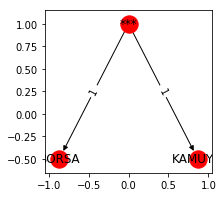

where: [0, 1, 2, 3, 5]

-----------------

t # 94
v 0 ***
v 1 BORSA
v 2 KAMUYU
v 3 AYDINLATMA
e 0 1 1
e 0 2 1
e 2 3 1

Support: 5


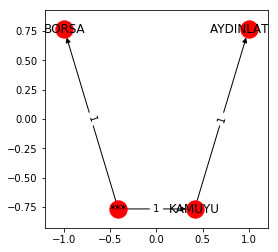

where: [0, 1, 2, 3, 5]

-----------------

t # 95
v 0 ***
v 1 BORSA
v 2 KAMUYU
v 3 AYDINLATMA
v 4 PLATFORMU(...
e 0 1 1
e 0 2 1
e 2 3 1
e 3 4 1

Support: 5


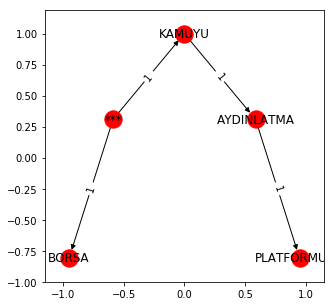

where: [0, 1, 2, 3, 5]

-----------------

t # 96
v 0 KAMUYU
v 1 AYDINLATMA
e 0 1 1

Support: 5


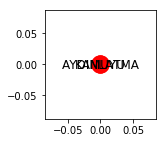

where: [0, 1, 2, 3, 5]

-----------------

t # 97
v 0 KAMUYU
v 1 AYDINLATMA
v 2 PLATFORMU(...
e 0 1 1
e 1 2 1

Support: 5


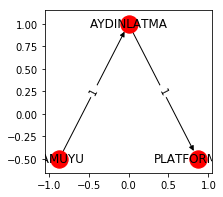

where: [0, 1, 2, 3, 5]

-----------------

t # 98
v 0 AYDINLATMA
v 1 PLATFORMU(...
e 0 1 1

Support: 5


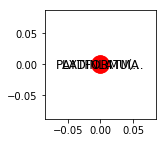

where: [0, 1, 2, 3, 5]

-----------------

t # 99
v 0 YATIRIM
v 1 OR...
e 0 1 1

Support: 5


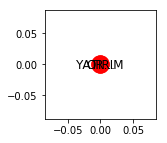

where: [0, 1, 2, 3, 4]

-----------------

t # 100
v 0 BORSA
v 1 İSTANBUL
e 0 1 1

Support: 5


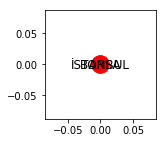

where: [0, 1, 2, 3, 5]

-----------------

t # 101
v 0 -
v 1 ISMEN
e 0 1 1

Support: 5


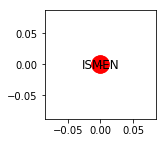

where: [1, 2, 3, 4, 5]

-----------------

t # 102
v 0 ***
v 1 YAPI
e 0 1 1

Support: 5


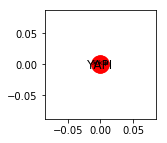

where: [1, 2, 3, 4, 5]

-----------------

t # 103
v 0 ***
v 1 YAPI
v 2 İŞ
e 0 1 1
e 0 2 1

Support: 5


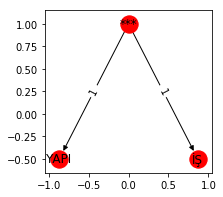

where: [1, 2, 3, 4, 5]

-----------------

t # 104
v 0 ***
v 1 İŞ
e 0 1 1

Support: 5


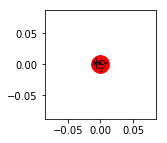

where: [1, 2, 3, 4, 5]

-----------------

t # 105
v 0 #hisse
v 1 ##ISMEN
e 0 1 1

Support: 5


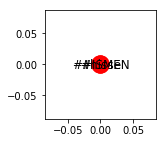

where: [1, 2, 3, 4, 5]

-----------------

t # 106
v 0 YATIRIM
v 1 MENKUL
e 0 1 1

Support: 5


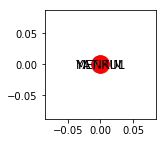

where: [1, 2, 3, 4, 5]

-----------------

t # 107
v 0 MENKUL
v 1 DEĞERLER
e 0 1 1

Support: 5


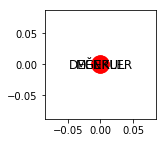

where: [1, 2, 3, 4, 5]

-----------------

t # 108
v 0 DEĞERLER
v 1 A...
e 0 1 1

Support: 5


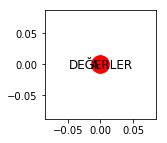

where: [1, 2, 3, 4, 5]

-----------------

t # 109
v 0 A...
v 1 ##ISMEN
e 0 1 1

Support: 5


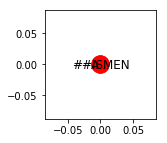

where: [1, 2, 3, 4, 5]

-----------------

Read:	0.3 s
Mine:	-0.3 s
Total:	0.0 s
t # 0
v 0 (K.A.P
v 1 BİLDİRİSİ)
e 0 1 1

Support: 6


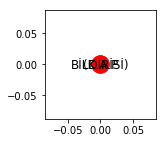

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 1
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
e 0 1 1
e 1 2 1

Support: 5


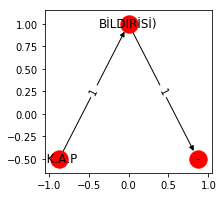

where: [0, 1, 2, 3, 5]

-----------------

t # 2
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 2016
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


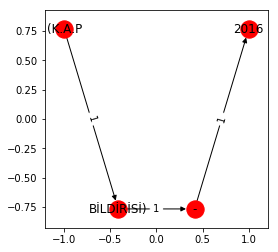

where: [0, 1, 2, 3, 5]

-----------------

t # 3
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


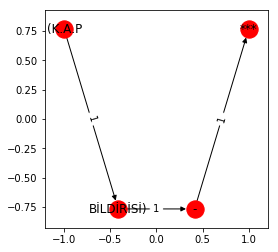

where: [0, 1, 2, 3, 5]

-----------------

t # 4
v 0 (K.A.P
v 1 BİLDİRİSİ)
v 2 -
v 3 ***
v 4 2016
e 0 1 1
e 1 2 1
e 2 3 1
e 2 4 1

Support: 5


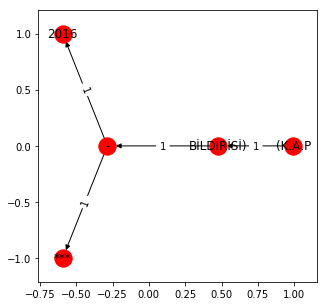

where: [0, 1, 2, 3, 5]

-----------------

t # 5
v 0 BİLDİRİSİ)
v 1 -
e 0 1 1

Support: 5


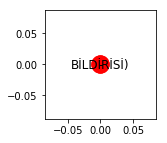

where: [0, 1, 2, 3, 5]

-----------------

t # 6
v 0 -
v 1 2016
e 0 1 1

Support: 5


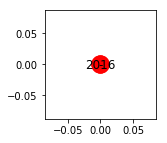

where: [0, 1, 2, 3, 5]

-----------------

t # 7
v 0 -
v 1 ***
e 0 1 1

Support: 6


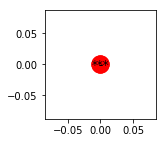

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 8
v 0 -
v 1 ***
v 2 2016
e 0 1 1
e 0 2 1

Support: 5


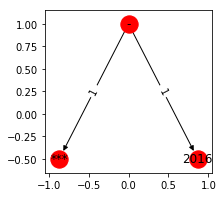

where: [0, 1, 2, 3, 5]

-----------------

t # 9
v 0 Ekim
v 1 2016
e 0 1 1

Support: 5


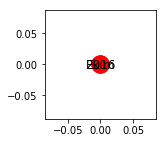

where: [0, 1, 2, 3, 5]

-----------------

t # 10
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 6


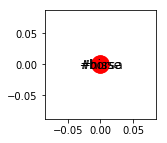

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 11
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 6


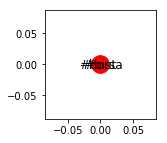

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 12
v 0 #borsa
v 1 #bist
v 2 #kap
e 0 1 1
e 1 2 1

Support: 6


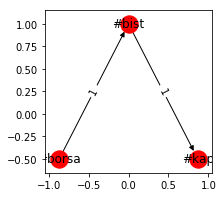

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 13
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 5


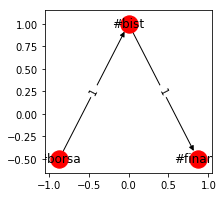

where: [0, 1, 2, 3, 5]

-----------------

t # 14
v 0 #bist
v 1 #kap
e 0 1 1

Support: 6


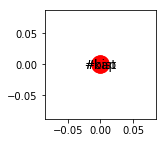

where: [0, 1, 2, 3, 4, 5]

-----------------

t # 15
v 0 #bist
v 1 #finans
e 0 1 1

Support: 5


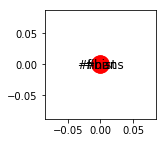

where: [0, 1, 2, 3, 5]

-----------------

t # 16
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 5


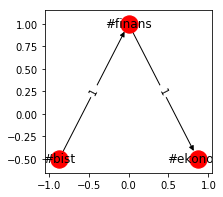

where: [0, 1, 2, 3, 5]

-----------------

t # 17
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


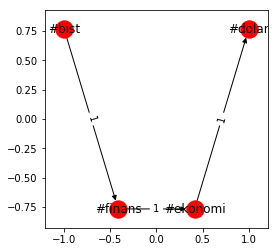

where: [0, 1, 2, 3, 5]

-----------------

t # 18
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


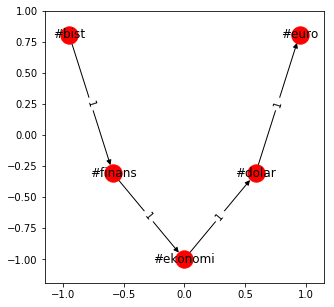

where: [0, 1, 2, 3, 5]

-----------------

t # 19
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
v 5 #kap
e 0 1 1
e 0 5 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


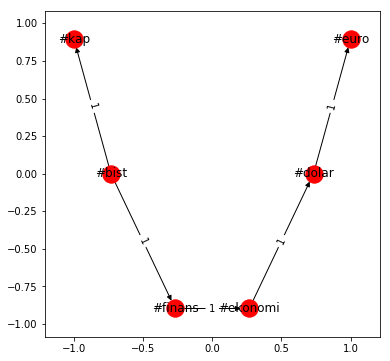

where: [0, 1, 2, 3, 5]

-----------------

t # 20
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #kap
e 0 1 1
e 0 4 1
e 1 2 1
e 2 3 1

Support: 5


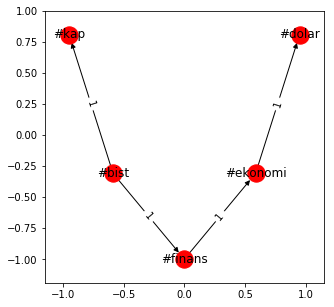

where: [0, 1, 2, 3, 5]

-----------------

t # 21
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #kap
e 0 1 1
e 0 3 1
e 1 2 1

Support: 5


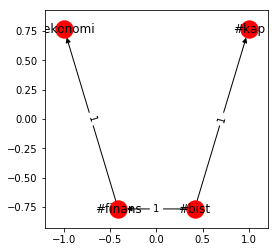

where: [0, 1, 2, 3, 5]

-----------------

t # 22
v 0 #bist
v 1 #finans
v 2 #kap
e 0 1 1
e 0 2 1

Support: 5


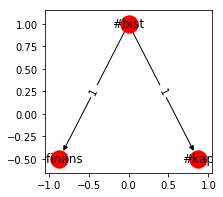

where: [0, 1, 2, 3, 5]

-----------------

t # 23
v 0 haber,
v 1 yorum
e 0 1 1

Support: 5


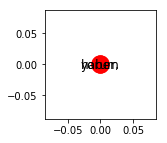

where: [0, 1, 2, 3, 5]

-----------------

t # 24
v 0 ve
v 1 analizleri
e 0 1 1

Support: 5


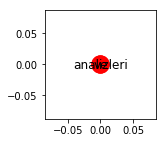

where: [0, 1, 2, 3, 5]

-----------------

t # 25
v 0 analizleri
v 1 !
e 0 1 1

Support: 5


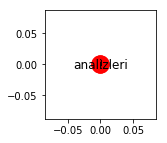

where: [0, 1, 2, 3, 5]

-----------------

t # 26
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 5


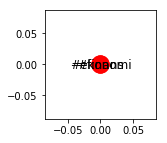

where: [0, 1, 2, 3, 5]

-----------------

t # 27
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 5


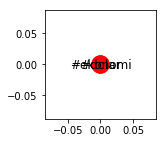

where: [0, 1, 2, 3, 5]

-----------------

t # 28
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 5


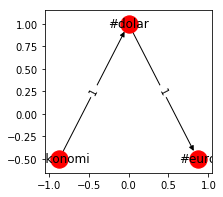

where: [0, 1, 2, 3, 5]

-----------------

t # 29
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 5


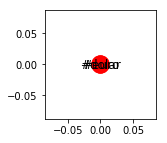

where: [0, 1, 2, 3, 5]

-----------------

Read:	0.04 s
Mine:	-0.04 s
Total:	0.0 s
t # 0
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 5


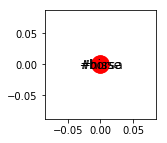

where: [0, 1, 2, 3, 7]

-----------------

t # 1
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 5


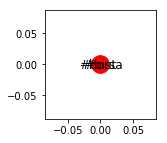

where: [0, 1, 2, 3, 7]

-----------------

t # 2
v 0 11.2016
v 1 2016
e 0 1 1

Support: 6


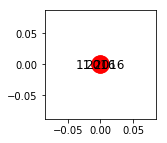

where: [2, 3, 4, 5, 6, 7]

-----------------

Read:	0.03 s
Mine:	-0.03 s
Total:	0.0 s
t # 0
v 0 11.2016
v 1 2016
e 0 1 1

Support: 8


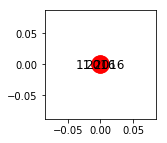

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.24 s
Mine:	-0.24 s
Total:	0.0 s
t # 0
v 0 11.2016
v 1 2016
e 0 1 1

Support: 8


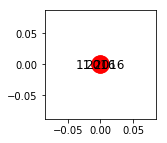

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

Read:	0.01 s
Mine:	-0.01 s
Total:	0.0 s
t # 0
v 0 11.2016
v 1 2016
e 0 1 1

Support: 8


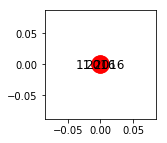

where: [0, 1, 2, 3, 4, 5, 6, 7]

-----------------

t # 1
v 0 ve
v 1 analizleri
e 0 1 1

Support: 5


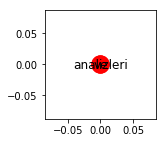

where: [1, 3, 4, 5, 7]

-----------------

t # 2
v 0 haber,
v 1 yorum
e 0 1 1

Support: 5


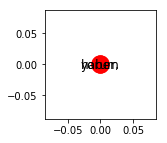

where: [1, 3, 4, 5, 7]

-----------------

t # 3
v 0 #hisse
v 1 #borsa
e 0 1 1

Support: 5


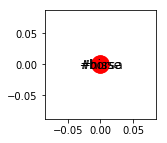

where: [1, 3, 4, 5, 7]

-----------------

t # 4
v 0 #borsa
v 1 #bist
e 0 1 1

Support: 5


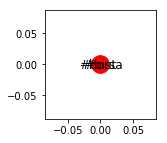

where: [1, 3, 4, 5, 7]

-----------------

t # 5
v 0 #borsa
v 1 #bist
v 2 #finans
e 0 1 1
e 1 2 1

Support: 5


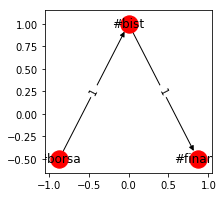

where: [1, 3, 4, 5, 7]

-----------------

t # 6
v 0 #bist
v 1 #finans
e 0 1 1

Support: 5


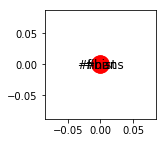

where: [1, 3, 4, 5, 7]

-----------------

t # 7
v 0 #bist
v 1 #finans
v 2 #ekonomi
e 0 1 1
e 1 2 1

Support: 5


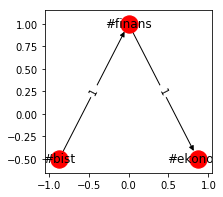

where: [1, 3, 4, 5, 7]

-----------------

t # 8
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
e 0 1 1
e 1 2 1
e 2 3 1

Support: 5


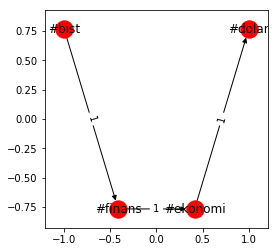

where: [1, 3, 4, 5, 7]

-----------------

t # 9
v 0 #bist
v 1 #finans
v 2 #ekonomi
v 3 #dolar
v 4 #euro
e 0 1 1
e 1 2 1
e 2 3 1
e 3 4 1

Support: 5


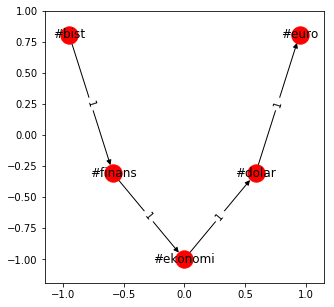

where: [1, 3, 4, 5, 7]

-----------------

t # 10
v 0 #finans
v 1 #ekonomi
e 0 1 1

Support: 5


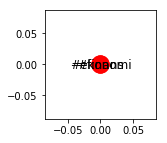

where: [1, 3, 4, 5, 7]

-----------------

t # 11
v 0 #ekonomi
v 1 #dolar
e 0 1 1

Support: 5


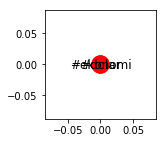

where: [1, 3, 4, 5, 7]

-----------------

t # 12
v 0 #ekonomi
v 1 #dolar
v 2 #euro
e 0 1 1
e 1 2 1

Support: 5


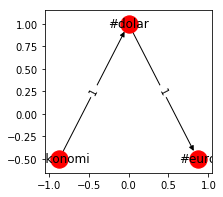

where: [1, 3, 4, 5, 7]

-----------------

t # 13
v 0 #dolar
v 1 #euro
e 0 1 1

Support: 5


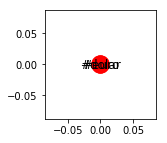

where: [1, 3, 4, 5, 7]

-----------------

Read:	0.02 s
Mine:	-0.02 s
Total:	0.0 s


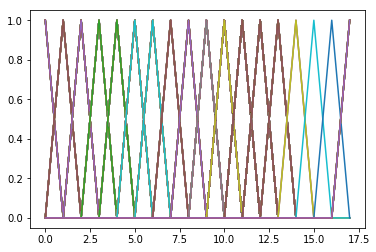

In [177]:
# run_all method parameters respectively
# support, window_value, distance, database_choice
all_graphs = run_all(5,8,2,2)

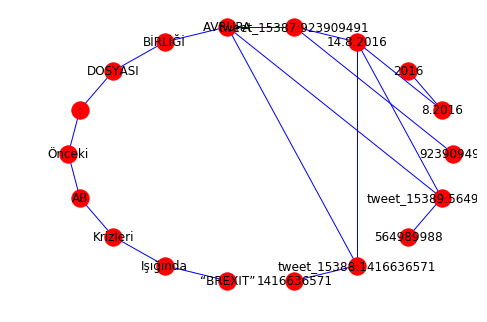

In [178]:
for graphs in all_graphs:
    print(graphs)
    DrawNX(graphs)
    break

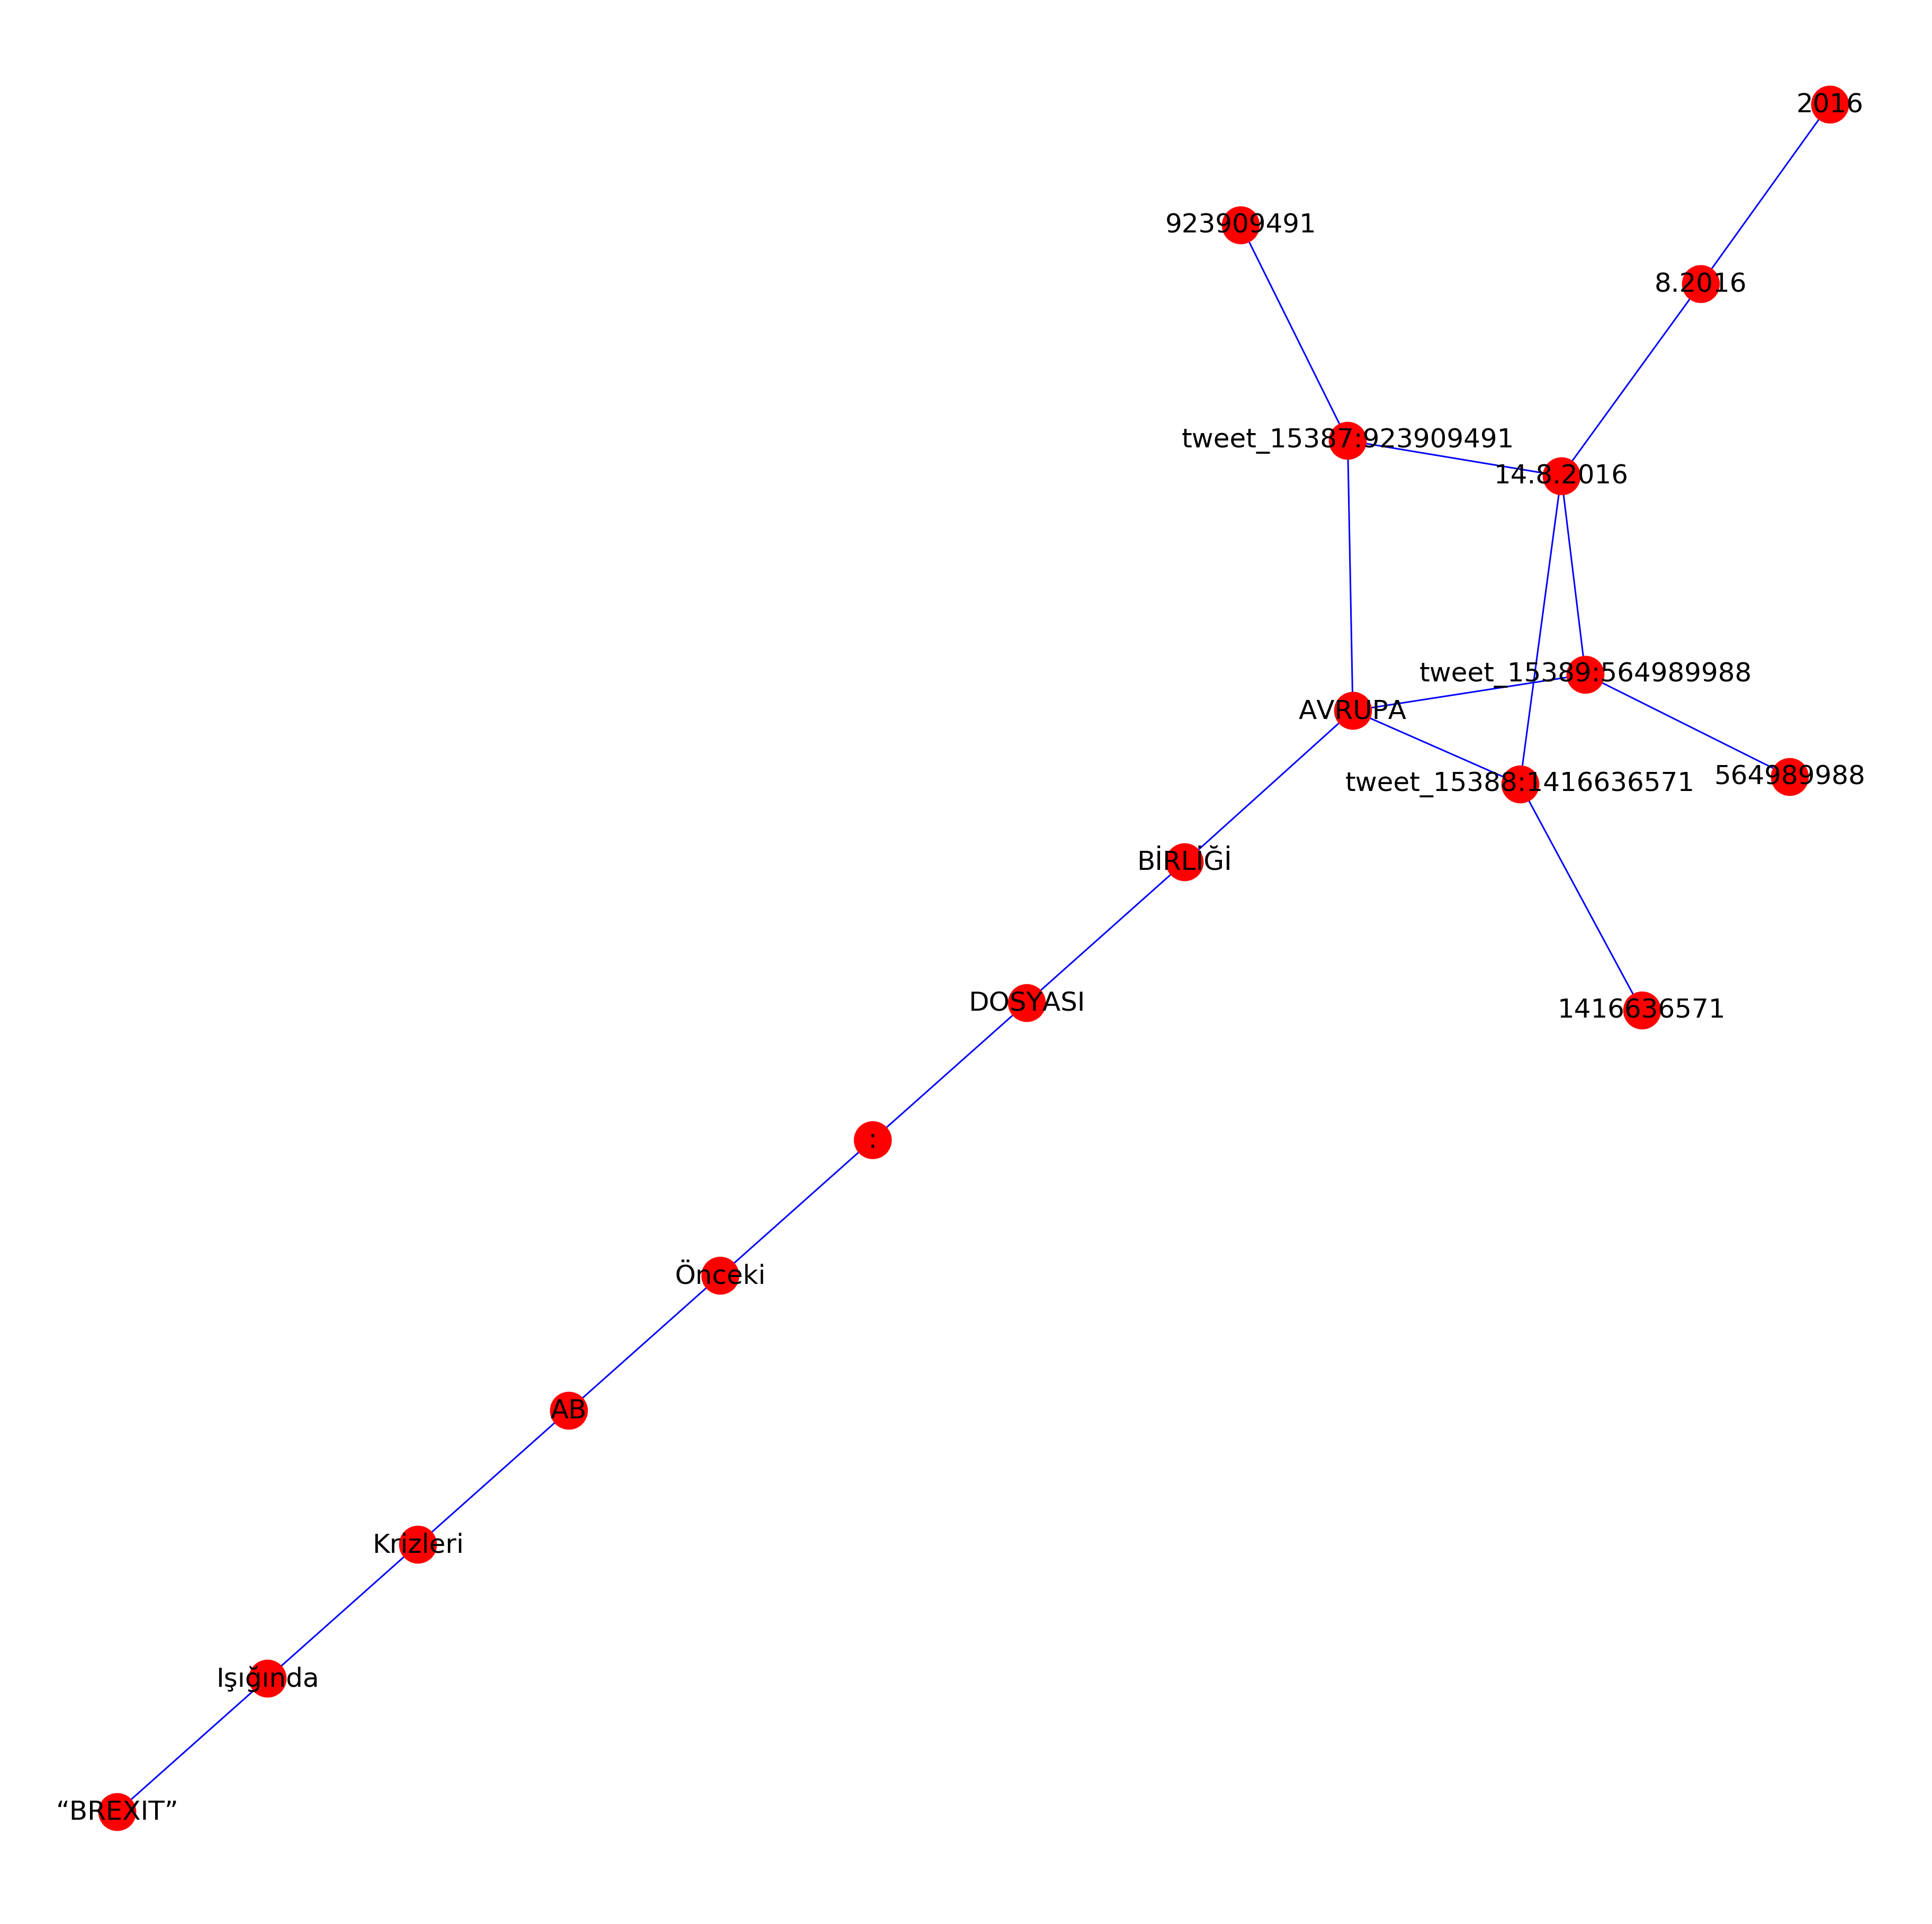

In [179]:
for graphs in all_graphs:
    print(graphs)
    DrawNX(graphs, param="kamada")
    break